<a href="https://colab.research.google.com/github/RSwallow987/dissertation/blob/main/GAN_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a GAN to fit a one-dimentional distribution

**GAN Connoseur Uses this Architecture**
Cricits:
L1: 11
L2: 29
L3:11
L4:1 
Generators:
L1:7
L2:13
L3:7
L4:1

For both critics and generators they use a ELU (exponential linear unit) and an adam optimiser.

They grid search for G:D update ratio and the learning rate. 

They train for 1e6 itterations and have a batch size of 1e5.


**Questions**

I should probably set some type of random seed so its reproducable ?

**To Do**


1.   How to compare the best one ? Do you graph the samples and compute the evaluation metrics each time ? 
2.   Implement a WGAN with weight clipping aswell 
3. Maybe also track the time it takes to train the GAN. 
4. Try match the results found by the other team.
4. Implement MMD GAN 
5. Implement CGAN 



First goal will be building a vanilla GAN to sample from from the normal distribution with a N(5,1) - when getting samples from a N(0,1) and a U(-1,1) distributions.

Firstly import pytorch and other useful packages and libraries. 

In [6]:
import torch
from torch import nn
import numpy as np
from tqdm.auto import tqdm #Progress Bars 

torch.manual_seed(0)

#Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation

#Example data 
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import pandas as pd
import math as m

Setting a random seed for reproducible results.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Vanilla GAN 
So questions: Can a 1D GAN output have modal collapse ? 
Do I have to even do batch normalization ? It's not like it's an image ?

#### Generator 
A generator block is built with a helper function to generate layers (a block) for the generator network. Each block/layer will have a linear transformation to map to another shape, potentially batch normalisation (however I don't think this is necessary) and then a non-linear activation function (in this case ReLu).

In [ ]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        #nn.BatchNorm1d(output_dim), 
        nn.ReLU(inplace=True)
        #nn.ELU(alpha=1,inplace=True)
    )

Test Block with a forward pass.

**Testing**

In [ ]:
block = get_generator_block(12, 15)

In [ ]:
print(len(block))
print(type(block[0]))
print(type(block[1]))
test_input = torch.randn(1000, 12)
test_output = block(test_input)
tuple(test_output.shape)

2
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>


(1000, 15)

Now that we have the two helper functions we can build a generator class. For our problem, this will taje in the noise vector dimentions, the output dimention (is this just one output or 100000 samples ?) as well as the initial hidden dimentions (i.e. the number of neurons in each of the layers). 

Using these values, the generator will build a neural network with N layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the sample to be outputted.

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        sample_dim: the dimension of the samples, fitted for the dataset used, a scalar.
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, sample_dim=1, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4 ),
            get_generator_block(hidden_dim * 4 , hidden_dim * 8 ),
            nn.Linear(hidden_dim * 8,sample_dim),
            #nn.Sigmoid() #
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

Test that everything is working properly. 

In [ ]:
# Verify the generator class
def test_generator(z_dim, sample_dim, hidden_dim, num_test=10000):
    gen = Generator(z_dim, sample_dim, hidden_dim).get_gen()
    
    # Check there are six modules in the sequential part
    #assert len(gen) == 6
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    assert tuple(test_output.shape) == (num_test, sample_dim)
    # assert test_output.max() < 1, "Make sure to use a sigmoid"
    # assert test_output.min() > 0, "Make sure to use a sigmoid"
    # assert test_output.min() < 0.5, "Don't use a block in your solution"
    # assert test_output.std() > 0.05, "Don't use batchnorm here"
    # assert test_output.std() < 0.15, "Don't use batchnorm here"

test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success!")

Success!


In [ ]:
gen = Generator(10, 1, 60).get_gen()
len(gen)
test_input = torch.randn(10000, 10)
test_output = gen(test_input)

In [ ]:
test_output.shape

torch.Size([10000, 1])

In [ ]:
test_input.shape

torch.Size([10000, 10])

### Noise
 Since multiple samples will be processed per pass, we will generate all the noise vectors at once

In [ ]:
mu, sigma = 0, 1 # mean and standard deviation
norm = np.random.normal(mu, sigma, 1000)
unif = np.random.uniform(-1,1,1000)

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    norm=torch.randn(n_samples,z_dim,device=device) #outputs normal distribution N(0,1)
    uniform=torch.rand(n_samples,z_dim,device=device) #outputs uniform distribution U(0,1)
    return norm , uniform

In [ ]:
n,u=get_noise(10,100,'cpu')

Testing transformations of normal distribution.

In [ ]:
n5=n*1+5
n5.mean()
n5.std()

tensor(0.9908)

### Discriminator
Note on activation function choice: leaky ReLUs are used to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient.

In [ ]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [ ]:
# Verify the discriminator block function
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)

    # Check there are two parts
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    # Check that the shape is right
    assert tuple(test_output.shape) == (num_test, out_features)
    
    # Check that the LeakyReLU slope is about 0.2
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5

test_disc_block(25, 12)
test_disc_block(15, 28)
print("Success!")

Success!


The functions will be used to to create layers/blocks of the discriminator. The discriminator class will hold twon values, namely the input sample distribution and the hidden dimentions. The discriminator class will build a neural network with N layers. It will start with the sample dimentions and transform it until it returns a single number output. This output classifies the sample as real or not. A sigmoid function isn't used here as it is included in the loss function used. 

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        sample_dim: the dimension of the sample, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, sample_dim=1, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(sample_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, sample):
        '''
        Function for completing a forward pass of the discriminator: Given an sample tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            sample: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(sample)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [ ]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):
    
    disc = Discriminator(z_dim, hidden_dim).get_disc()

    # Check there are three parts
    assert len(disc) == 4

    # Check the linear layer is correct
    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)
    
    # Don't use a block
    assert not isinstance(disc[-1], nn.Sequential)

test_discriminator(5, 10)
test_discriminator(20, 8)
print("Success!")

Success!


**Understanding **

In [ ]:
disc = Discriminator(1, 60).get_disc()
test_input = torch.randn(10000, 1)
test_output = disc(test_input)

In [ ]:
print(test_output.shape)
test_input.shape

torch.Size([10000, 1])


torch.Size([10000, 1])

### Training 
Setting the following parameters:
* criterion: the loss function
* n_epochs: the number of times you iterate through the entire dataset when training
* z_dim: the dimension of the noise vector
* display_step: how often to display/visualize the images
* batch_size: the number of images per forward/backward pass
* lr: the learning rate
* device: the device type, here using a GPU (which runs CUDA), not CPU

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs =50
z_dim = 10 #input dimentions
hidden_dims=128
output_dims=1
display_step = 1000
batch_size = 512 #number of samples
lr = 0.00001

# dataloader = DataLoader(
#     MNIST('.', download=True, transform=transforms.ToTensor()),
#     batch_size=batch_size,
#     shuffle=True)
data=torch.randn(batch_size,1)*1+5

### DO NOT EDIT ###
device = 'cuda'

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
data.shape
#print(dataloader)

torch.Size([512, 1])

Now, we can initialize the generator, discriminator, and optimizers. 

Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [ ]:
gen = Generator(z_dim,output_dims,hidden_dims).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(output_dims, hidden_dims).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Now we will create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, we will need to detach the model on the generator result to ensure that only the discriminator is updated!


In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_samples, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the samples 
               (e.g. fake = 0, real = 1)
        real: a batch of real samples
        num_samples: the number of samples the generator should produce, 
                which is also the length of the real samples
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #       1) Create noise vectors and generate a batch (num_samples) of fake samples. 
    #       2) Get the discriminator's prediction of the fake samples
    #            and calculate the loss while detaching the generator model.
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.

    z=get_noise(num_samples,z_dim,device=device)
    fakes=gen(z[0]).detach() 
    
    pred_fake=disc(fakes)
    zeros= torch.zeros_like(pred_fake)
    fake_loss=criterion(pred_fake,zeros)
    
    pred_real=disc(real)
    ones=torch.ones_like(pred_real)
    real_loss=criterion(pred_real,ones)

    disc_loss=(fake_loss + real_loss)/2

    return disc_loss

In [ ]:
z=get_noise(128,1,device=device)
z[0].shape

torch.Size([128, 1])

In [ ]:
def get_gen_loss(gen, disc, criterion, num_samples, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an sample given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_samples: the number of samples the generator should produce, 
                which is also the length of the real samples
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #       1) Create noise vectors and generate a batch of fake samples. 
    #       2) Get the discriminator's prediction of the fake samples.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    z=get_noise(num_samples,z_dim,device=device)
    samples=gen(z[0])
    pred=disc(samples)
    gen_loss=criterion(pred,torch.ones_like(pred))
    return gen_loss

In [ ]:
def test_gen_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_gen_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None
    
    z_dim = 1
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)
    

def test_gen_loss(num_images):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    
    gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)
    
    # Check that the loss is reasonable
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))


test_gen_reasonable(10)
test_gen_loss(18)
print("Success!")

Success!


For each epoch we will process the entire dataset in batches. For every batch, the function will need to update the discriminator and generator using their loss. 

(Note that you may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess.)

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN.

After you've submitted a working version with the original architecture, feel free to play around with the architecture if you want to see how different architectural choices can lead to better or worse GANs. For example, consider changing the size of the hidden dimension, or making the networks shallower or deeper by changing the number of layers.

But remember, don’t expect anything spectacular: this is only the first lesson. We need to implement methods to help keep your generator and discriminator at similar levels of learning/performance.

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.7410692093372353, discriminator loss: 0.6488148897588243


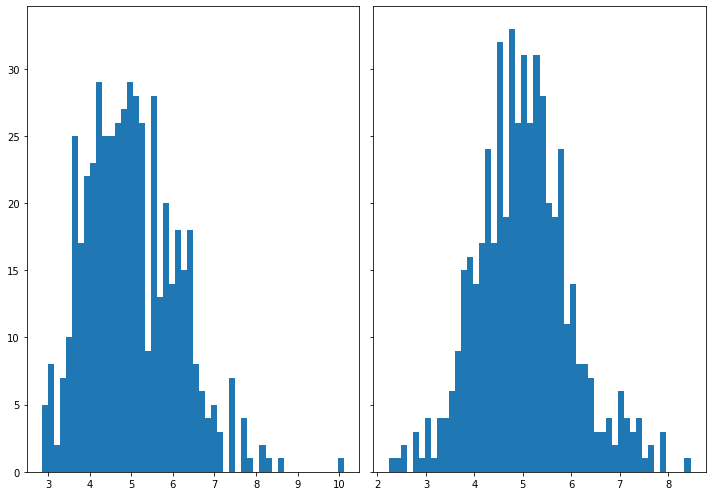

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.6941408206224435, discriminator loss: 0.6931198805570596


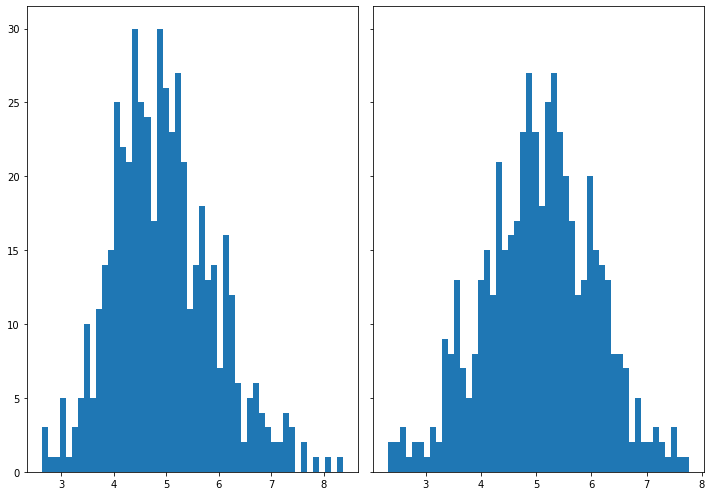

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.6935451071262364, discriminator loss: 0.6932259145975108


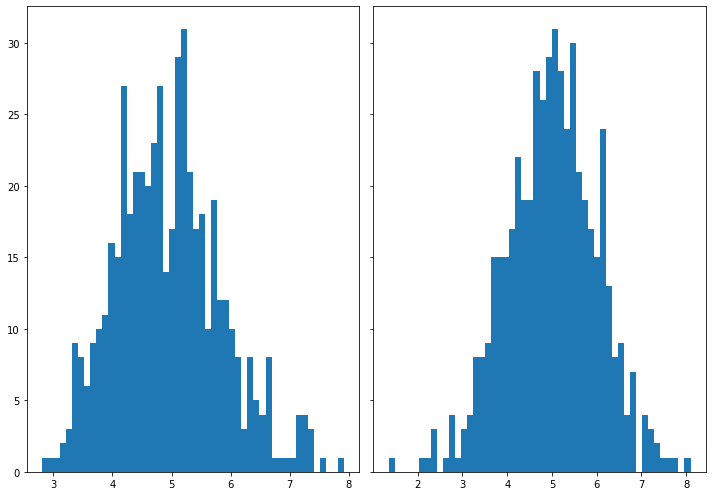

  0%|          | 0/600 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.6935326042175295, discriminator loss: 0.6931201890707002


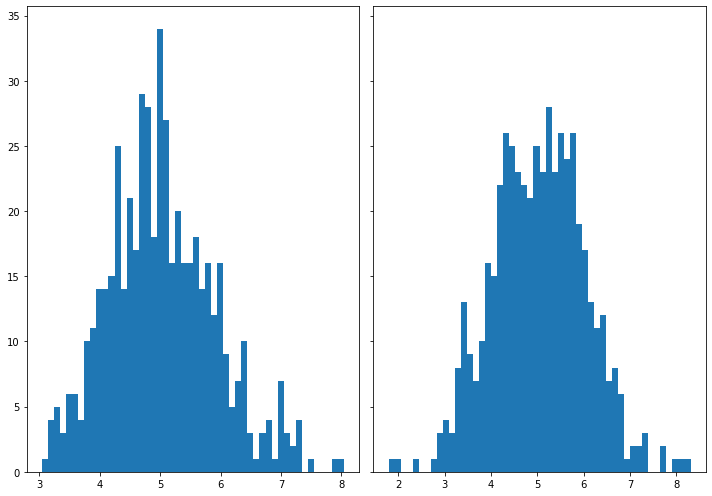

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.6938886089324957, discriminator loss: 0.6930368509888651


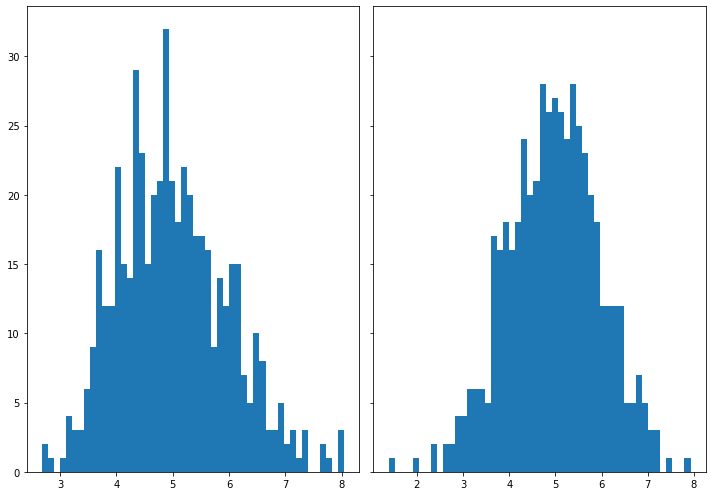

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.6932805247902857, discriminator loss: 0.6930300481915465


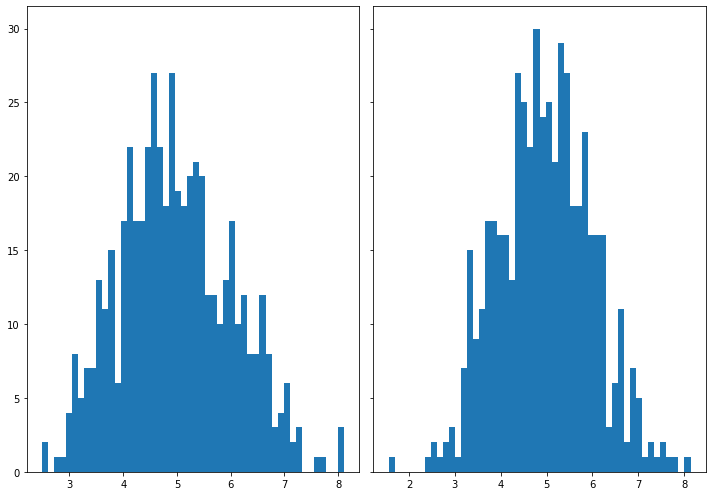

  0%|          | 0/600 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.6931599540710451, discriminator loss: 0.6930028476119043


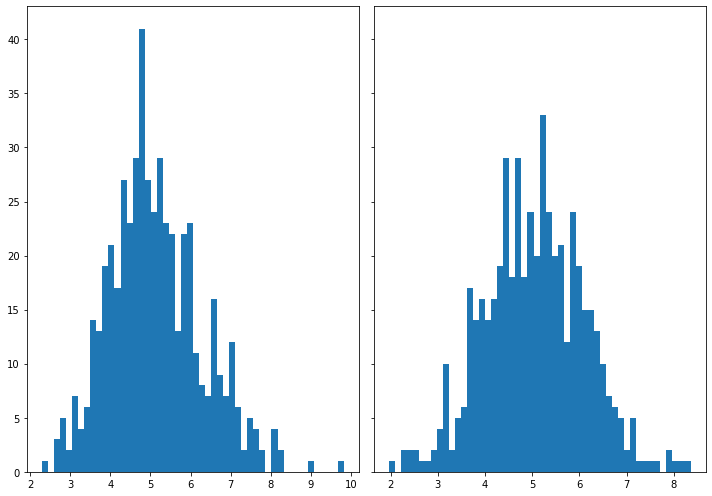

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.6934640225768092, discriminator loss: 0.6929410374760628


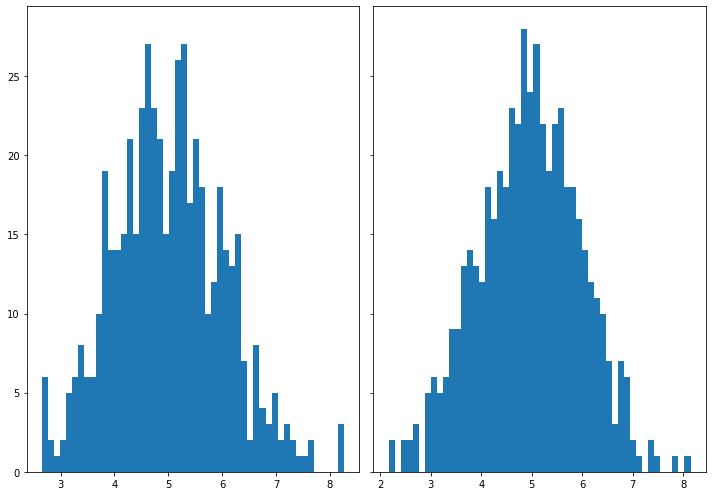

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.6935324483513835, discriminator loss: 0.692982567012309


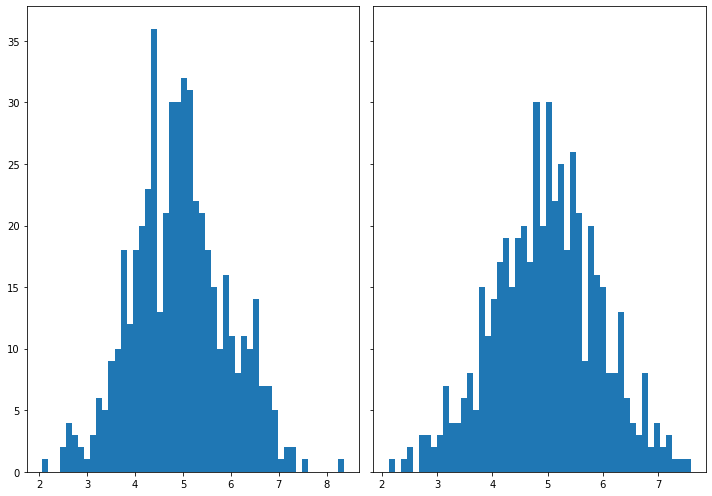

  0%|          | 0/600 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.6933243783712385, discriminator loss: 0.693219150304794


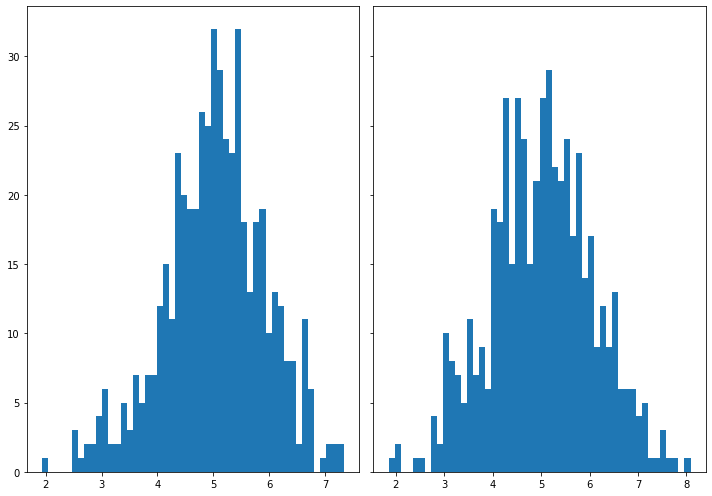

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.6930813415050513, discriminator loss: 0.69339832609892


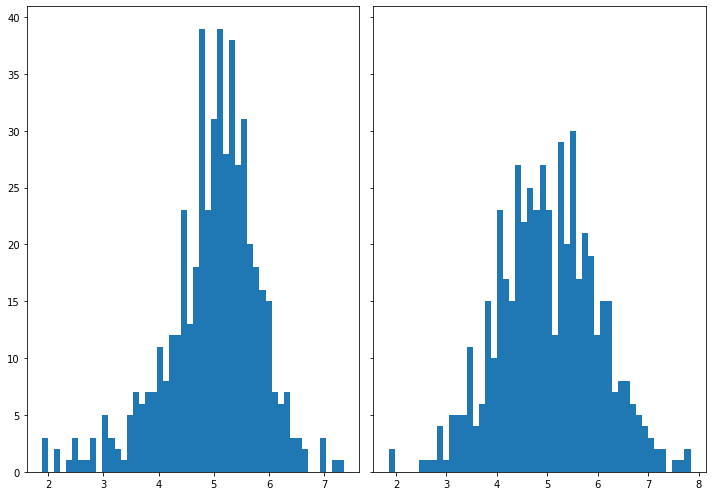

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.6931895047426234, discriminator loss: 0.6931220166683197


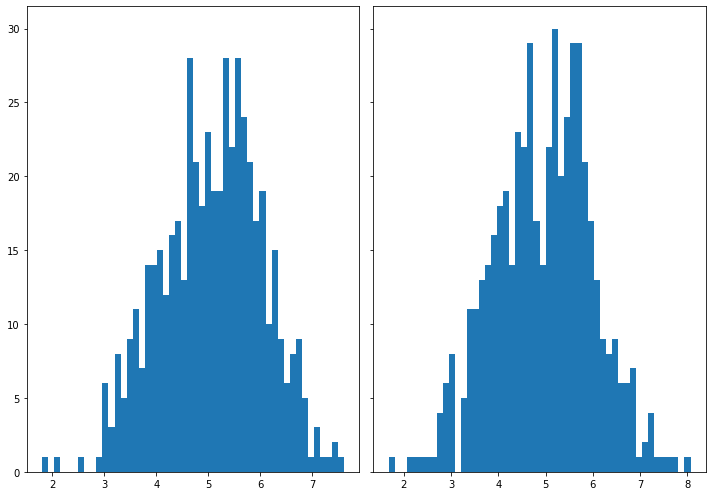

  0%|          | 0/600 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.6932766447067256, discriminator loss: 0.6931976730227476


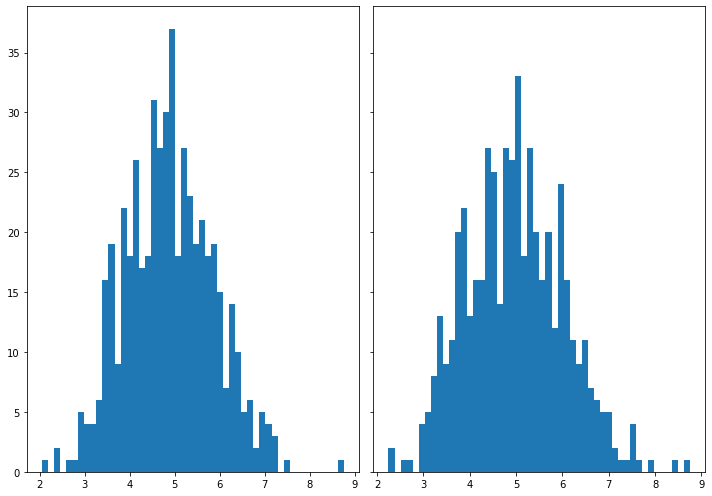

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.6931774263977993, discriminator loss: 0.6931769958138462


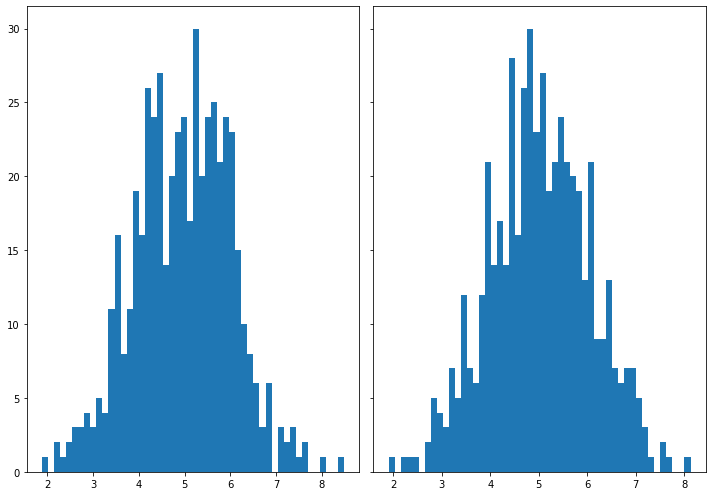

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.6933835793137548, discriminator loss: 0.6931637638211248


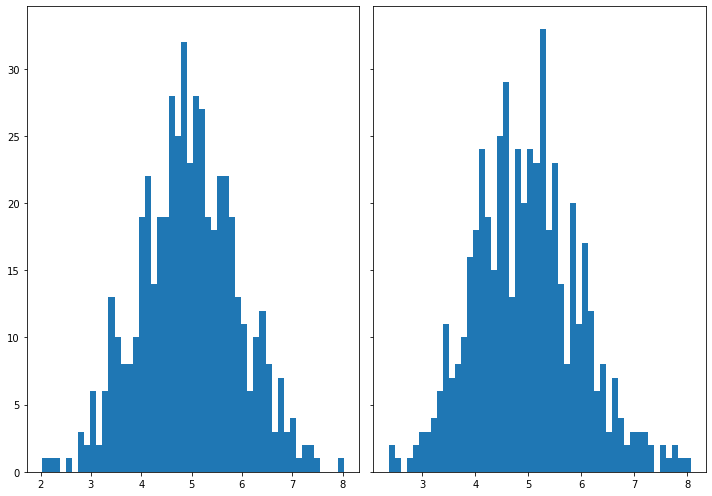

  0%|          | 0/600 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.6930867792367941, discriminator loss: 0.6931720468997957


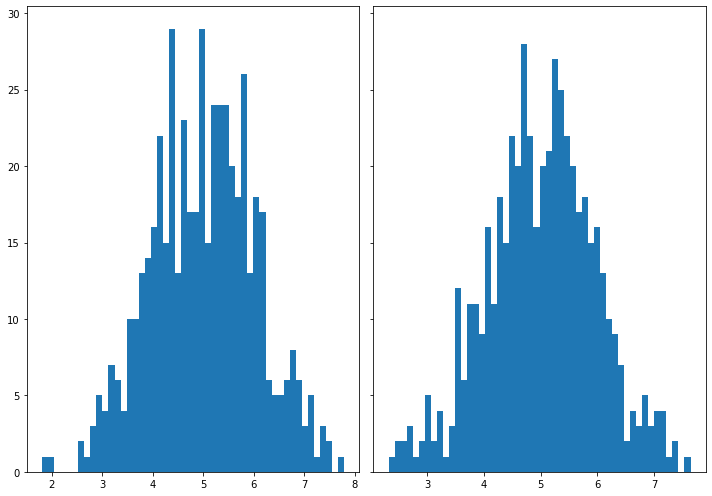

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.6933036912679669, discriminator loss: 0.6931792382597934


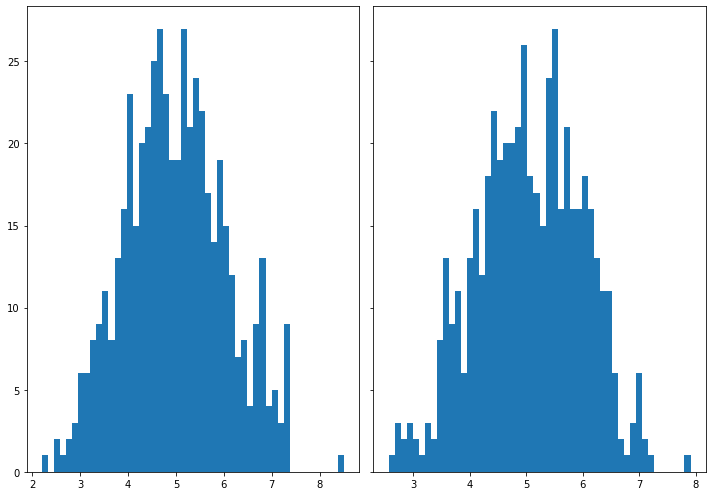

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.693322913765906, discriminator loss: 0.6931755207777032


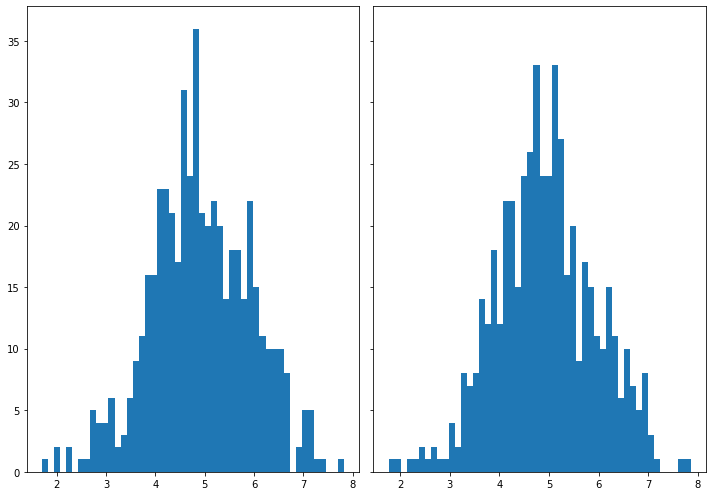

  0%|          | 0/600 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.6933445743918426, discriminator loss: 0.6931793159842502


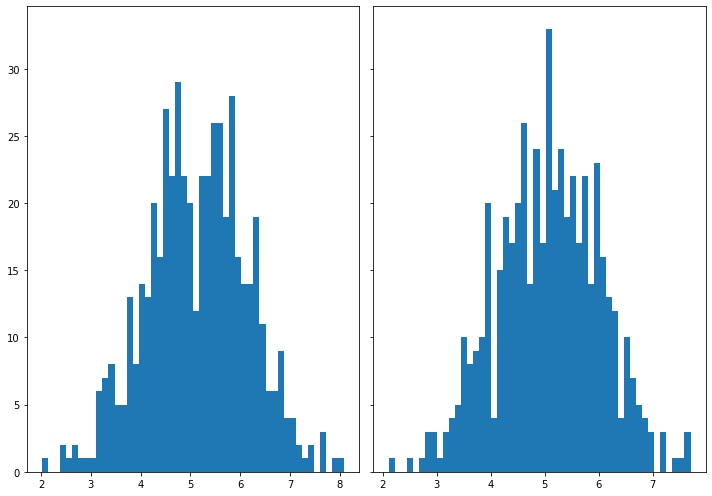

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.6932476931810373, discriminator loss: 0.693176679611206


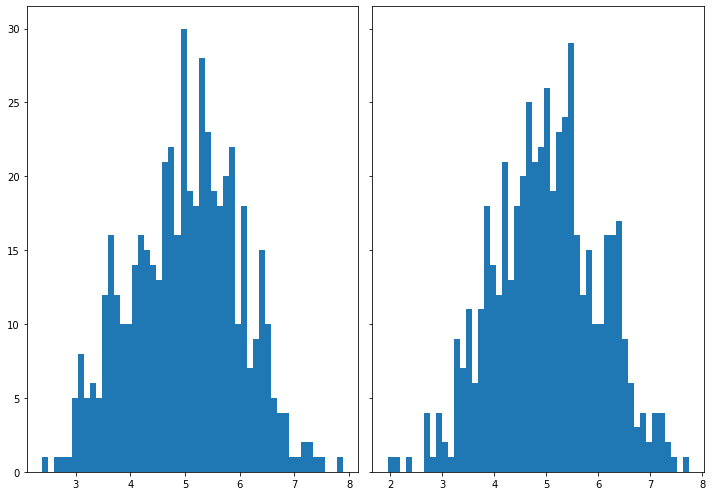

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6932566695809375, discriminator loss: 0.6931756191849713


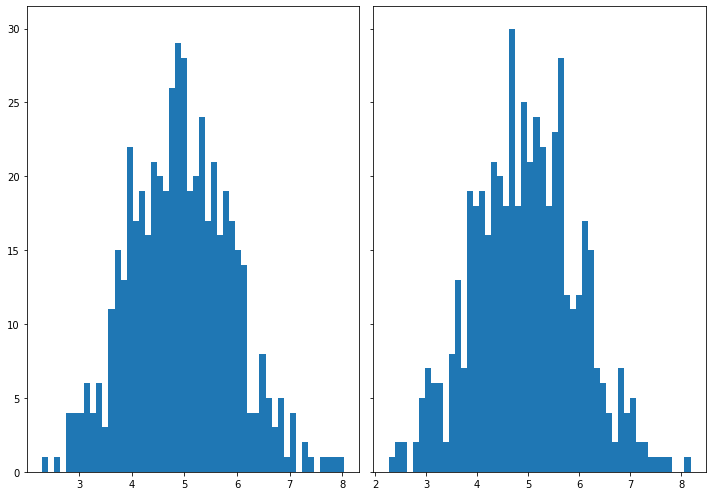

  0%|          | 0/600 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.6931849303841583, discriminator loss: 0.6931693167090419


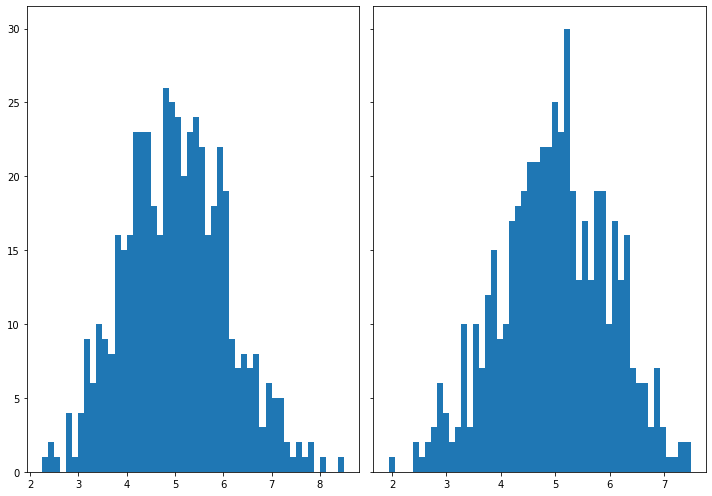

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.6931530998945239, discriminator loss: 0.6931766405105599


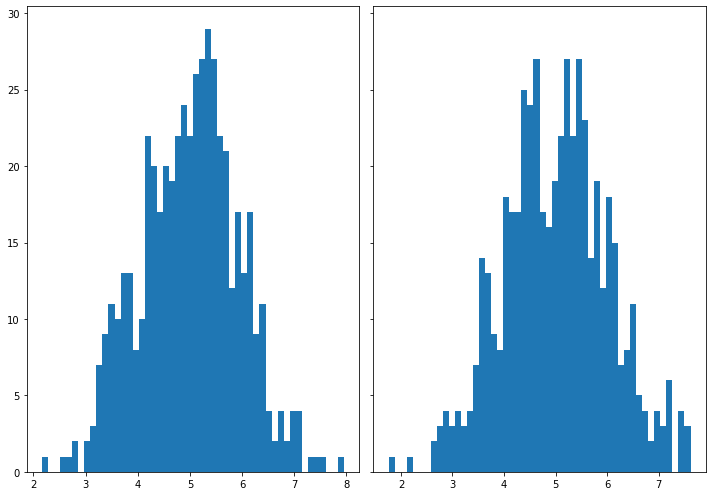

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 24000: Generator loss: 0.693340870201588, discriminator loss: 0.6931772393584247


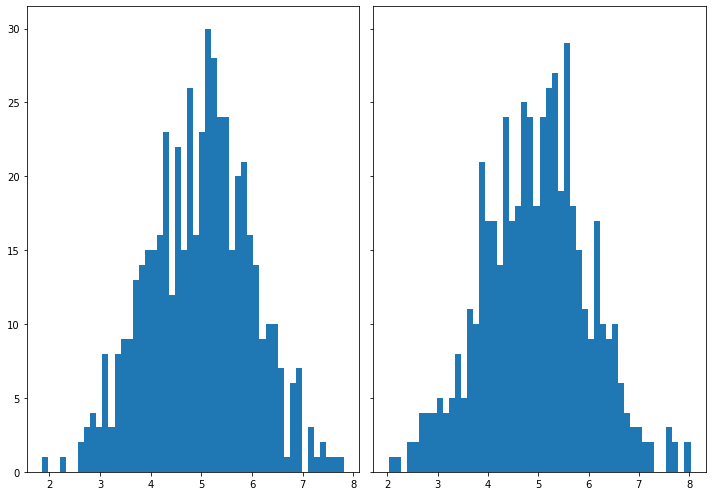

  0%|          | 0/600 [00:00<?, ?it/s]

Step 25000: Generator loss: 0.6932865508794781, discriminator loss: 0.6931711541414253


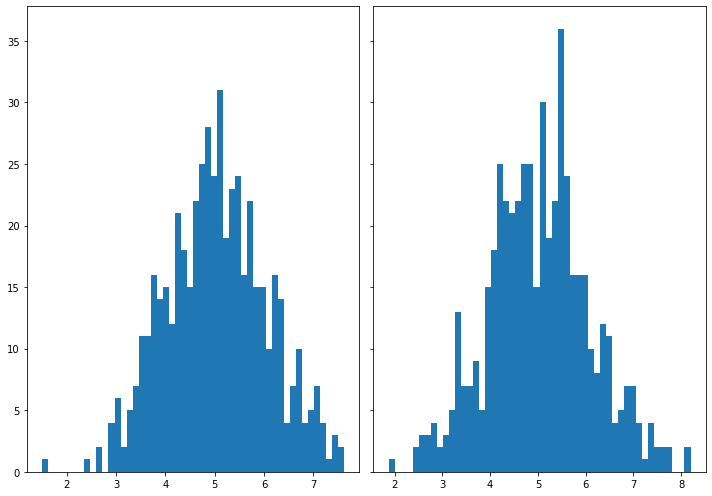

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 26000: Generator loss: 0.693248709142207, discriminator loss: 0.6931714419126508


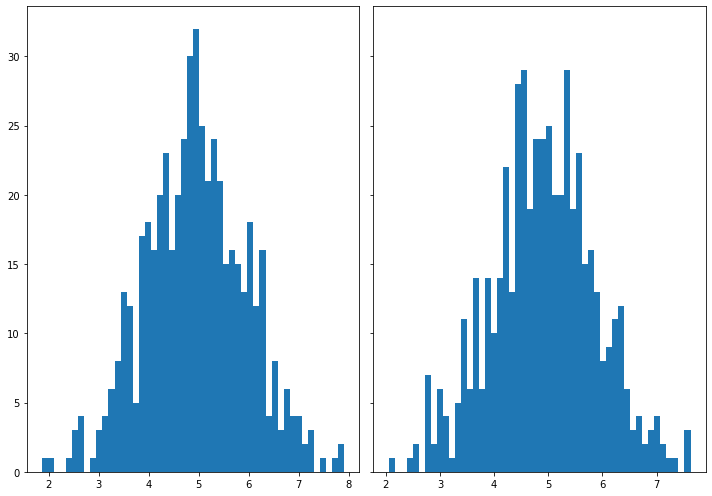

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 27000: Generator loss: 0.6932311103343979, discriminator loss: 0.6931697878837595


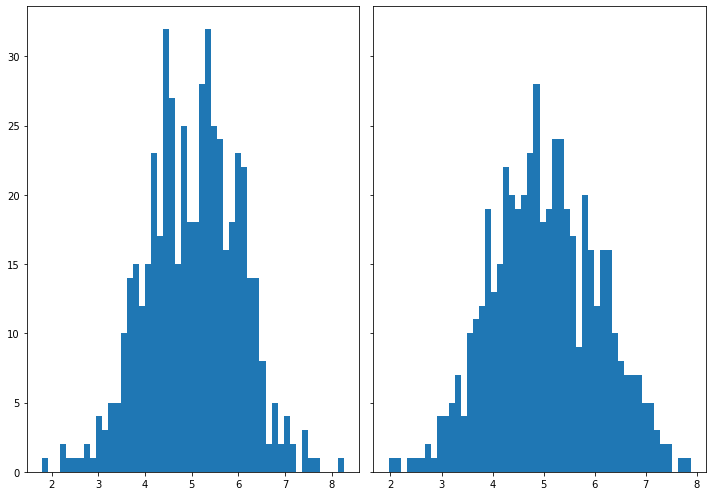

  0%|          | 0/600 [00:00<?, ?it/s]

Step 28000: Generator loss: 0.6933159039020536, discriminator loss: 0.693167687892913


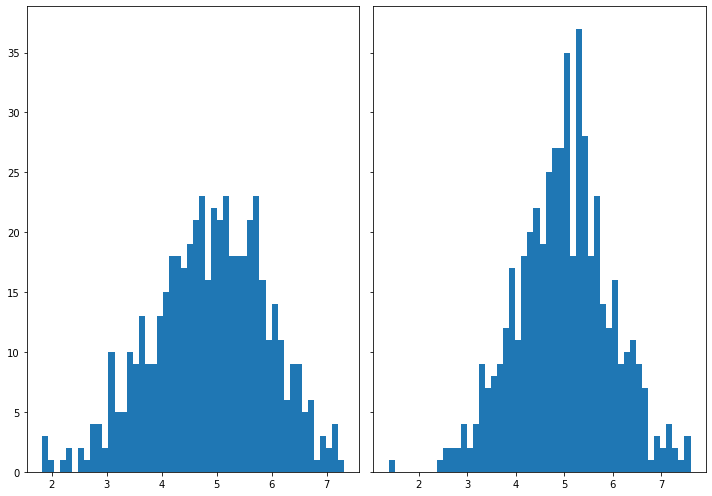

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Step 29000: Generator loss: 0.6932176529765137, discriminator loss: 0.6931674183607095


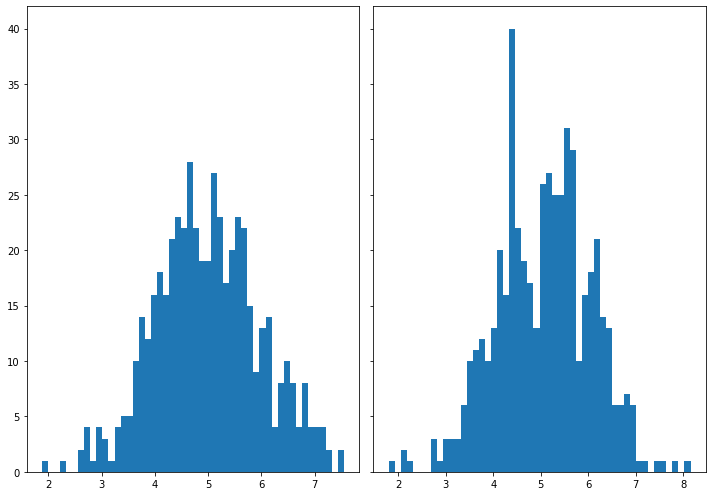

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
cur_step = 0
n_batches=600
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False

list_d = list()
list_g = list()

for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    # for real, _ in tqdm(range(n_batches)): #don't know how to fix this.
    for  _ in tqdm(range(n_batches)): 
        real=torch.randn(batch_size,output_dims,device=device)*1 +5 #not sure 
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        # real = real.view(cur_batch_size, -1).to(device)
        
        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size,z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        gen_opt.zero_grad()
        gen_loss=get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        list_d.append(mean_discriminator_loss)
        

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        list_g.append(mean_generator_loss)

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise[0])

            # Creating histogram
            n_bins=50
            fig, axs = plt.subplots(1, 2,
                                    figsize =(10, 7),
                                    tight_layout = True, sharey=True)
            axs[0].hist(fake.cpu().data.numpy(), bins = n_bins)
            axs[0].ticklabel_format(useOffset=False)#stop scientific notation 
            axs[1].hist(real.cpu().data.numpy(),bins=n_bins)
            # Show plot
            plt.show()

            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


Still have to plot loss and check that the output is reasonable 
Maybe increase the batch size ? 

Clear mode collapse here 

I think the discriminator got too strong relative to the generator. Beyond this point, the generator finds it almost impossible to fool the discriminator, hence the increase in it's loss. I'm facing a similar problem.

In [ ]:
len(list_g)

29

In [ ]:
x=list(range(len(list_g)))

In [ ]:
Loss_DF = pd.DataFrame(
    {'x': x,
     'Mean Loss G': list_g,
     'Mean Loss D': list_d
    })

In [ ]:
g=sns.lineplot(data=Loss_DF, x="x", y="Mean Loss G") #find a way to do this in one plot
g

In [ ]:
g=sns.lineplot(data=Loss_DF, x="x", y="Mean Loss D")
g

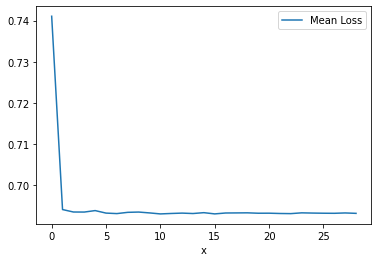

In [ ]:
# gen_list.plot(x='x',y='Mean Loss',kind='line')

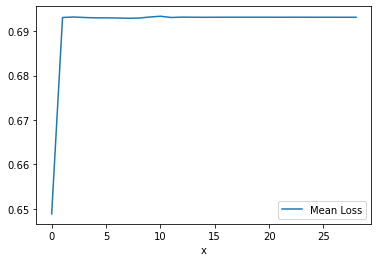

In [ ]:
# disc_list.plot(x='x',y='Mean Loss',kind='line')

In [ ]:
noise=get_noise(batch_size,z_dim,device=device)
fakes=gen(noise[0])
import scipy 
true_gaussian = torch.randn(batch_size,output_dims,device=device)*1 +5
generated_values=fake
print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian.cpu().data.numpy(), 1) , ', GAN :', scipy.stats.moment(generated_values.cpu().data.numpy(),1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian.cpu().data.numpy(), 2) , ', GAN :', scipy.stats.moment(generated_values.cpu().data.numpy(),2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian.cpu().data.numpy(), 3) , ', GAN :', scipy.stats.moment(generated_values.cpu().data.numpy(),3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian.cpu().data.numpy(), 4) , ', GAN :', scipy.stats.moment(generated_values.cpu().data.numpy(),4))

1st order moment -  True :  [0.] , GAN : [0.]
2nd order moment -  True :  [1.0083423] , GAN : [1.0242128]
3rd order moment -  True :  [-0.03685602] , GAN : [0.12917238]
4th order moment -  True :  [2.9804254] , GAN : [2.8987832]


### Evaluation 
KSD, MAE, MSE 

Doesn't capture tails well. (Particularly 3rd Moment)

## WGAN with Gradient Penalty / Weight Clipping
The WGAN makes a modification to the vanilla GAN by replacing the Jensen-Shannon divergence loss function with the Wasserstein distance (EM distance).

Applying a gradient penalty term to WGAN can prevent gradient vanishing and the exploding problem.

Maybe try implement Weight Penalty instead of Weight Clipping.

Here the discriminator is now called a critic as it is no longer bounded by 0-1 it can give any real value. 

W-Loss: Simple expression that computes the difference between the expected value of the critics output for the real examples and the prediction on the fake examples. The generator tries to minimize this but the critic wants to maximize this. For GANs, 1-Lipschitz Continuity must be enforced.

Critic needs to be 1-L Continous: Norm of graident should be at most 1 at every point. This measn that the W-Loss function is continous and differentiable and maintains some stability during training. If the critic's neural network is 1-L continous then it ensures W-loss is approximating EMD validly.

This Critic 1-L enforcement can be doen via weight clipping or gradient penalty. 

Weight Clipping: This clips the weight's of the critic after gradient decent so that it limits the learning ability of the critic - this might limit the critic too much or too little (Lots of hyper-parameter tuning). 

Gradient Penalty: Softer way to enforce the critic to be 1-L continous. This adds a regularisation term to the loss function so it penalizes the critic when the gradient norm is > 1. In this method you would not strictly enforce 1-L continuity as you often use an epsilon which allows you to interpolate a output between a real and fake image (often just linear interpolation weighted by epsilon) and then penalise the critic using the gradient norm of the interpolated output. 


### Weight Clipping 
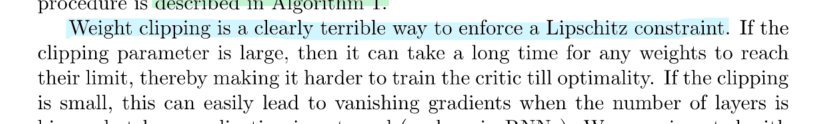
So should I even bother ?

###Gradient Penalty
Using the same architecture as before 


In [ ]:
def get_crit_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [ ]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        sample_dim: the dimension of the sample, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, sample_dim=1, hidden_dim=128):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            get_crit_block(sample_dim, hidden_dim * 4),
            get_crit_block(hidden_dim * 4, hidden_dim * 2),
            get_crit_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, sample):
        '''
        Function for completing a forward pass of the discriminator: Given an sample tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            sample: a flattened image tensor with dimension (im_dim)
        '''
        return self.crit(sample)
    
    # Needed for grading
    def get_crit(self):
        '''
        Returns:
            the sequential model
        '''
        return self.crit

#### Training Initializations
n_epochs: the number of times you iterate through the entire dataset when training
z_dim: the dimension of the noise vector
display_step: how often to display/visualize the images
batch_size: the number of images per forward/backward pass
lr: the learning rate
beta_1, beta_2: the momentum terms
c_lambda: weight of the gradient penalty
crit_repeats: number of times to update the critic per generator update
device: the device type

They said they itterated 1e6 times with 1e5 samples ? Do they mean they had 1e6 epochs ??

In [ ]:
n_epochs = 100
z_dim = 10
hidden_dims=128
output_dims=1
display_step = 200
batch_size = 64
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'
n_batches=600

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,)),
# ])

# dataloader = DataLoader(
#     MNIST('.', download=False, transform=transform),
#     batch_size=batch_size,
#     shuffle=True)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

### Gradient Penalty Implementation
1.   Compute the gradient with respect to the images. 
2.   Compute the gradient penalty given the gradient.

The gradient is computed by first creating a mixed sample. This is done by weighing the fake and real sample using epsilon and then adding them together. Once you have the intermediate sample, you can get the critic's output on the image. Finally, you compute the gradient of the critic score's on the mixed samples (output) with respect to the respective sampels of the mixed images (input).

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real samples
        fake: a batch of fake samples
        epsilon: a vector of the uniformly random proportions of real/fake per mixed sample
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_sample = real * epsilon + fake * (1 - epsilon)
    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_sample)
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_sample,
        outputs=mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [ ]:
# UNIT TEST
def test_get_gradient(sample_shape):
    real = torch.randn(*sample_shape, device=device) + 1
    fake = torch.randn(*sample_shape, device=device) - 1
    epsilon_shape = [1 for _ in sample_shape]
    epsilon_shape[0] = sample_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == sample_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((10, 1))
print("Success!")

Success!


Compute the gradient penalty given the gradient. 
Calculate the magnitude of each image's gradient (also called the norm). Then, you calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.

In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of sample gradients, you calculate the magnitude of each sample's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed sample
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean(pow(gradient_norm - torch.ones_like(gradient_norm),2))
    return penalty

In [ ]:
def test_gradient_penalty(sample_shape):
    bad_gradient = torch.zeros(*sample_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    sample_size = torch.prod(torch.Tensor(sample_shape[1:]))
    good_gradient = torch.ones(*sample_shape) / torch.sqrt(sample_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(sample_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((10, 1))
print("Success!")

Success!


### Losses
For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake samples. The argument has the scores for all fake images in the batch, but you will use the mean of them.

In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss

For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real samples and the predictions on the fake samples while also adding a gradient penalty. The gradient penalty is weighed according to lambda. The arguments are the scores for all the samples in the batch, and you will use the mean of them.

In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = torch.mean(crit_fake_pred)-torch.mean(crit_real_pred)+c_lambda*gp
    return crit_loss

## Training 
Even on GPU, the training will run more slowly than previous labs because the gradient penalty requires you to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as you can while on GPU.

One important difference from earlier versions is that you will update the critic multiple times every time you update the generator - This helps prevent the generator from overpowering the critic. Sometimes, you might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss you're using).

WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just increases stability and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN from last assignment, though it will generally run a bit slower. You should also be able to train your model for more epochs without it collapsing.

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 0, step 200: Generator loss: 1.5790294997626915, critic loss: -0.3582756158207773


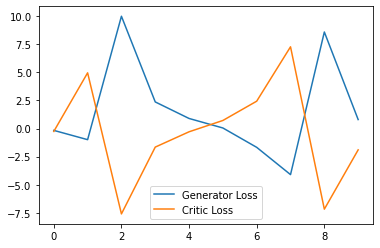

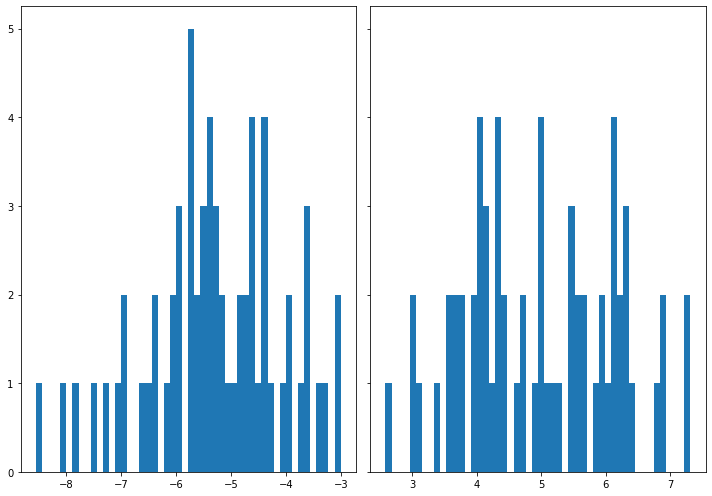

Epoch 0, step 400: Generator loss: -0.11543130828998983, critic loss: 0.059572852348792116


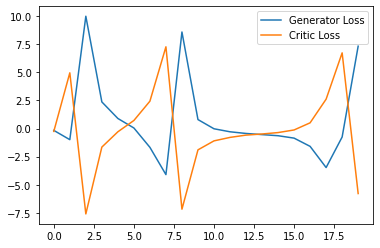

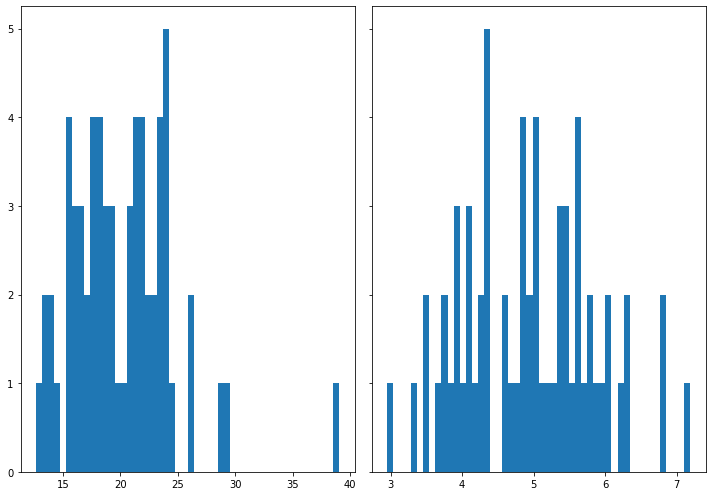

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1, step 600: Generator loss: 0.734975971605163, critic loss: 0.31755309677030924


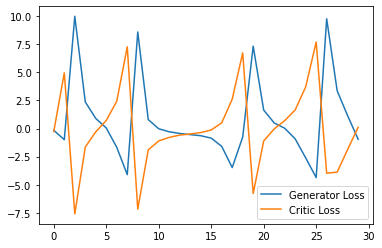

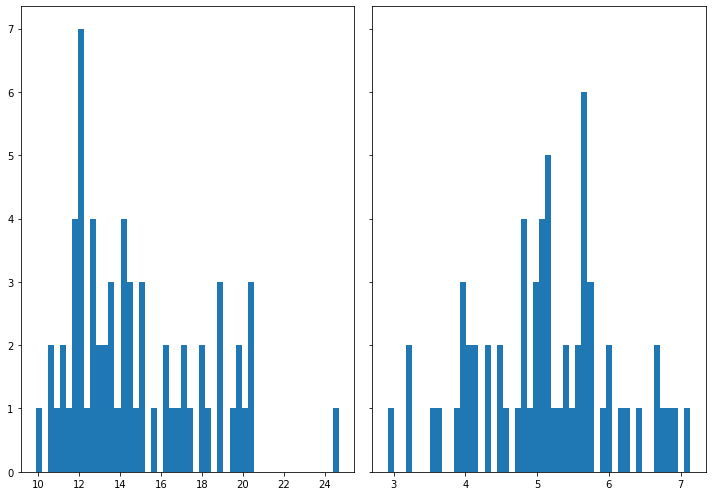

Epoch 1, step 800: Generator loss: -0.6115211598295719, critic loss: 2.4053545153830207


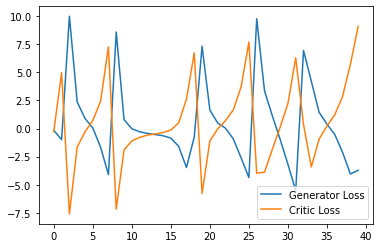

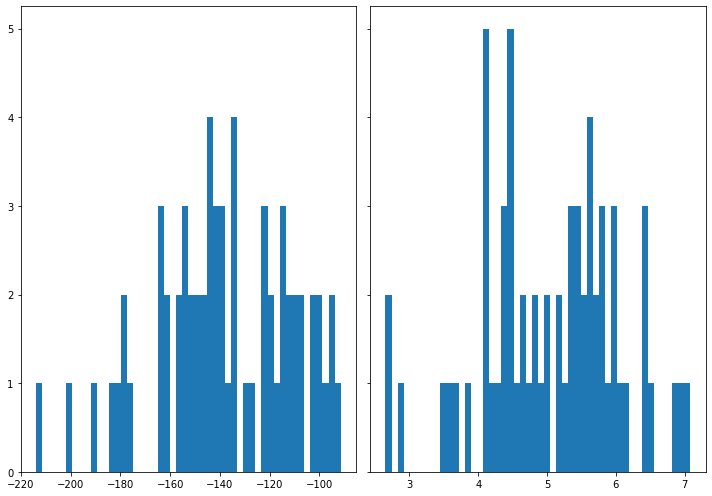

Epoch 1, step 1000: Generator loss: 1.8454761020326986, critic loss: -1.043506650349125


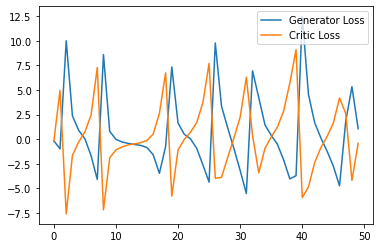

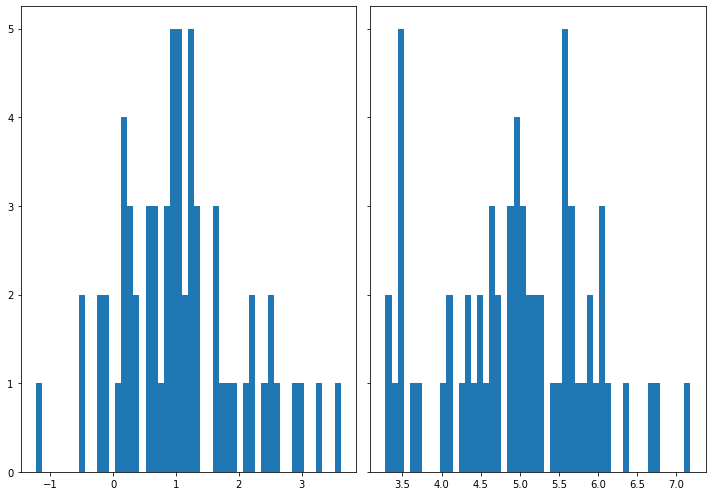

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 2, step 1200: Generator loss: 0.9354067015647888, critic loss: 0.48812245777249336


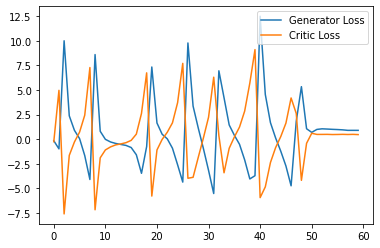

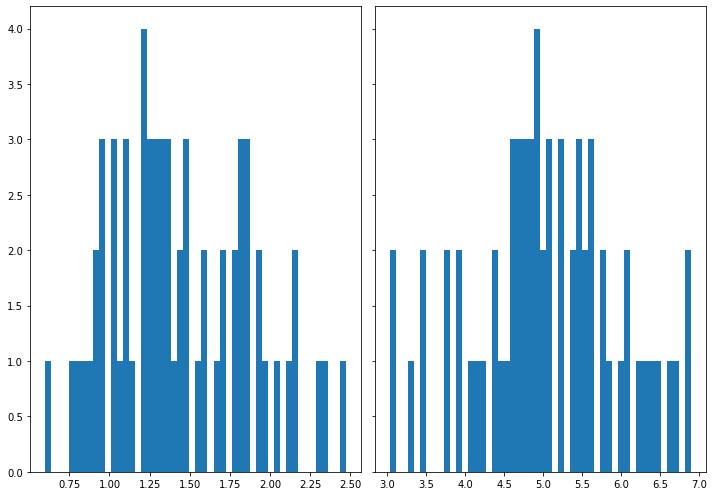

Epoch 2, step 1400: Generator loss: 1.0813885569572448, critic loss: 0.44970605760812743


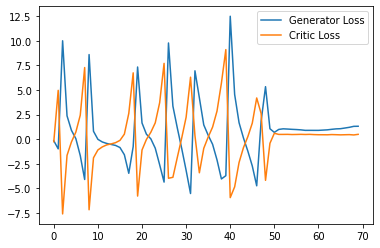

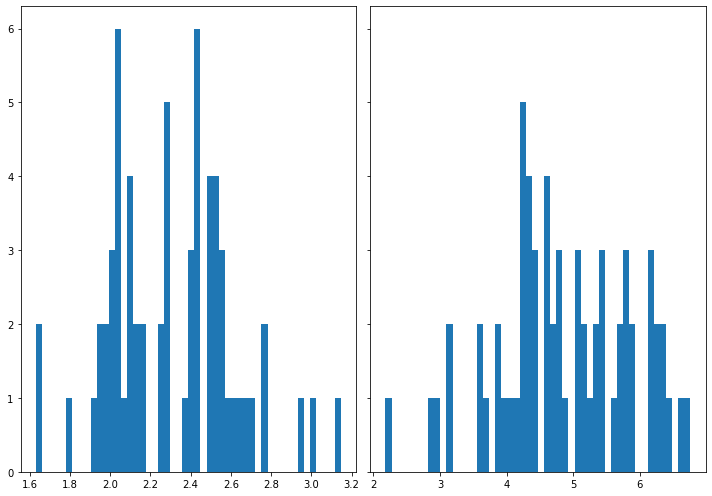

Epoch 2, step 1600: Generator loss: 0.6786586069315672, critic loss: 0.5486544672548772


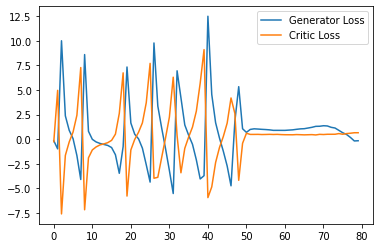

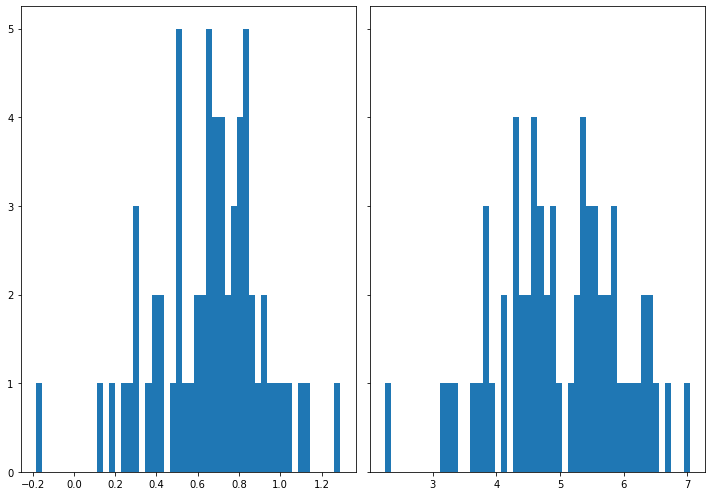

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 3, step 1800: Generator loss: -0.21312995210289956, critic loss: 0.5385377545356752


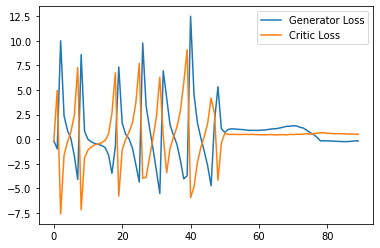

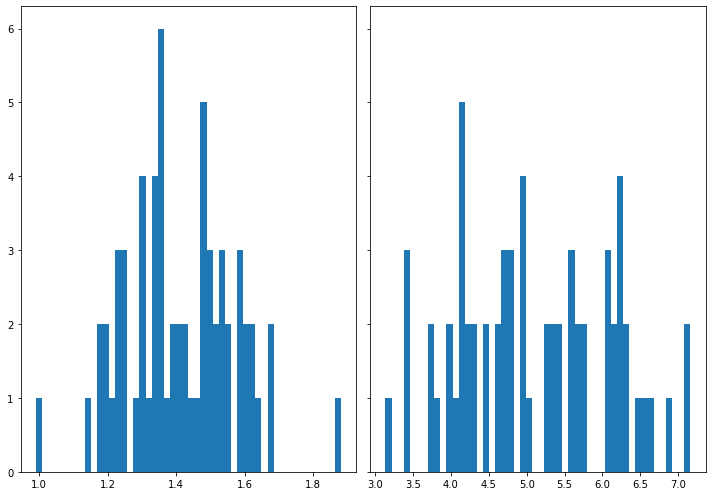

Epoch 3, step 2000: Generator loss: -0.0899360156711191, critic loss: 0.5202405498921873


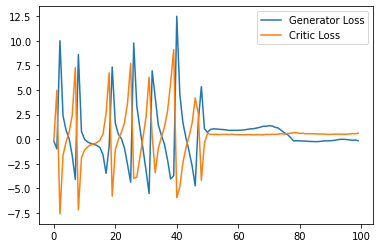

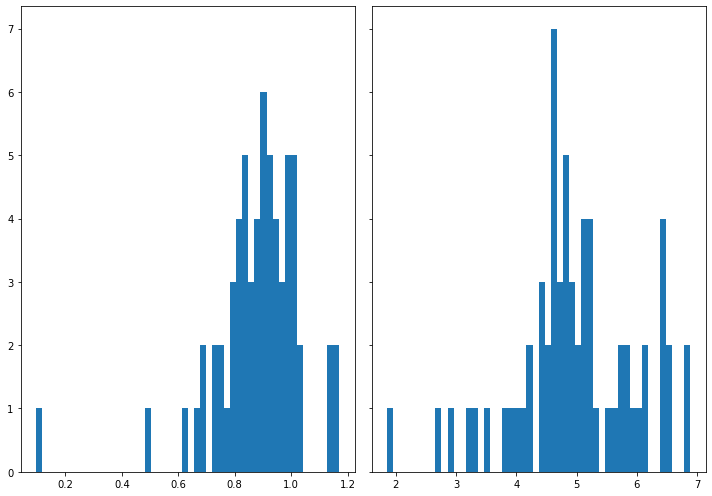

Epoch 3, step 2200: Generator loss: -0.5026881773024797, critic loss: 0.5385184070169927


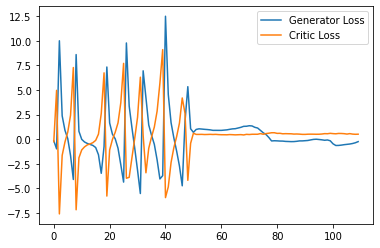

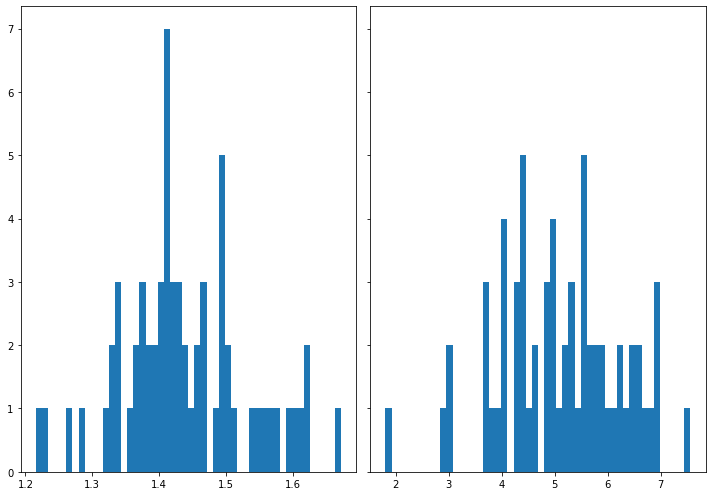

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 4, step 2400: Generator loss: 0.08752573413192294, critic loss: 0.4644990517795084


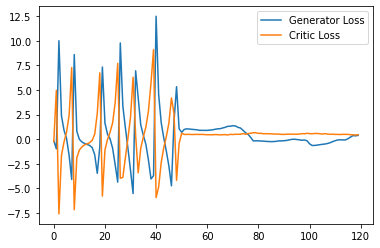

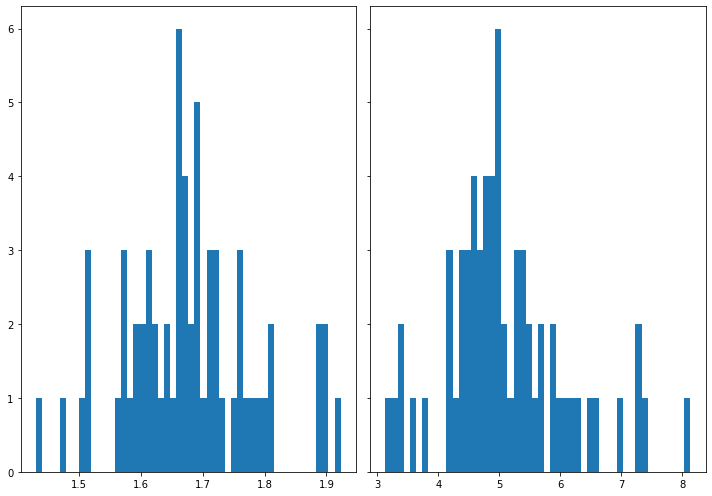

Epoch 4, step 2600: Generator loss: 0.11783632301841862, critic loss: 0.5027978682667016


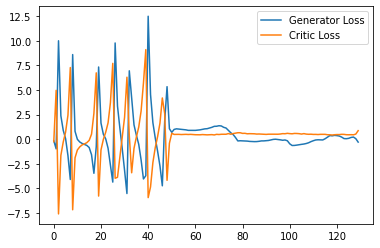

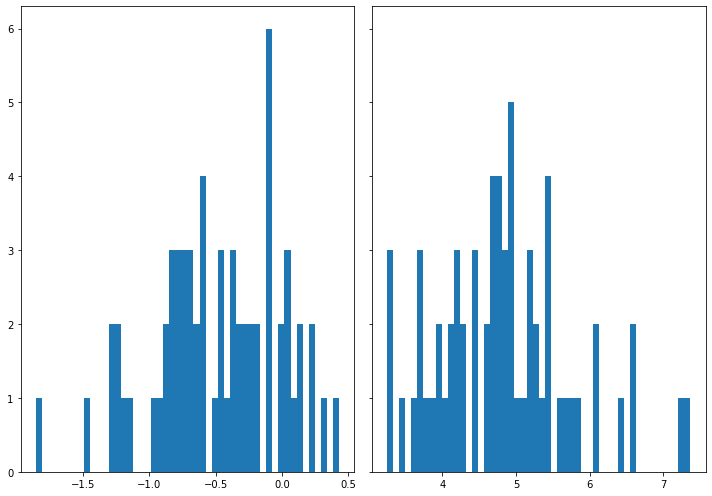

Epoch 4, step 2800: Generator loss: 0.21713368411408737, critic loss: 0.5910454033389689


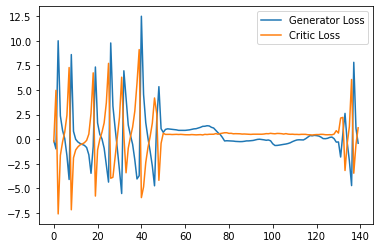

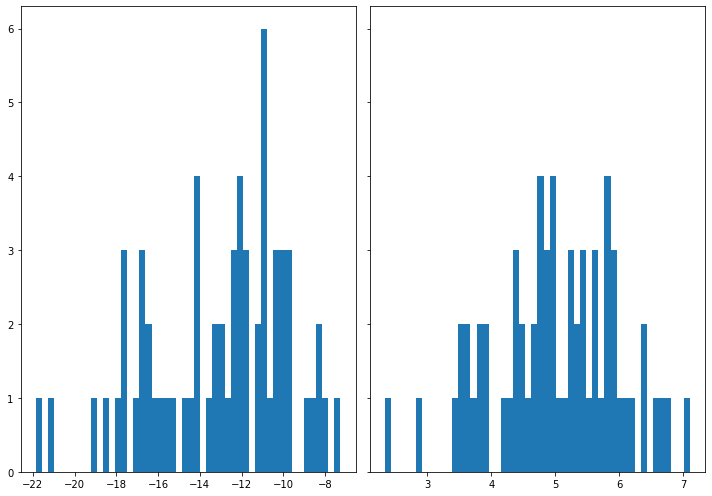

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 5, step 3000: Generator loss: 0.4301056328415871, critic loss: 0.7459175126603809


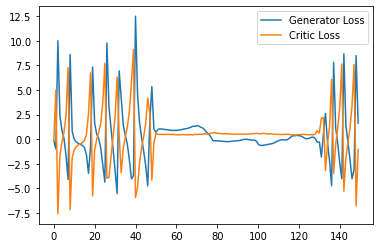

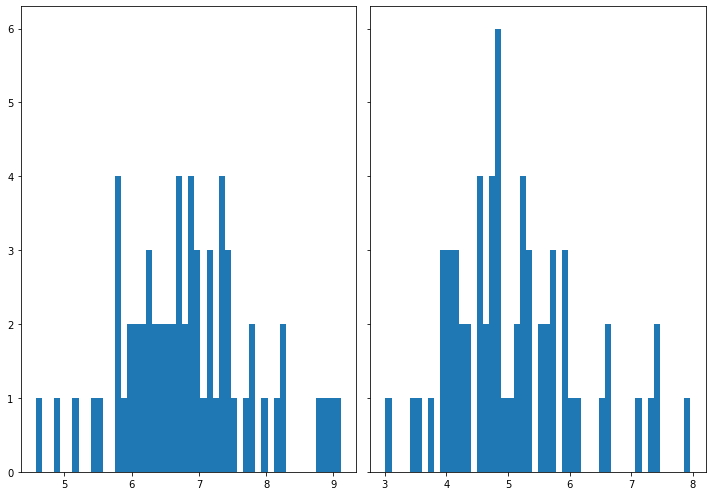

Epoch 5, step 3200: Generator loss: 0.15942979413084685, critic loss: 0.9208622653440104


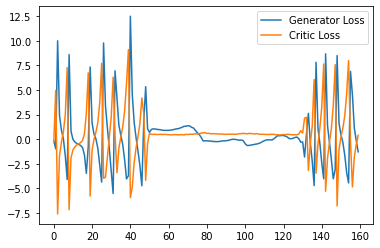

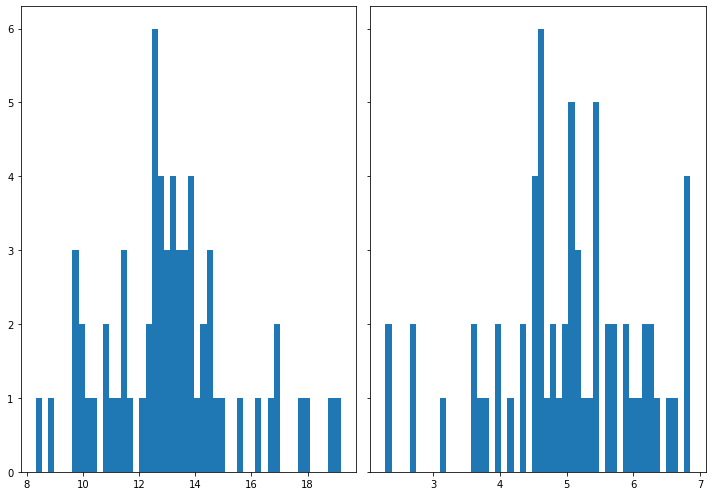

Epoch 5, step 3400: Generator loss: -0.3279272886319086, critic loss: 1.2268495240211497


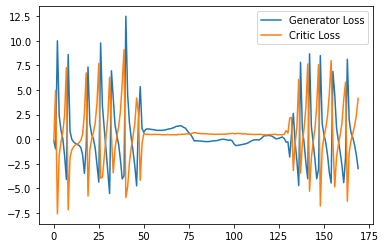

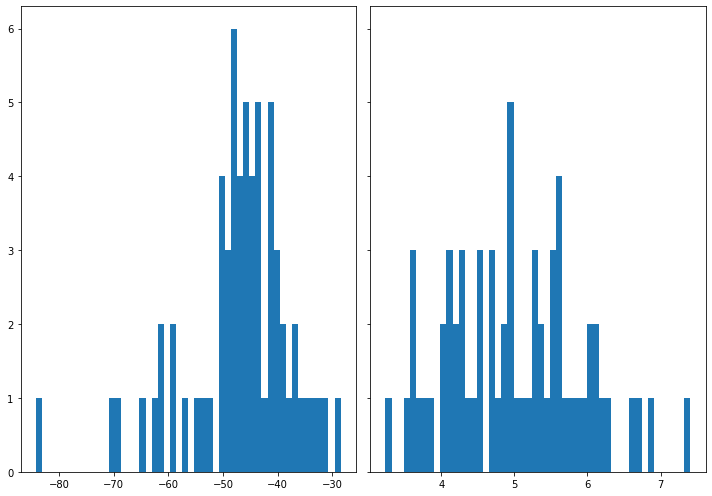

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 6, step 3600: Generator loss: 0.9321611449867487, critic loss: 0.3101711812895953


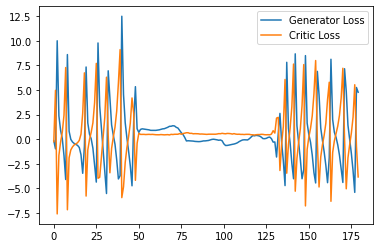

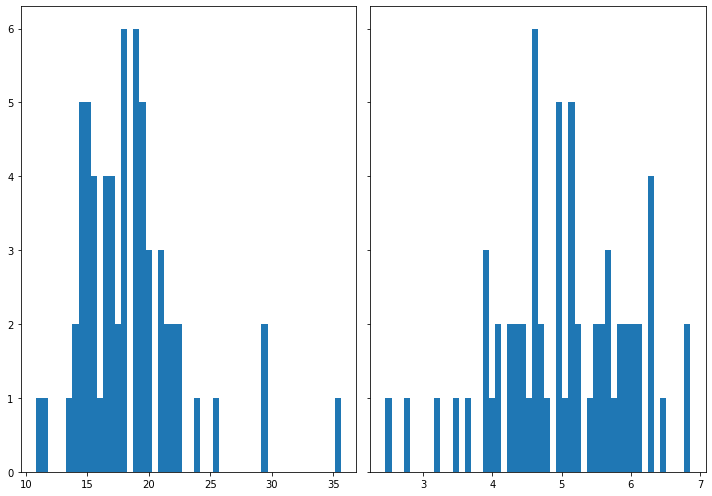

Epoch 6, step 3800: Generator loss: 0.6371807219088077, critic loss: 0.5857819491513654


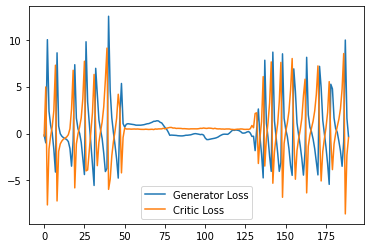

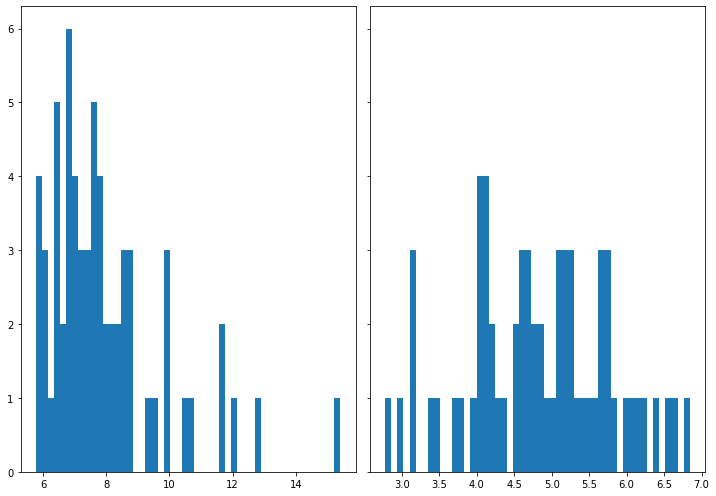

Epoch 6, step 4000: Generator loss: -0.29409187773242595, critic loss: 1.7061437219232318


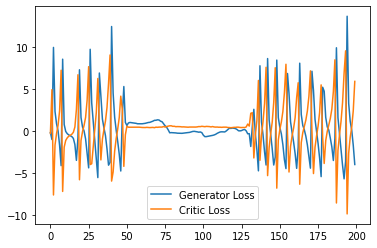

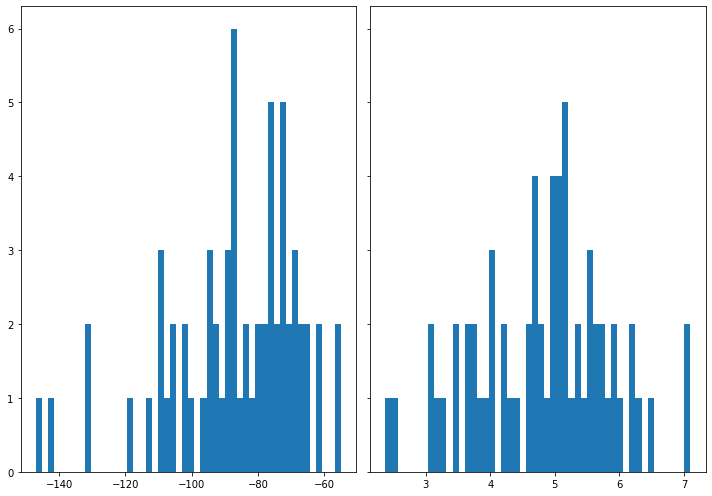

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 7, step 4200: Generator loss: 1.5619699642900378, critic loss: 0.25909448542748564


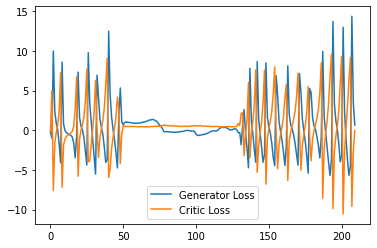

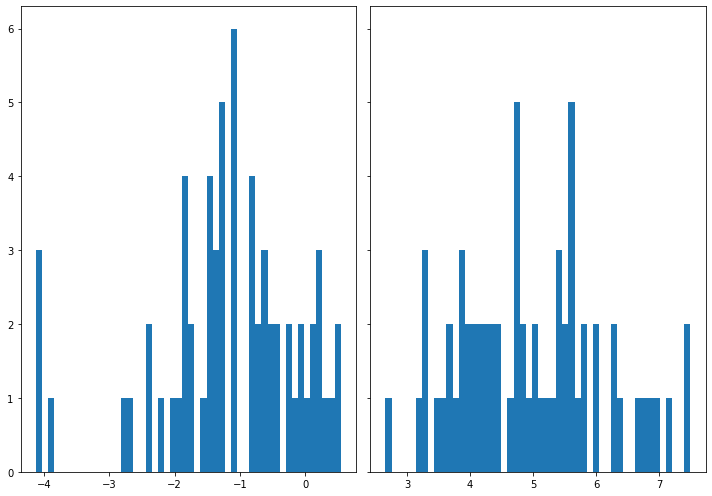

Epoch 7, step 4400: Generator loss: -0.04803153546527028, critic loss: 1.7625608182614667


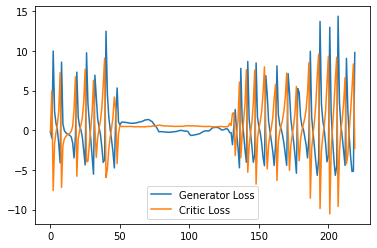

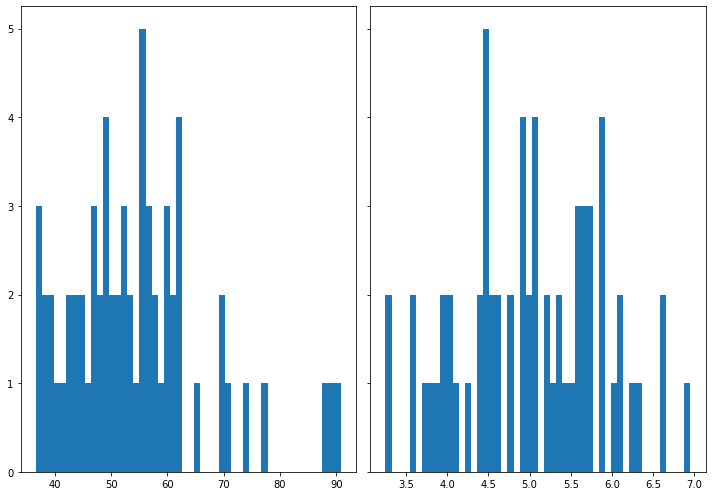

Epoch 7, step 4600: Generator loss: 0.38855917669367046, critic loss: 0.8597677367058354


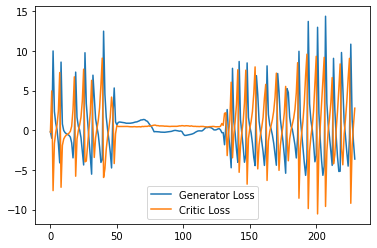

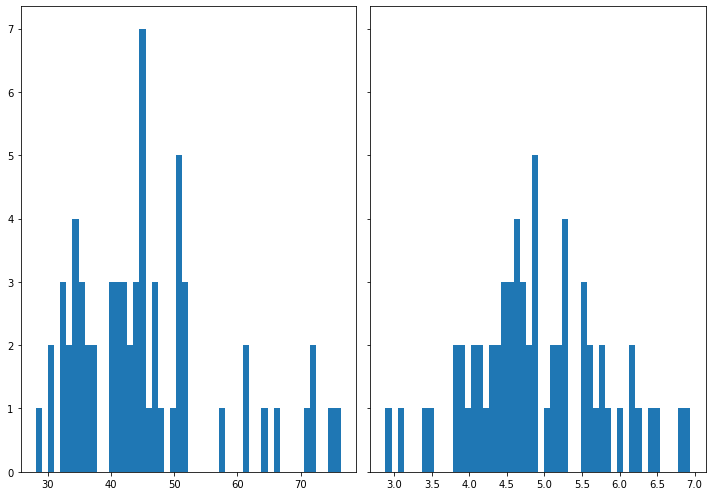

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 8, step 4800: Generator loss: -0.433744023963809, critic loss: 2.8409368859520474


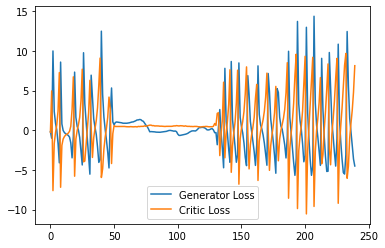

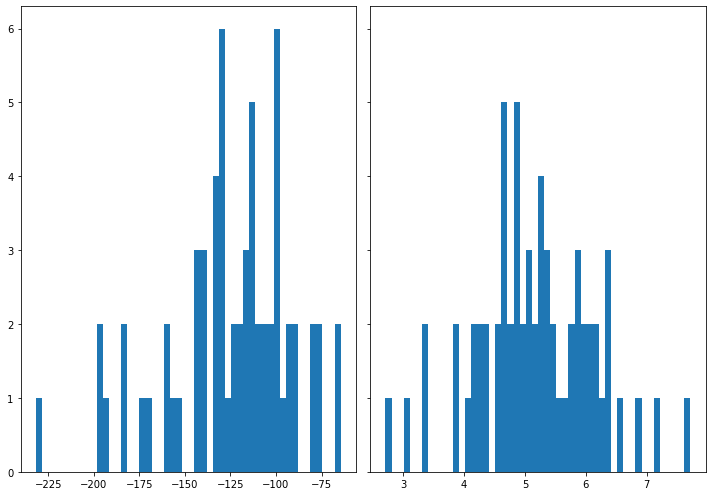

Epoch 8, step 5000: Generator loss: 1.5525514428596943, critic loss: 0.1626624683281408


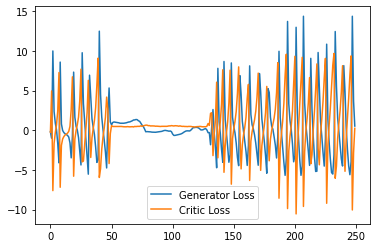

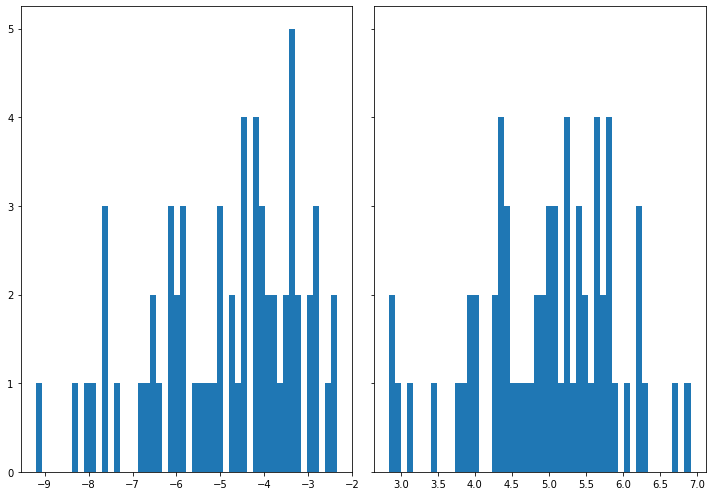

Epoch 8, step 5200: Generator loss: -0.8426229449361563, critic loss: 3.027801414898598


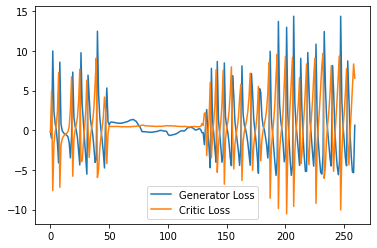

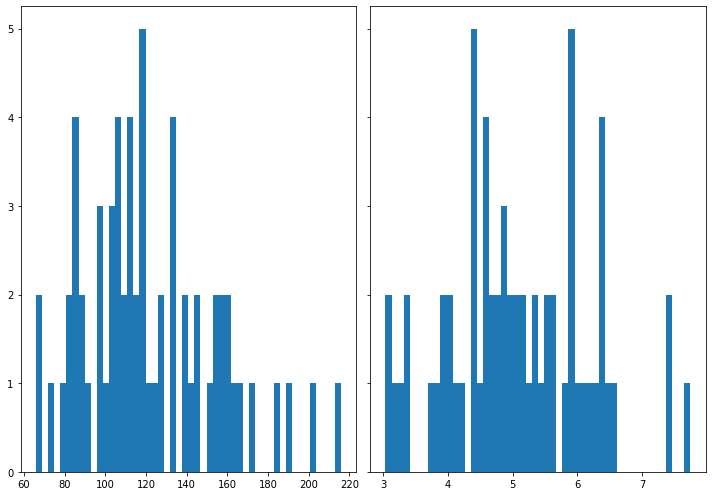

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 9, step 5400: Generator loss: 2.784241807460785, critic loss: -0.7346162361684249


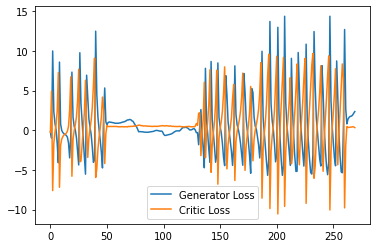

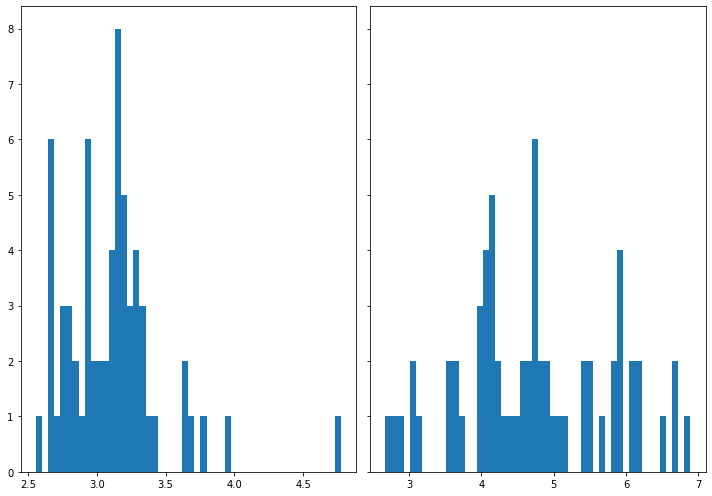

Epoch 9, step 5600: Generator loss: 1.9931085243821145, critic loss: 0.5710537419915199


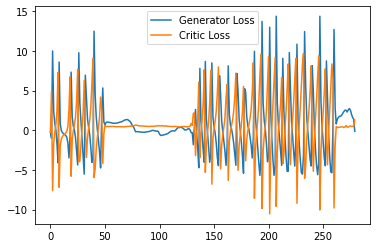

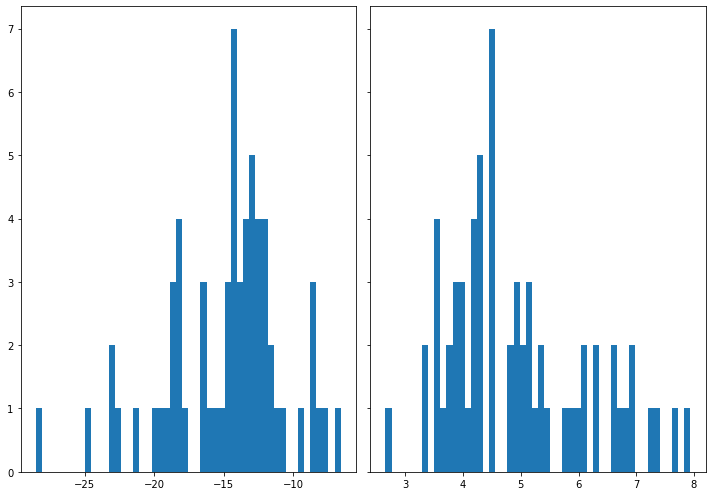

Epoch 9, step 5800: Generator loss: 0.7965331276319921, critic loss: 0.6986225948315115


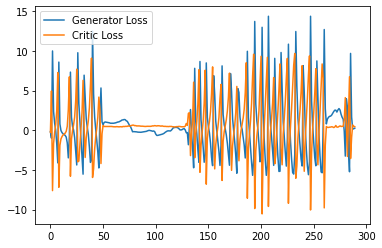

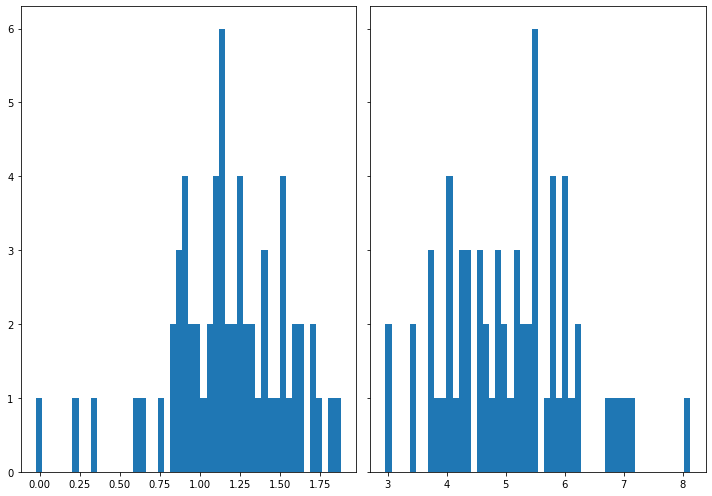

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 10, step 6000: Generator loss: 0.13481291580945254, critic loss: 0.5394627417027955


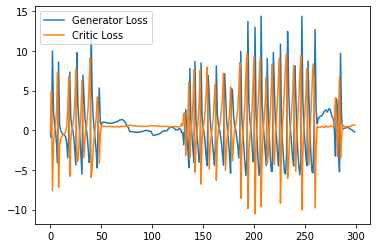

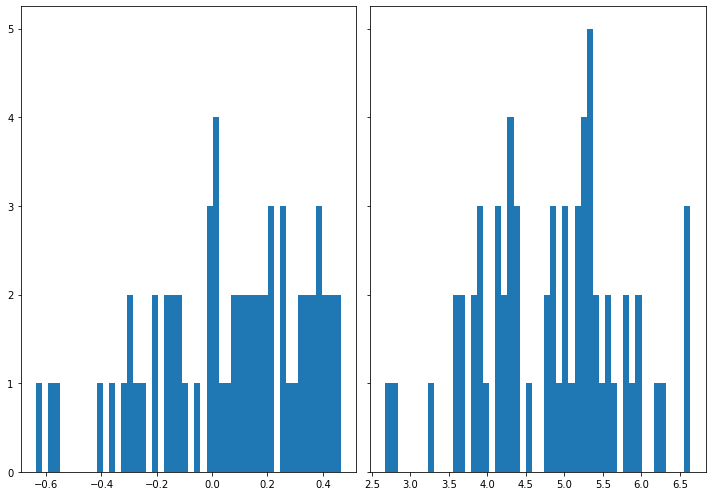

Epoch 10, step 6200: Generator loss: -0.18969797525554896, critic loss: 0.5213179566264152


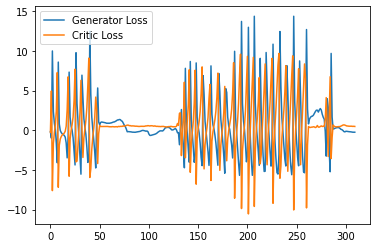

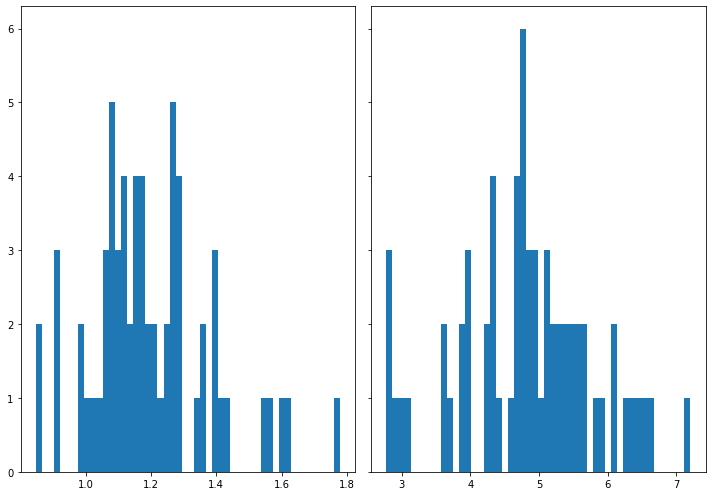

Epoch 10, step 6400: Generator loss: -0.20207153230905534, critic loss: 0.4961003684699535


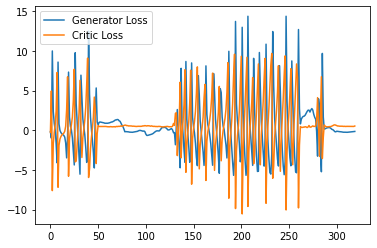

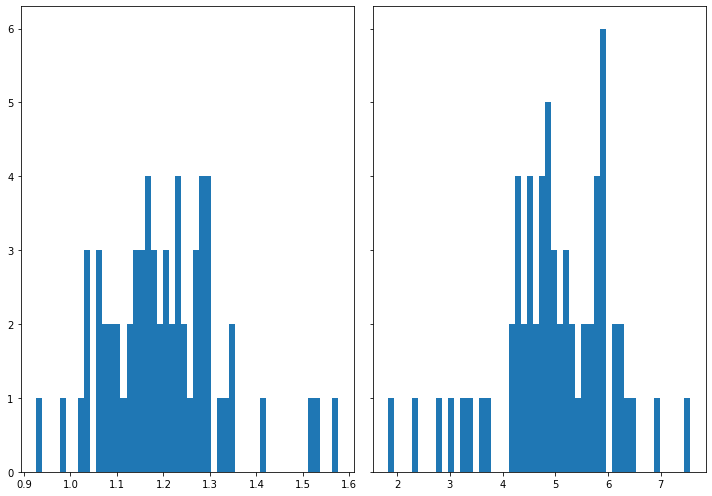

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 11, step 6600: Generator loss: -0.08099382009153487, critic loss: 0.48666256427764915


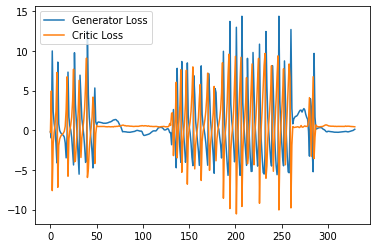

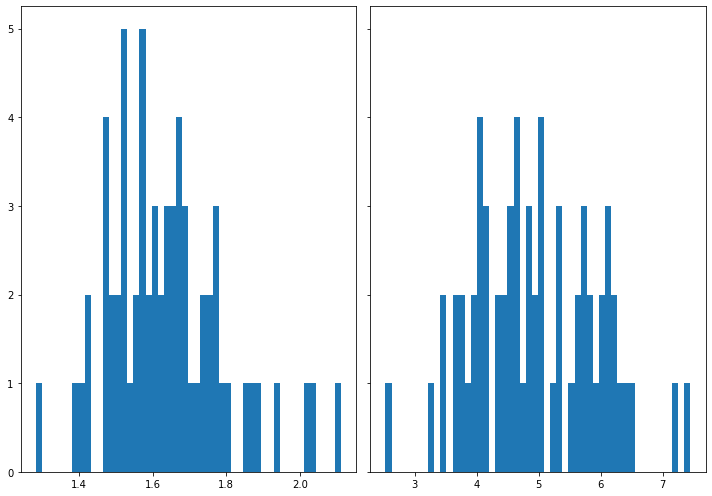

Epoch 11, step 6800: Generator loss: 0.3693687615543604, critic loss: 0.4440042346119883


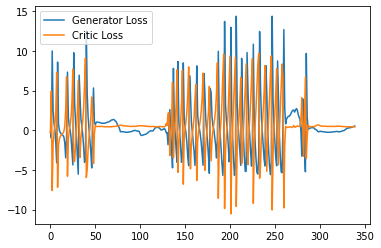

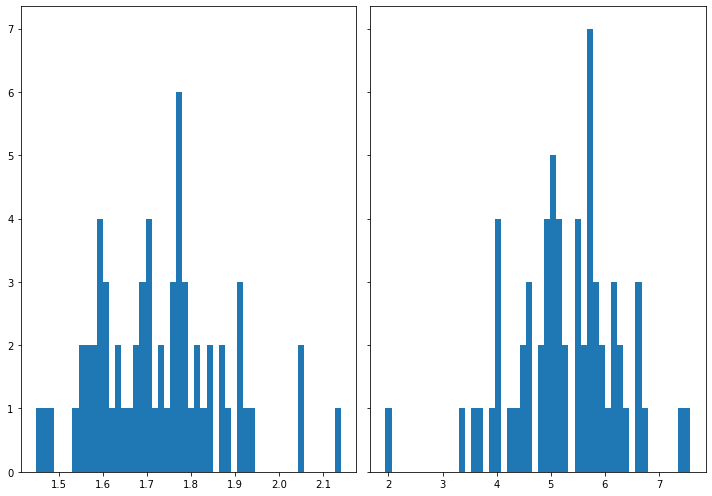

Epoch 11, step 7000: Generator loss: 0.29058943647891283, critic loss: 0.4191782072186468


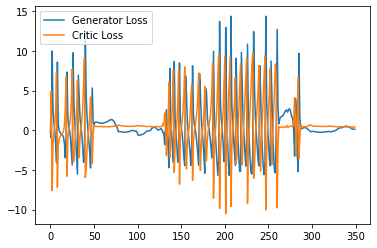

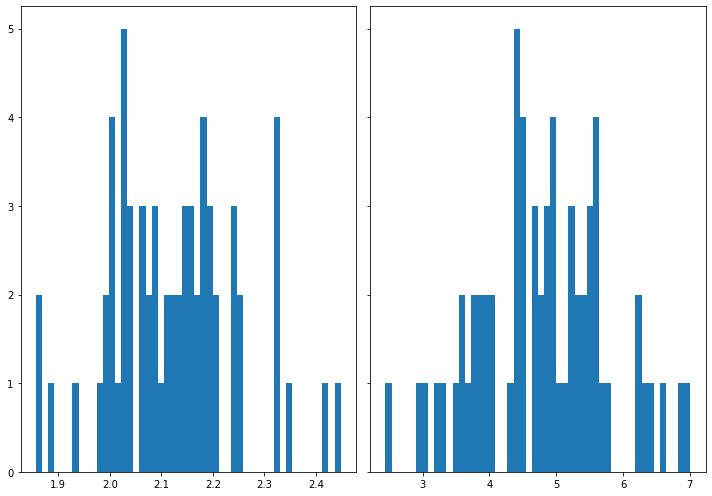

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 12, step 7200: Generator loss: 0.04071501574711874, critic loss: 0.3829441091716287


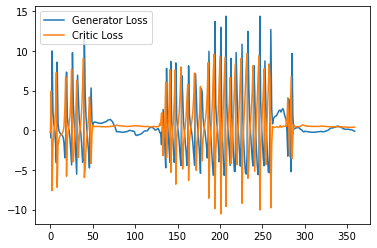

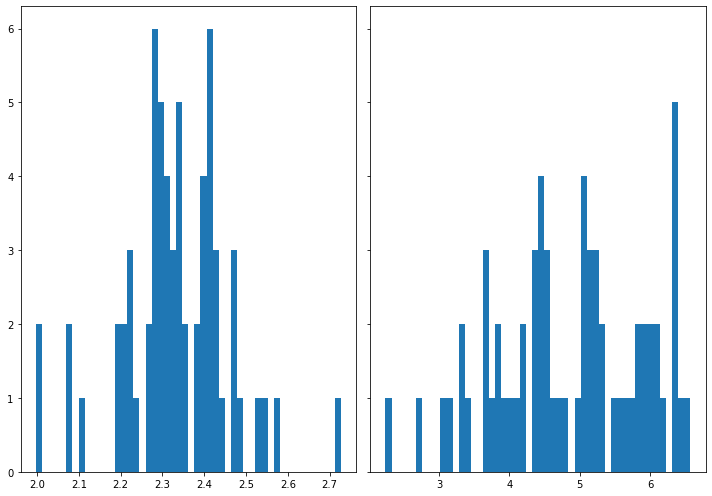

Epoch 12, step 7400: Generator loss: 0.13498185390606524, critic loss: 0.38013632397353647


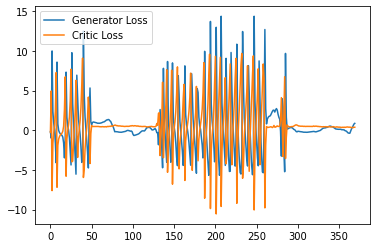

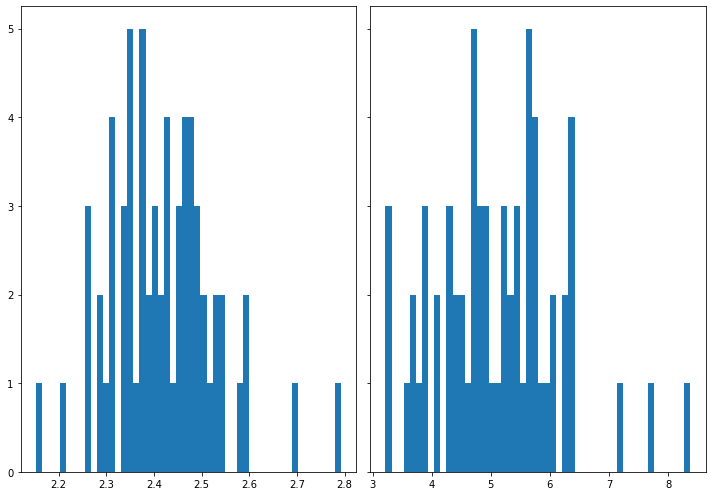

Epoch 12, step 7600: Generator loss: 0.1019477153767366, critic loss: 0.35286098811030386


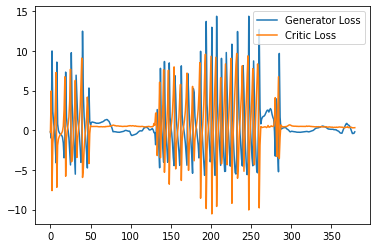

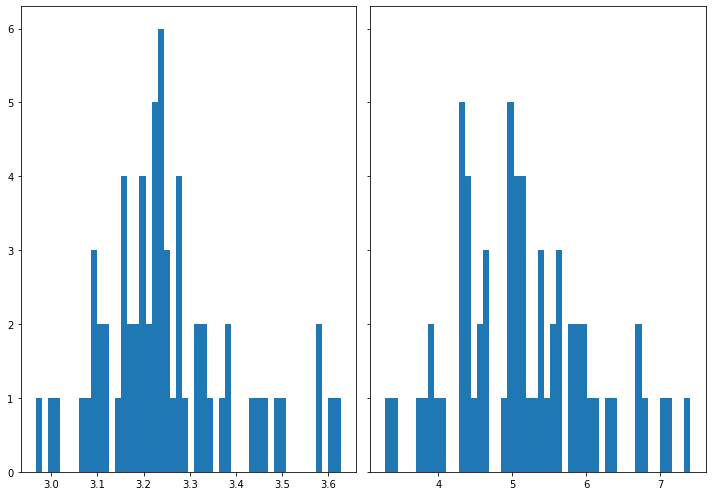

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 13, step 7800: Generator loss: -0.048368774699047205, critic loss: 0.35439011214673527


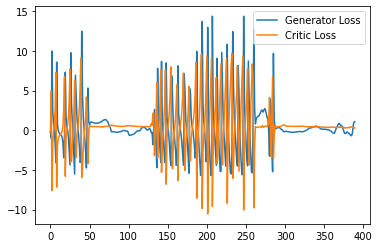

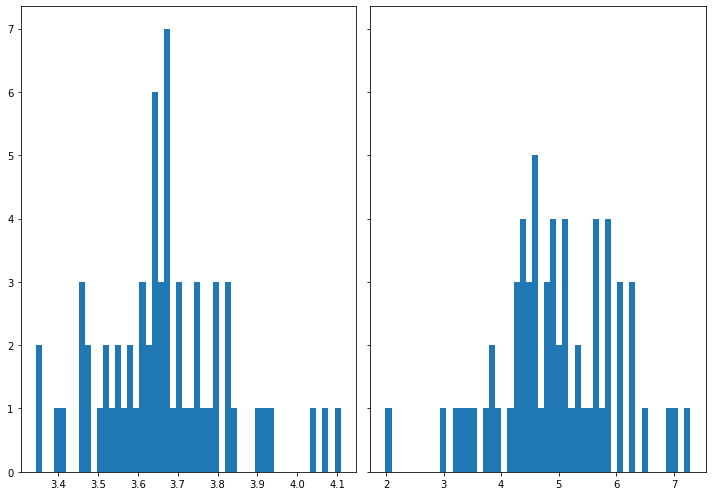

Epoch 13, step 8000: Generator loss: 1.115443587526679, critic loss: 0.5287464719074777


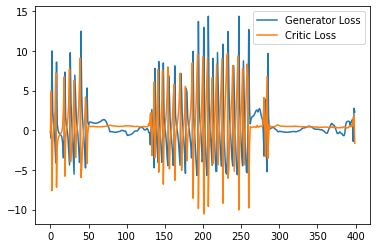

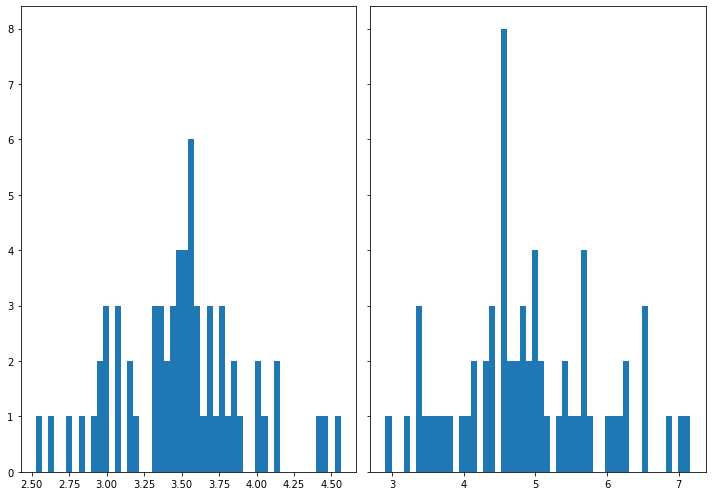

Epoch 13, step 8200: Generator loss: 0.5224452922493219, critic loss: 0.32077405998110775


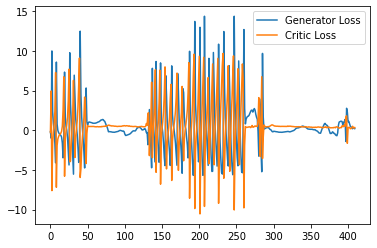

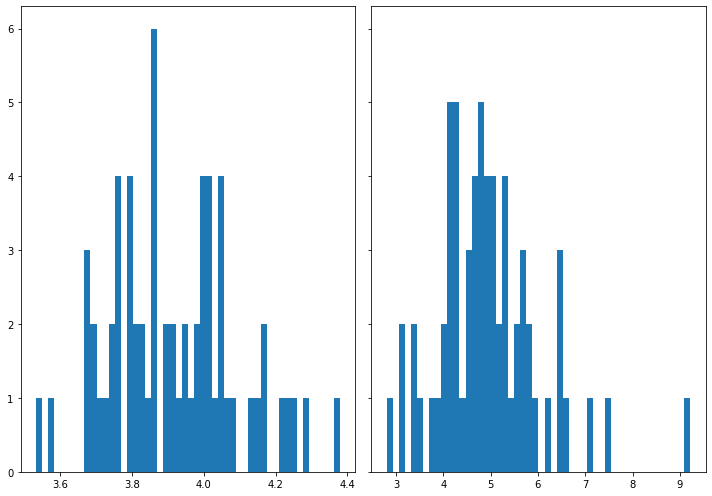

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 14, step 8400: Generator loss: -0.4143554828711785, critic loss: 0.5058751478306952


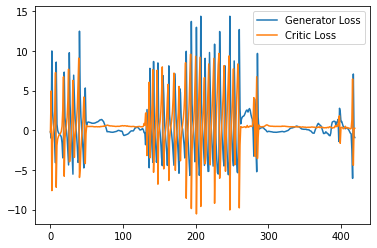

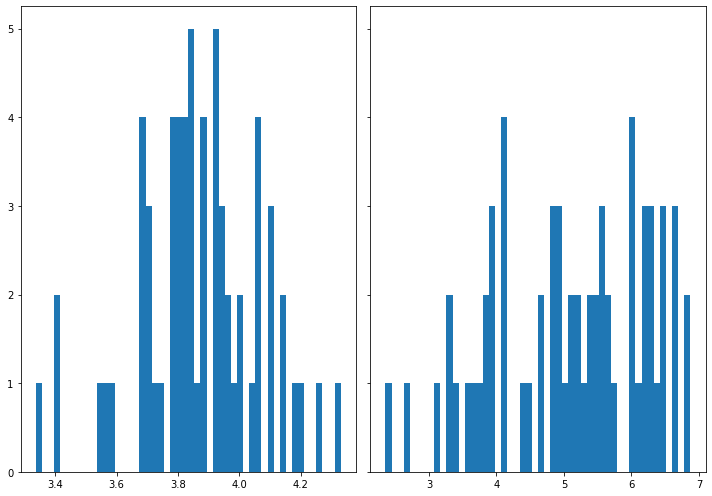

Epoch 14, step 8600: Generator loss: -1.2804438805580138, critic loss: 0.17740765276364978


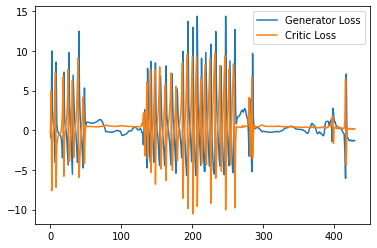

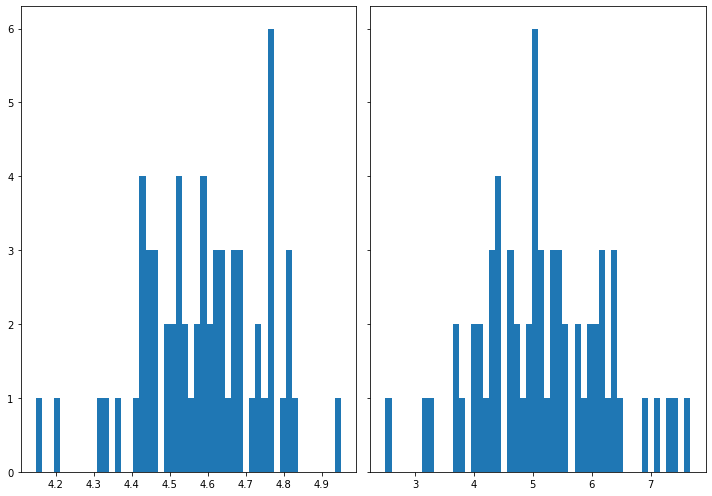

Epoch 14, step 8800: Generator loss: -0.7195276651065796, critic loss: 0.46084447431750614


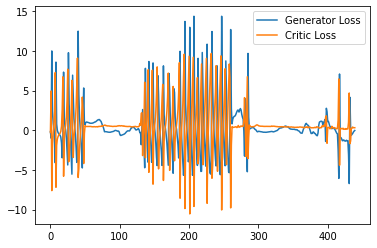

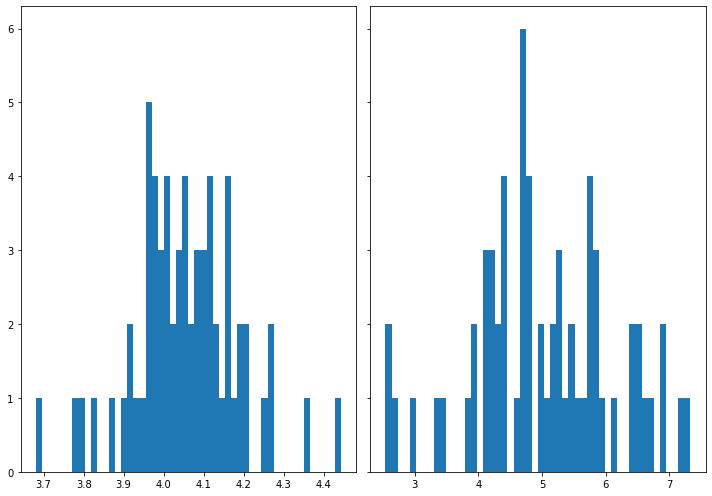

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 15, step 9000: Generator loss: -0.7473502076603472, critic loss: 0.9077347869332878


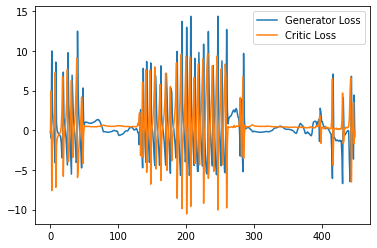

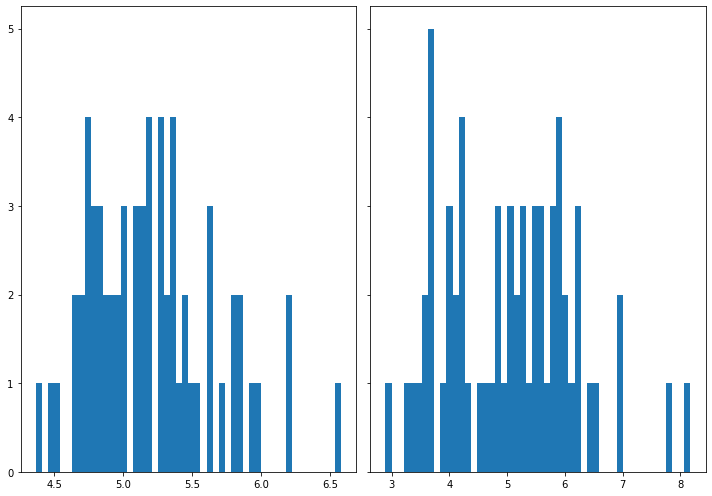

Epoch 15, step 9200: Generator loss: -1.1248666805028915, critic loss: 0.383531905680895


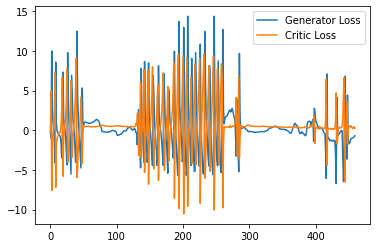

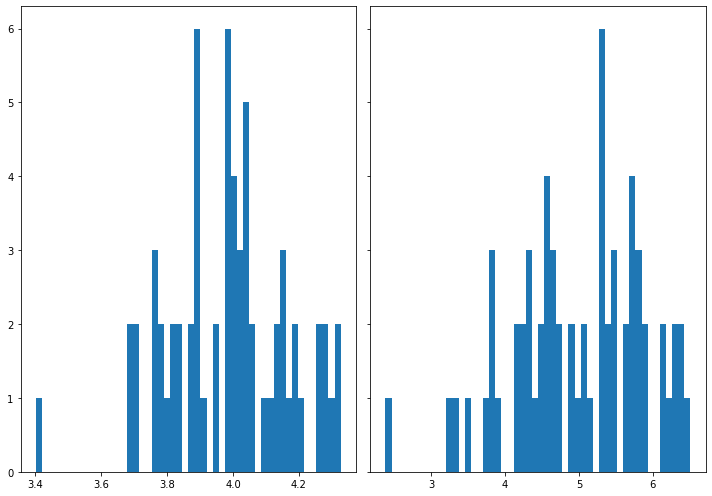

Epoch 15, step 9400: Generator loss: -0.2099439575150609, critic loss: 0.6004184315949677


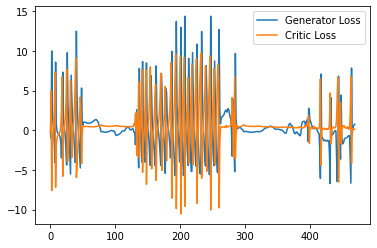

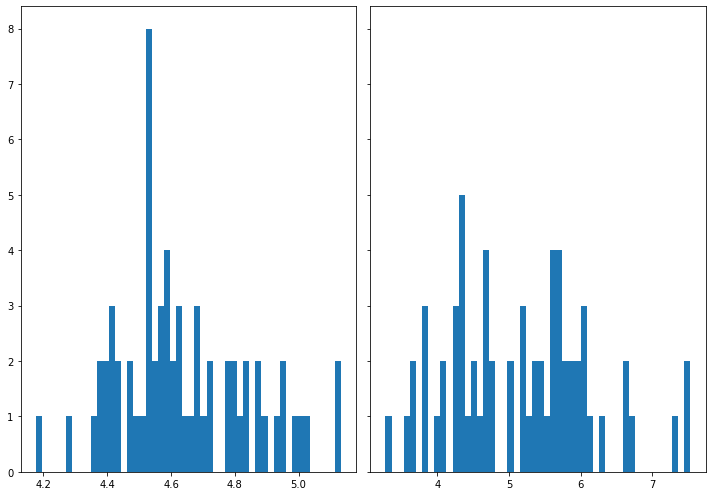

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 16, step 9600: Generator loss: 0.7935398441553115, critic loss: 0.11757142345979804


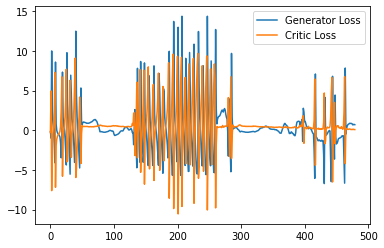

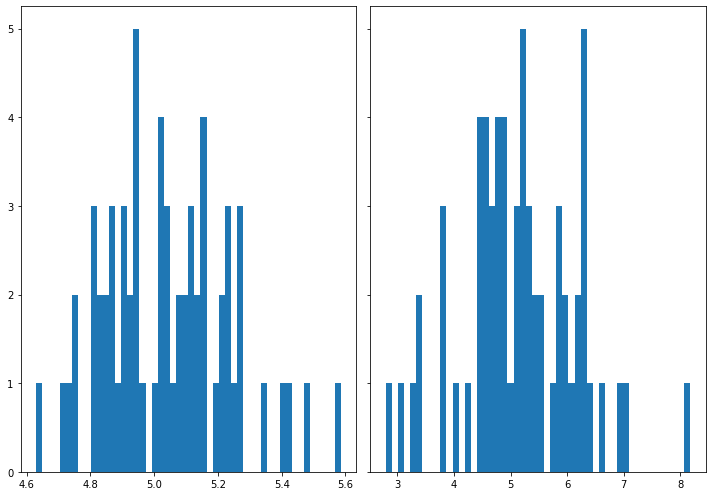

Epoch 16, step 9800: Generator loss: 0.7629327027208638, critic loss: 0.3195216905735435


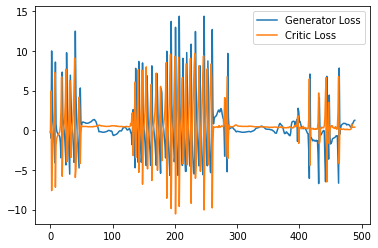

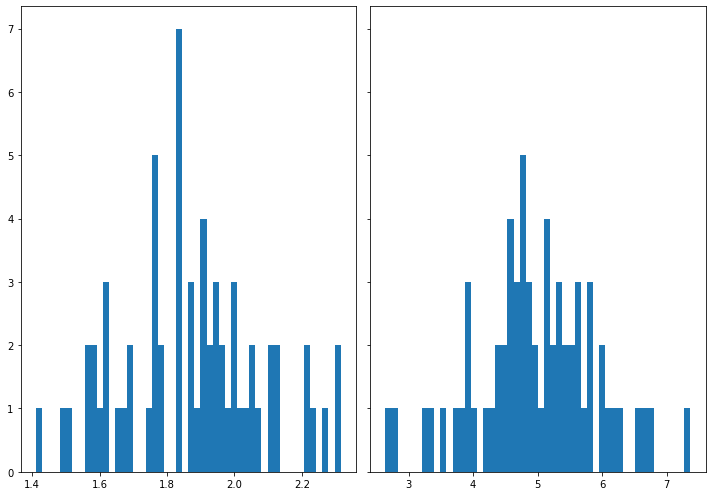

Epoch 16, step 10000: Generator loss: 1.4612579756975175, critic loss: 0.5244093852043152


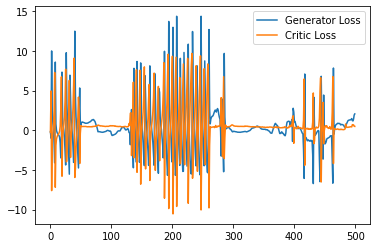

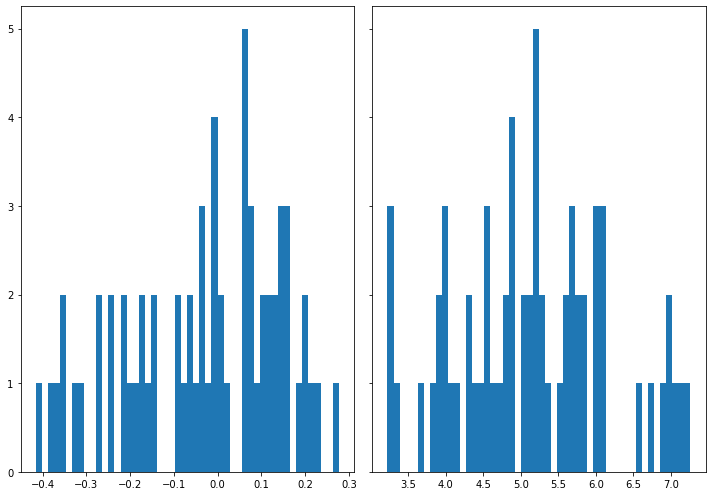

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 17, step 10200: Generator loss: 1.9191501596570015, critic loss: 0.23192729299888007


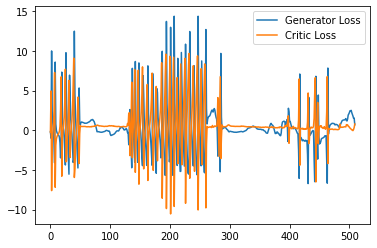

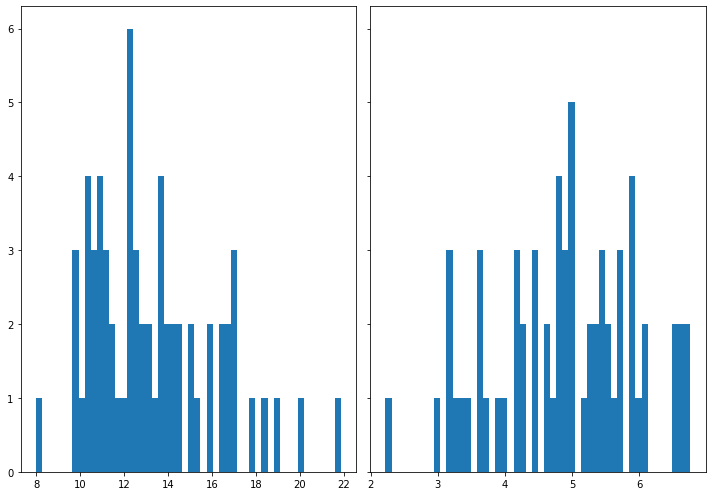

Epoch 17, step 10400: Generator loss: 1.0142597542004659, critic loss: 0.3658761066272853


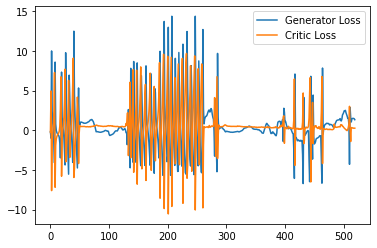

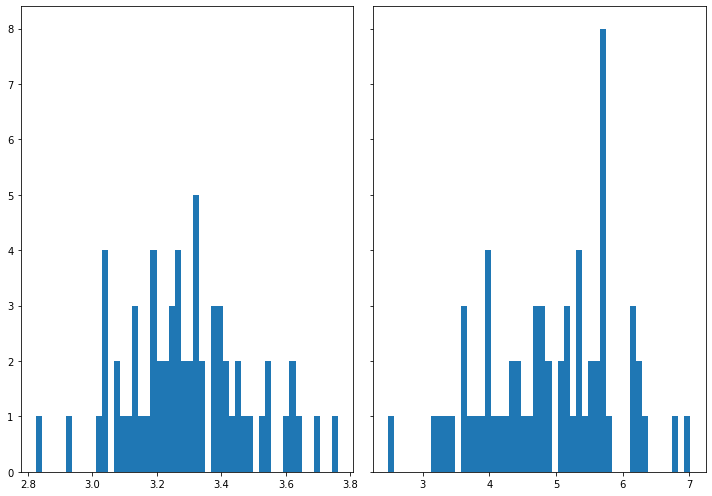

Epoch 17, step 10600: Generator loss: 0.6154422231658827, critic loss: 0.331359871663153


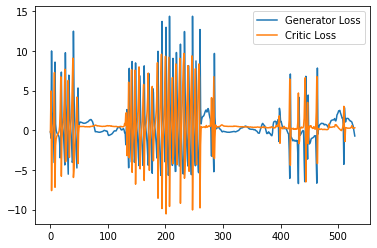

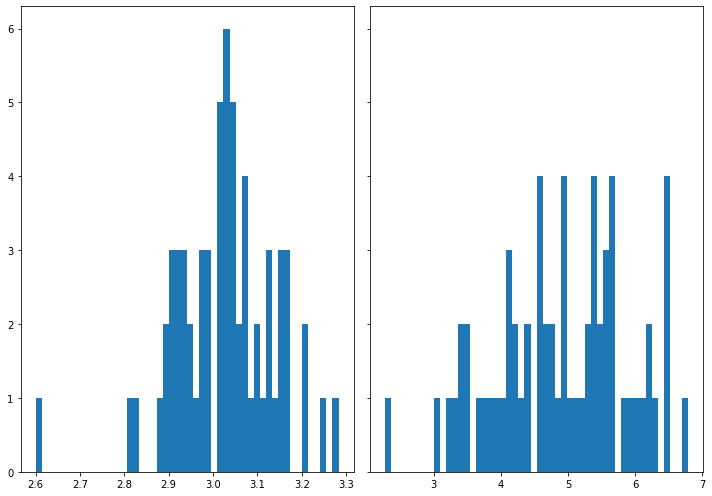

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 18, step 10800: Generator loss: -1.5622946860268712, critic loss: 0.3021243283674122


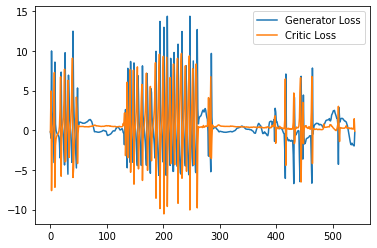

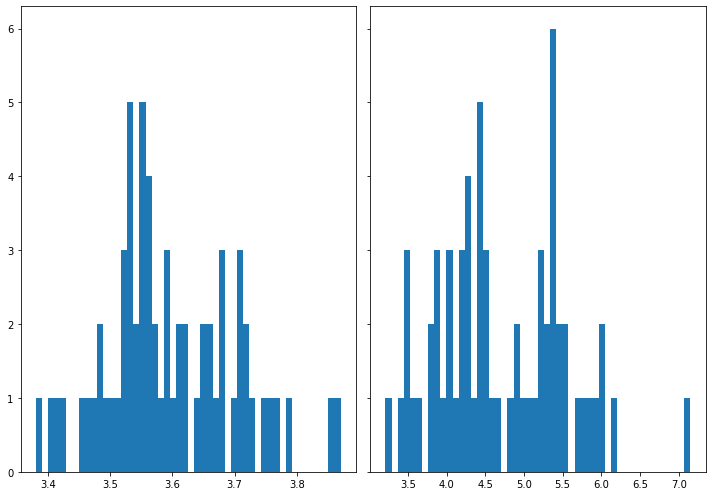

Epoch 18, step 11000: Generator loss: -0.9959526666998864, critic loss: 0.13353281271085135


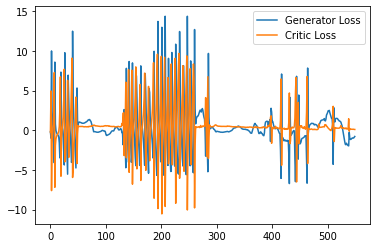

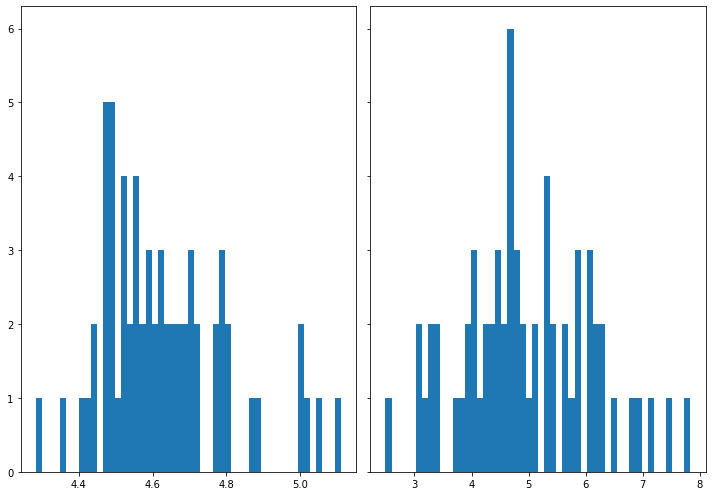

Epoch 18, step 11200: Generator loss: 0.07654236171161756, critic loss: 0.0940177543181926


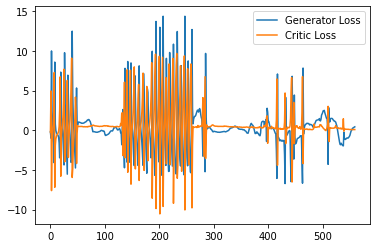

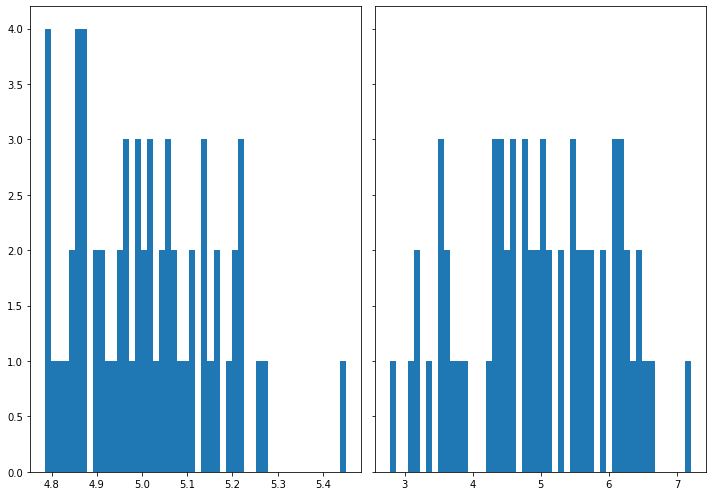

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 19, step 11400: Generator loss: 0.7745813657343388, critic loss: 0.159619976926595


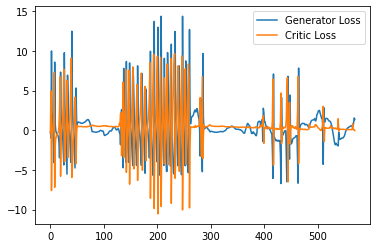

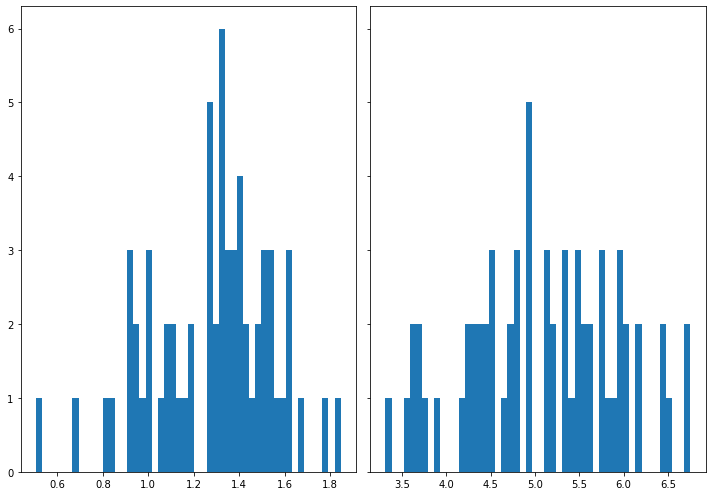

Epoch 19, step 11600: Generator loss: 0.6364037935435772, critic loss: -0.01602959365770223


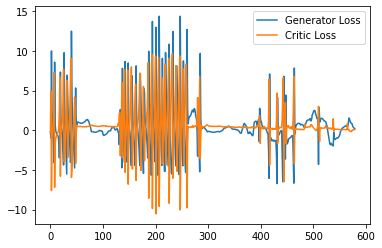

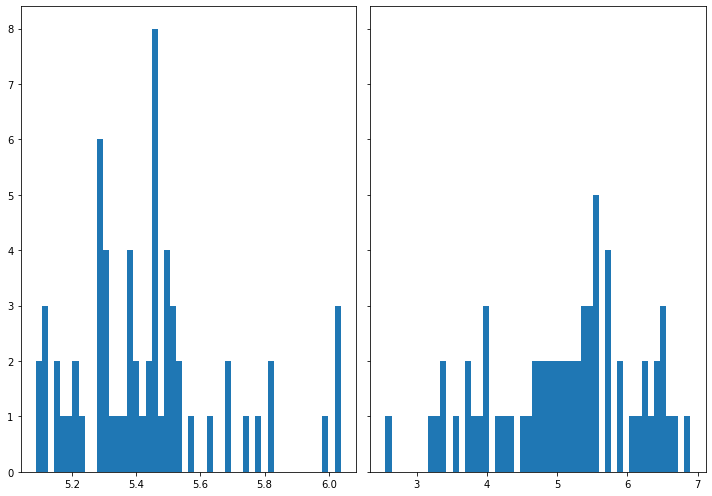

Epoch 19, step 11800: Generator loss: 0.18848919754847884, critic loss: 0.6330614962074903


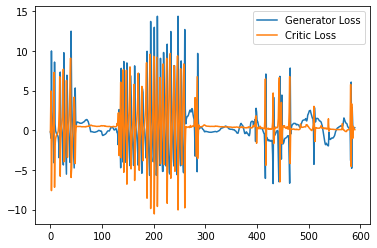

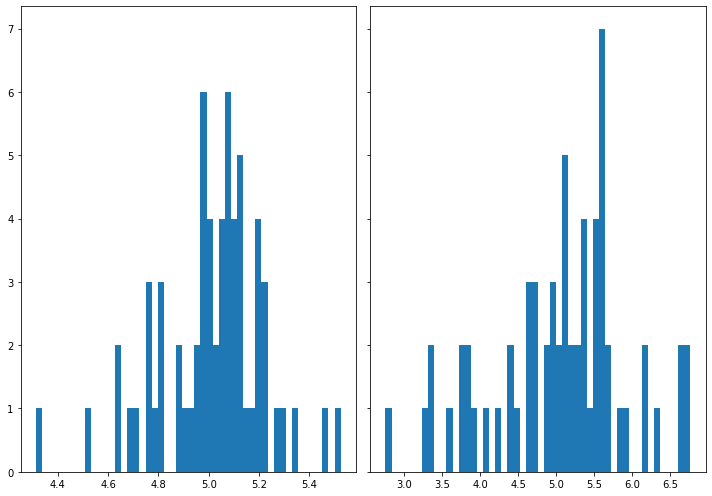

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 20, step 12000: Generator loss: 0.5612740457057953, critic loss: 0.0767825395842083


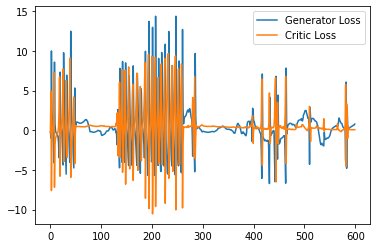

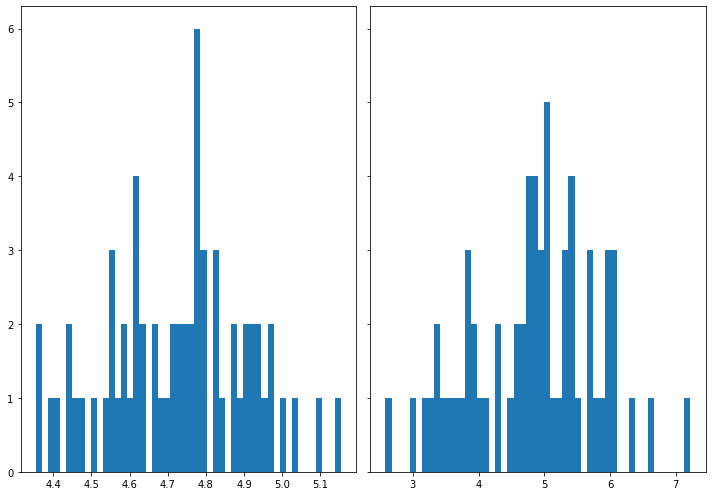

Epoch 20, step 12200: Generator loss: 1.0045731270313263, critic loss: 0.06841573775117284


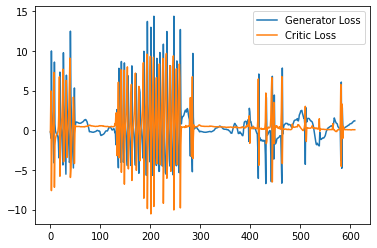

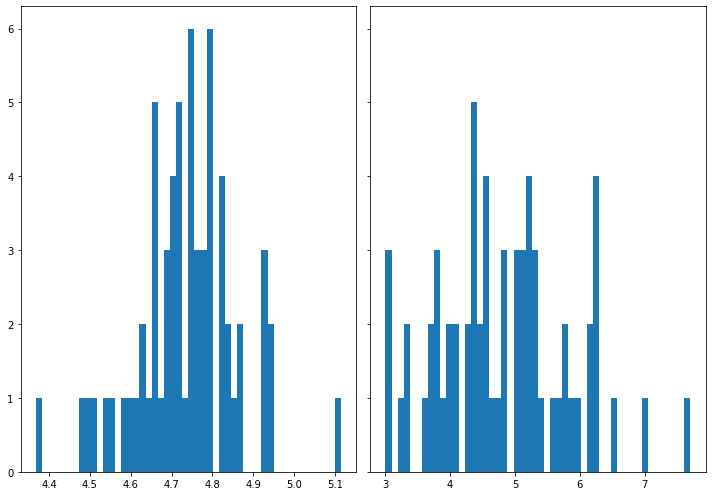

Epoch 20, step 12400: Generator loss: 1.3109556263685227, critic loss: 0.07280485044047239


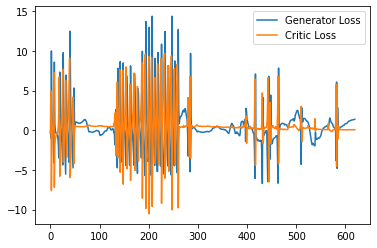

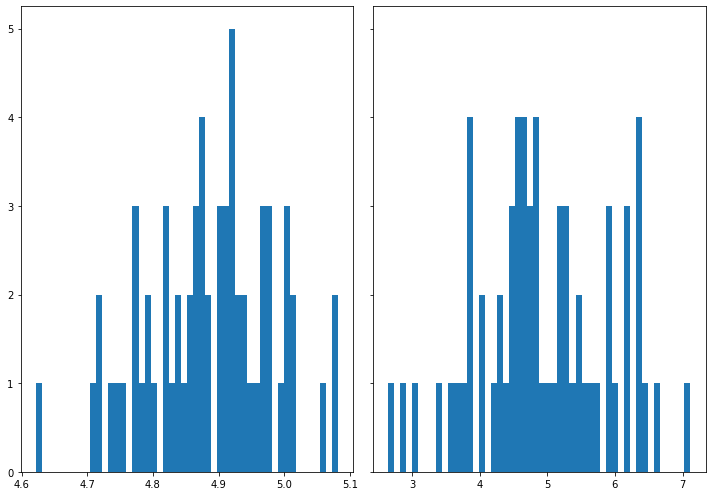

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 21, step 12600: Generator loss: 1.386391823887825, critic loss: 0.0766151762246154


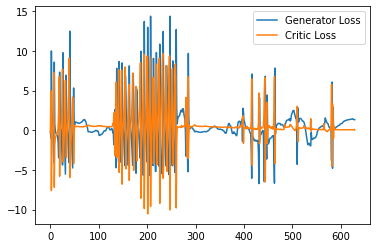

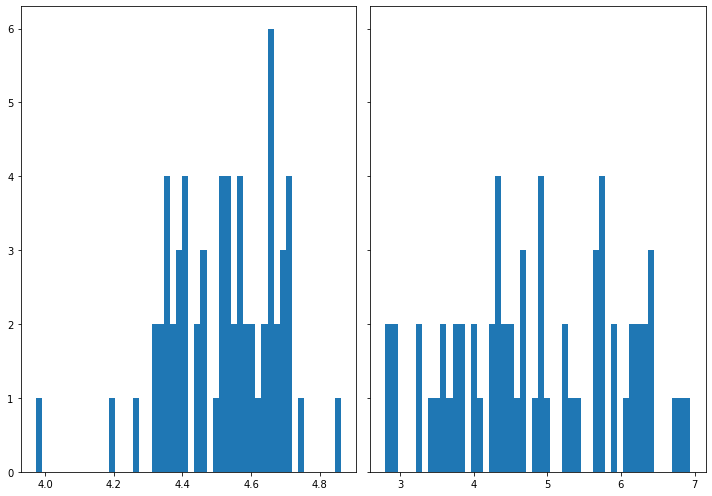

Epoch 21, step 12800: Generator loss: 1.4124156618118286, critic loss: 0.05747857619356367


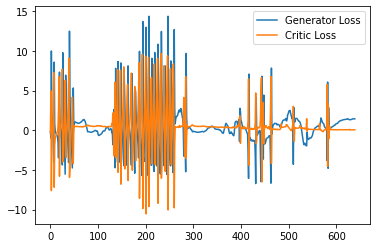

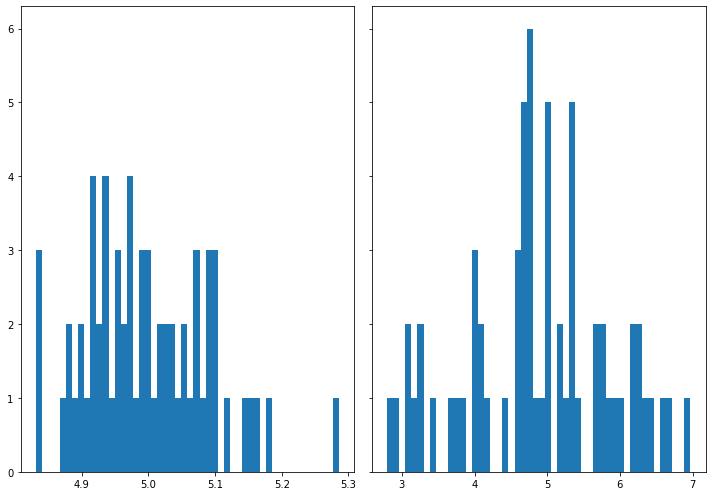

Epoch 21, step 13000: Generator loss: 1.4569190216064454, critic loss: 0.07821364205516876


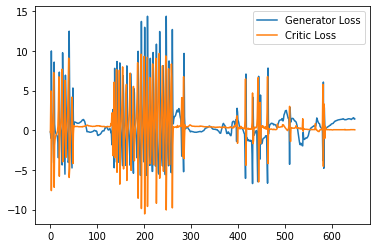

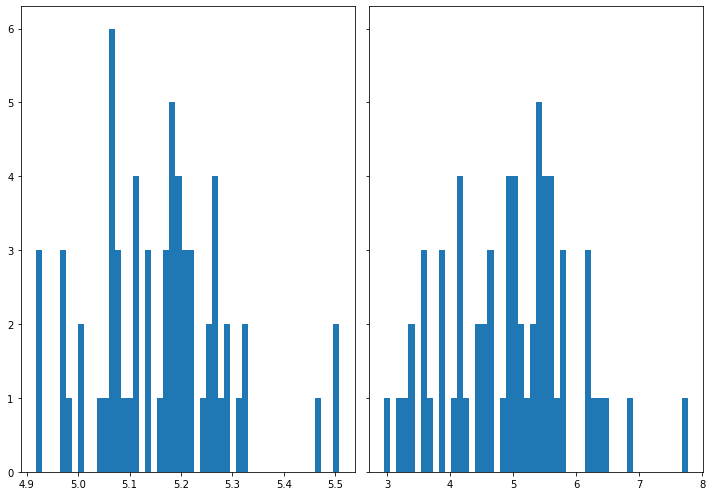

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 22, step 13200: Generator loss: 1.363038141131401, critic loss: 0.06596384326927372


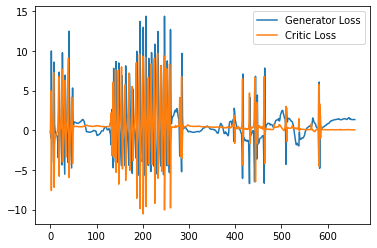

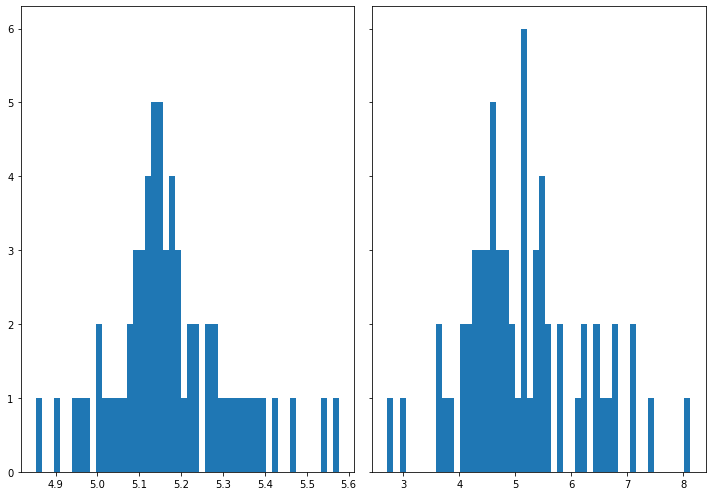

Epoch 22, step 13400: Generator loss: 1.3459765952825546, critic loss: 0.0748694982212037


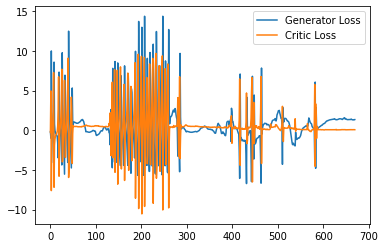

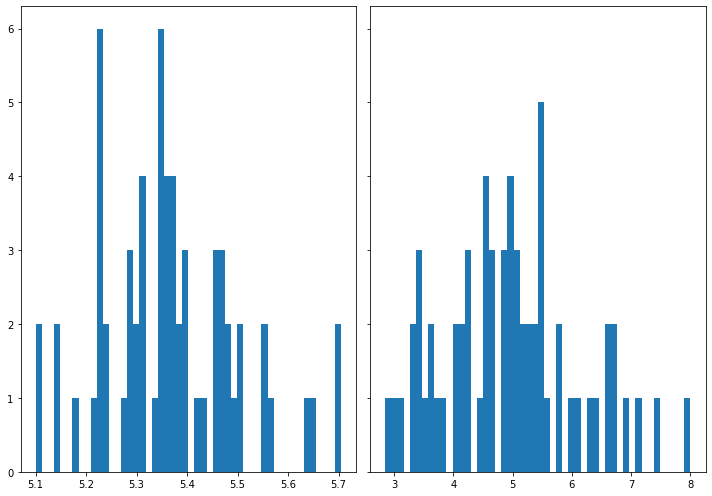

Epoch 22, step 13600: Generator loss: 1.2610011959075929, critic loss: 0.08194084239006044


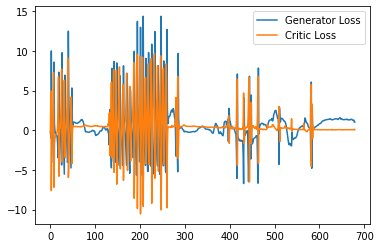

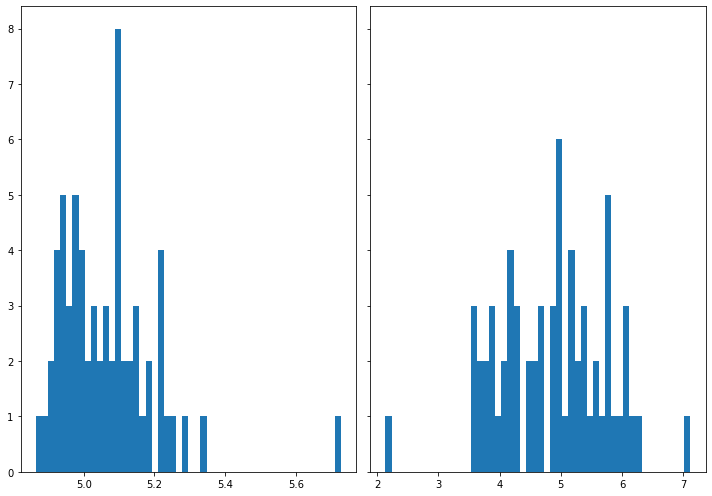

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 23, step 13800: Generator loss: 1.0939038395881653, critic loss: 0.08126523115858436


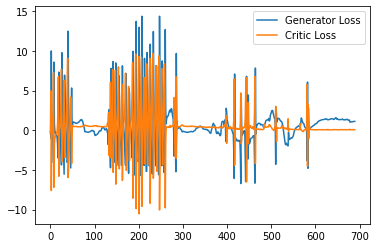

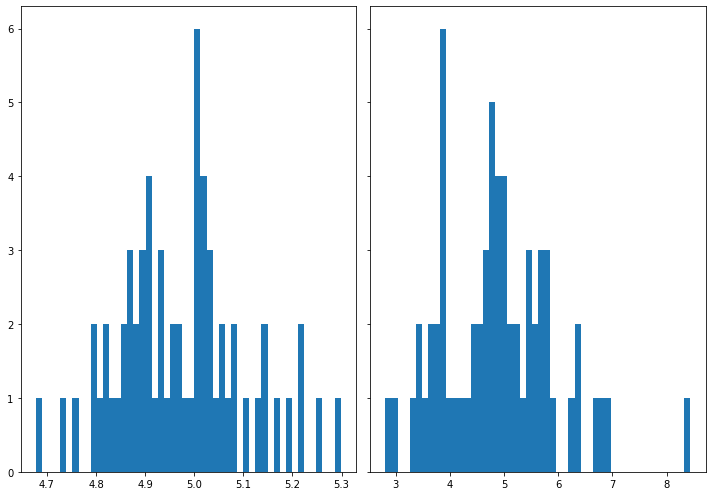

Epoch 23, step 14000: Generator loss: 1.1272072559595108, critic loss: 0.08478294136747713


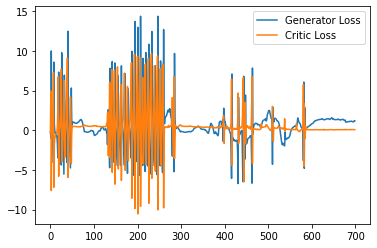

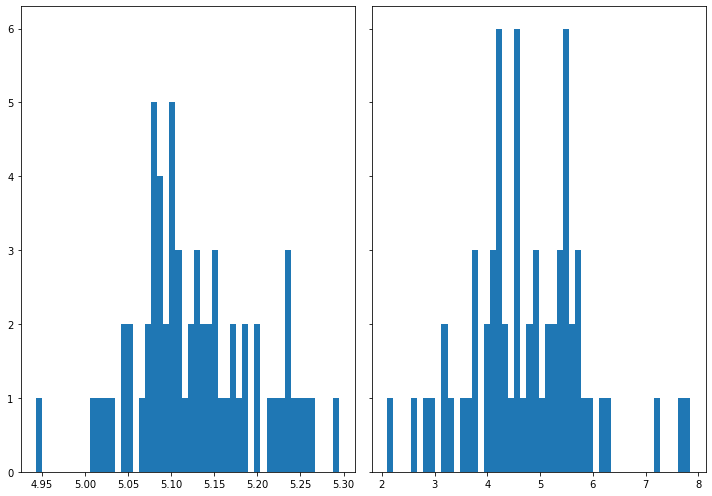

Epoch 23, step 14200: Generator loss: 1.2004446417093277, critic loss: 0.08638594717532401


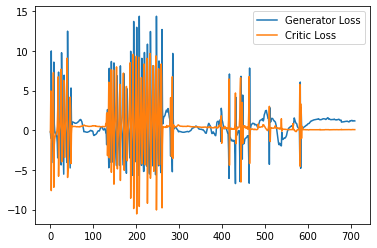

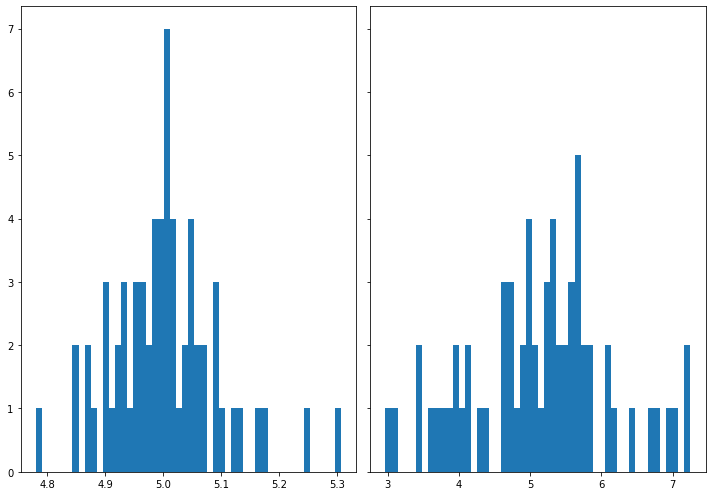

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 24, step 14400: Generator loss: 1.0278922453522683, critic loss: 0.08234535703435546


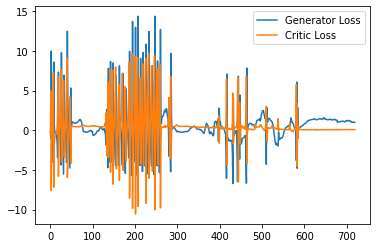

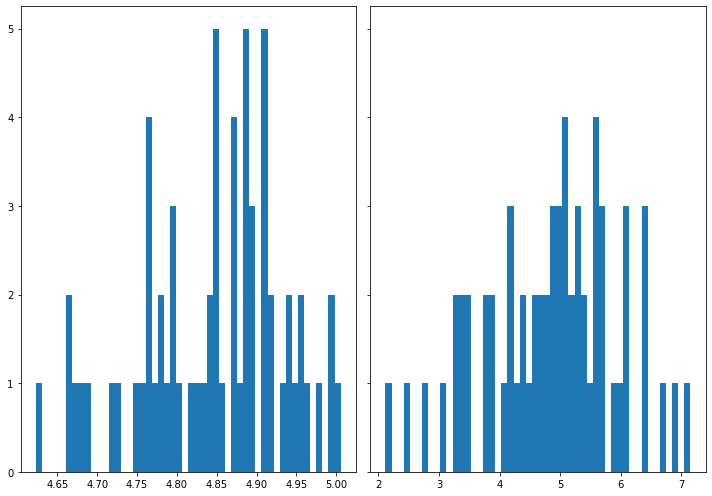

Epoch 24, step 14600: Generator loss: 1.0247687605023383, critic loss: 0.08443782106041907


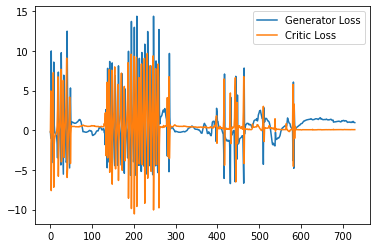

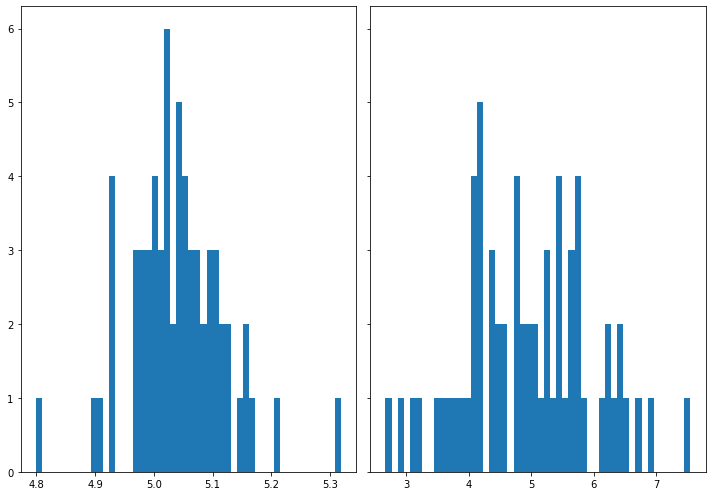

Epoch 24, step 14800: Generator loss: 1.0394859564304353, critic loss: 0.08360395712032913


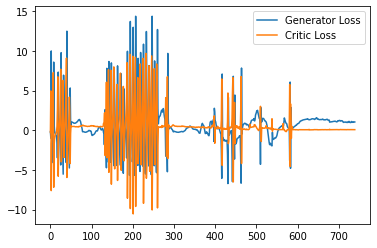

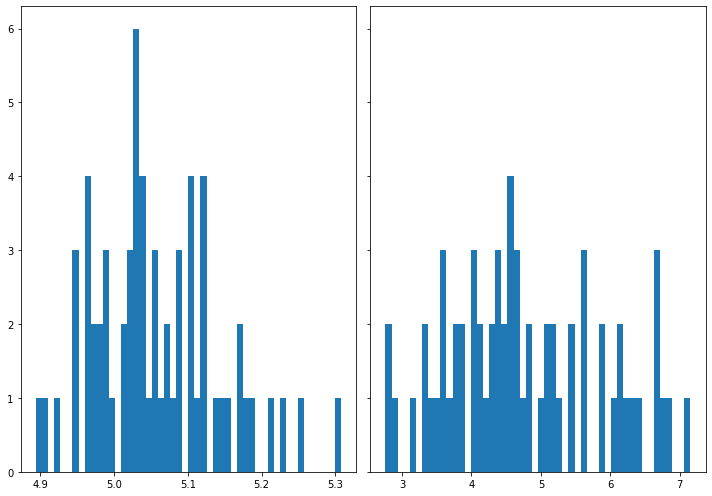

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 25, step 15000: Generator loss: 1.0231445002555848, critic loss: 0.08599127811565996


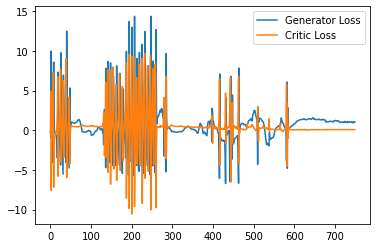

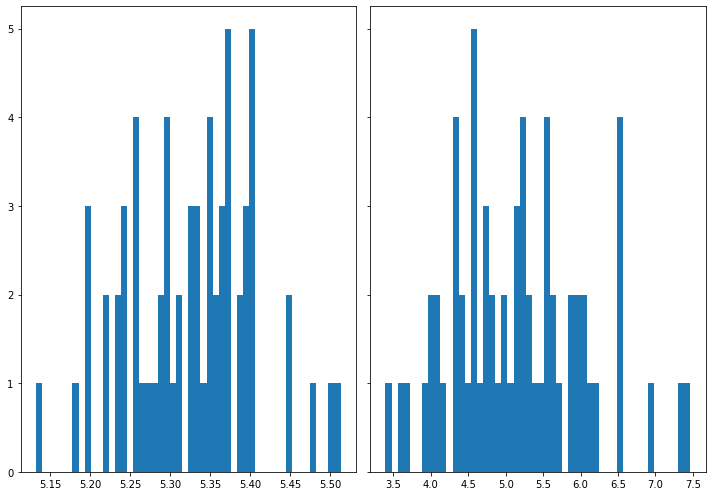

Epoch 25, step 15200: Generator loss: 1.0666725370287895, critic loss: 0.08478456773236395


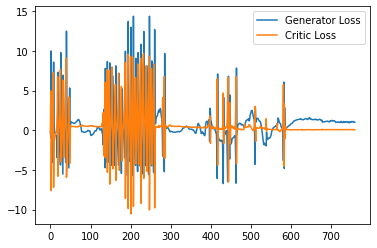

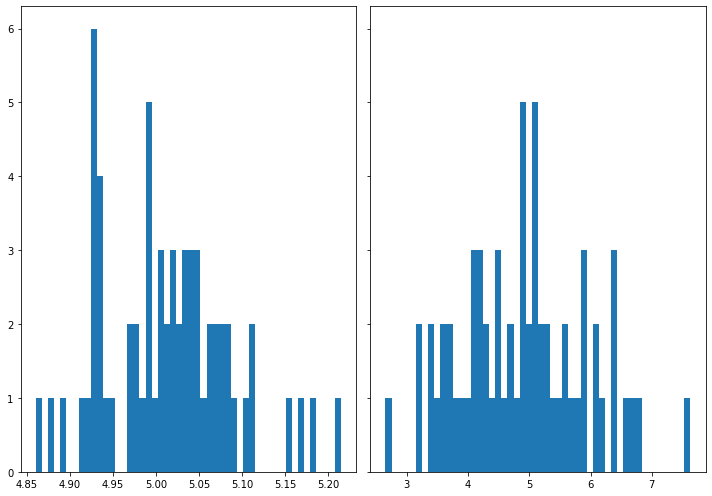

Epoch 25, step 15400: Generator loss: 1.0607628792524337, critic loss: 0.08409687661752102


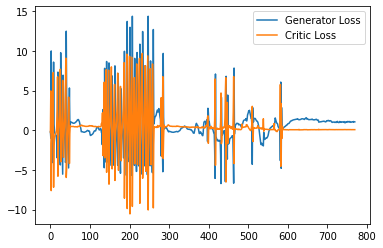

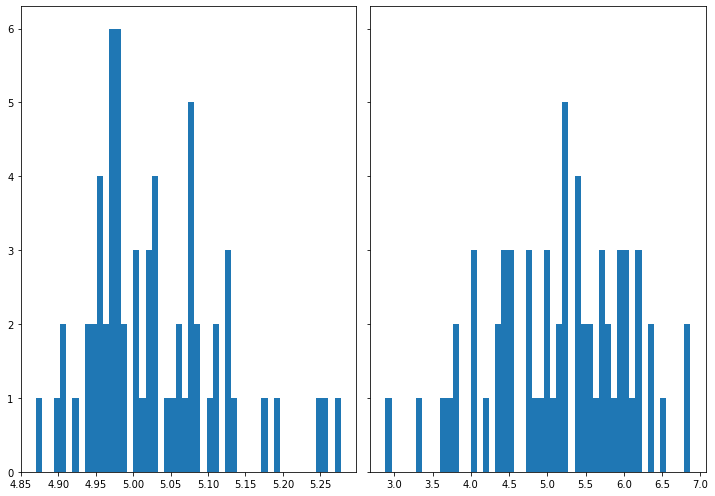

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 26, step 15600: Generator loss: 1.0563940539956094, critic loss: 0.08510597274824976


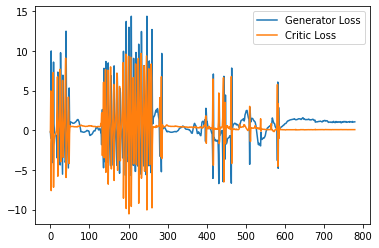

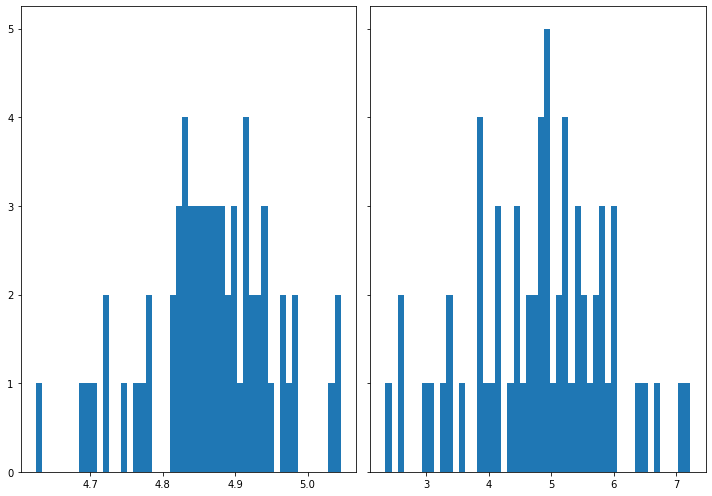

Epoch 26, step 15800: Generator loss: 1.0345498219132423, critic loss: 0.08848893575370315


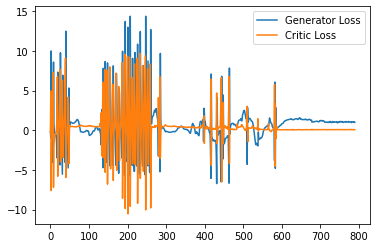

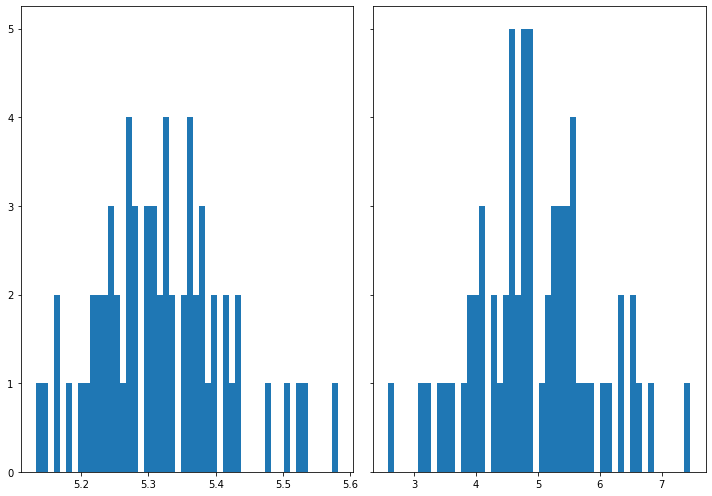

Epoch 26, step 16000: Generator loss: 1.0250012129545212, critic loss: 0.08498544159904124


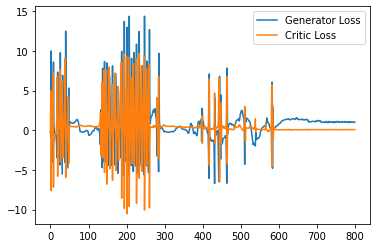

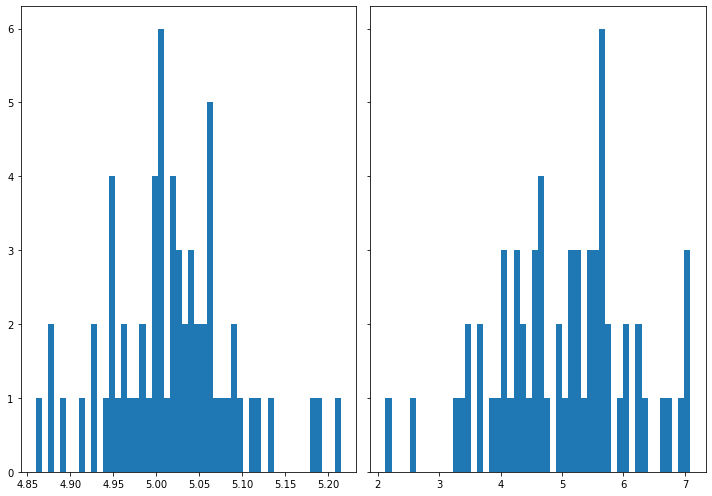

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 27, step 16200: Generator loss: 0.9247168746590614, critic loss: 0.0865407556220889


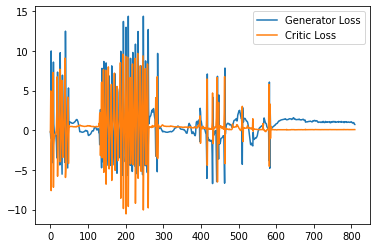

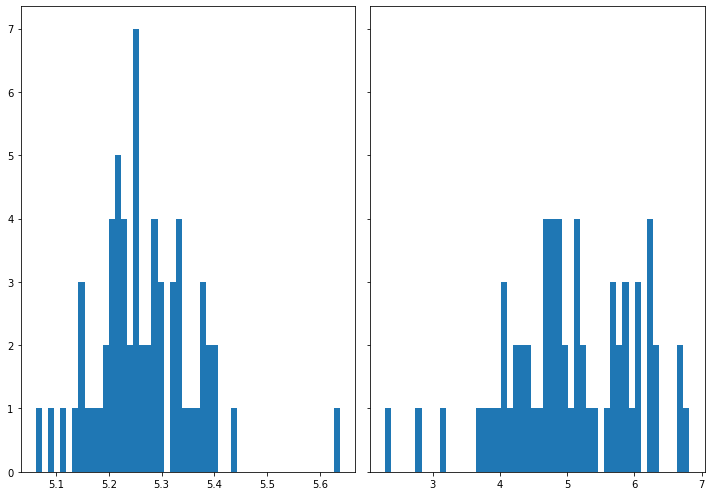

Epoch 27, step 16400: Generator loss: 0.7934330594539643, critic loss: 0.08501542377844454


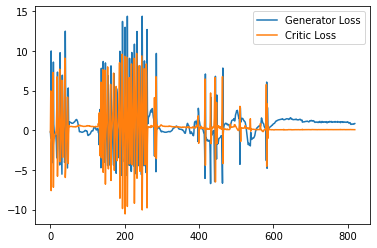

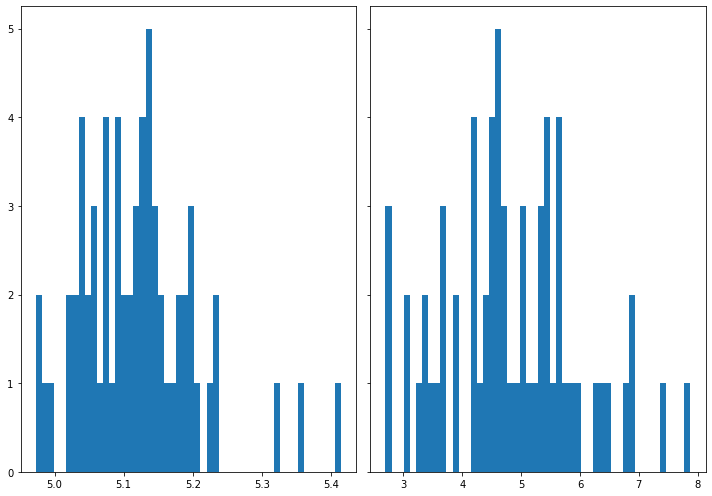

Epoch 27, step 16600: Generator loss: 0.8879042929410934, critic loss: 0.08427795657143003


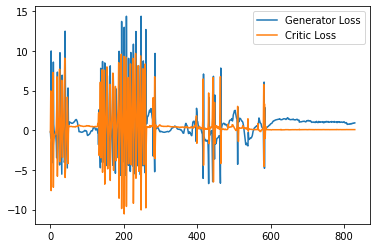

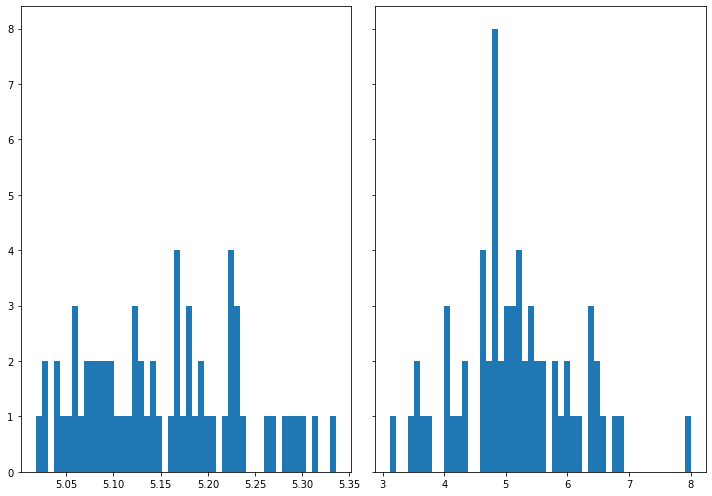

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 28, step 16800: Generator loss: 0.9774209791421891, critic loss: 0.08481147464737294


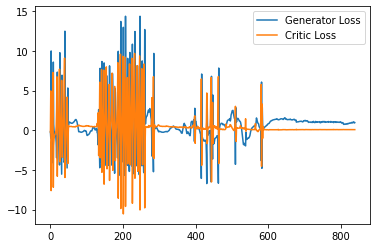

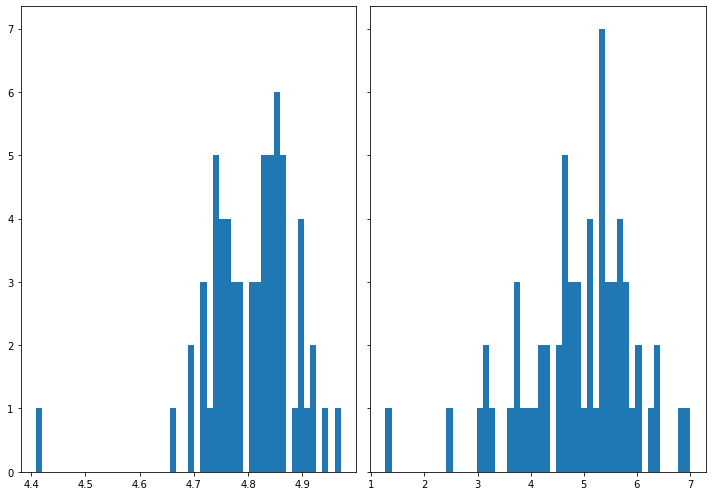

Epoch 28, step 17000: Generator loss: 1.0445571810007095, critic loss: 0.08733962247893214


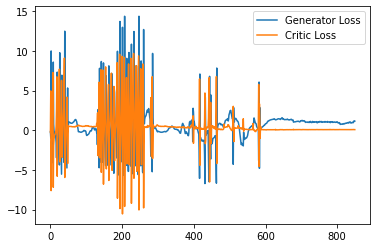

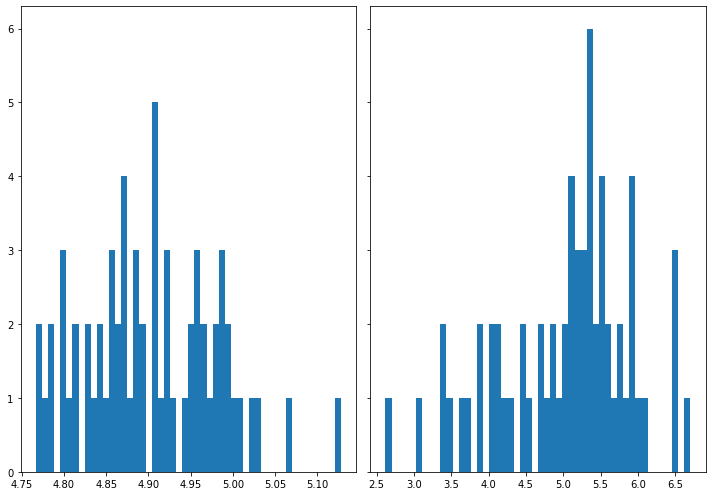

Epoch 28, step 17200: Generator loss: 1.1105495616793633, critic loss: 0.08586617166921495


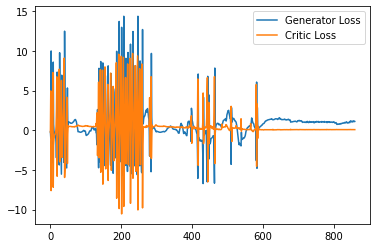

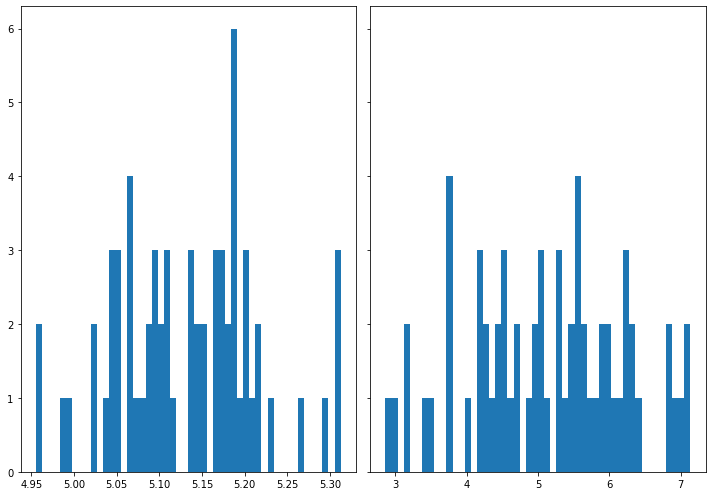

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 29, step 17400: Generator loss: 1.069982884824276, critic loss: 0.08756443259865049


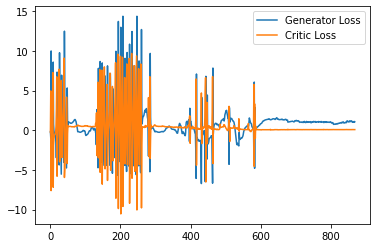

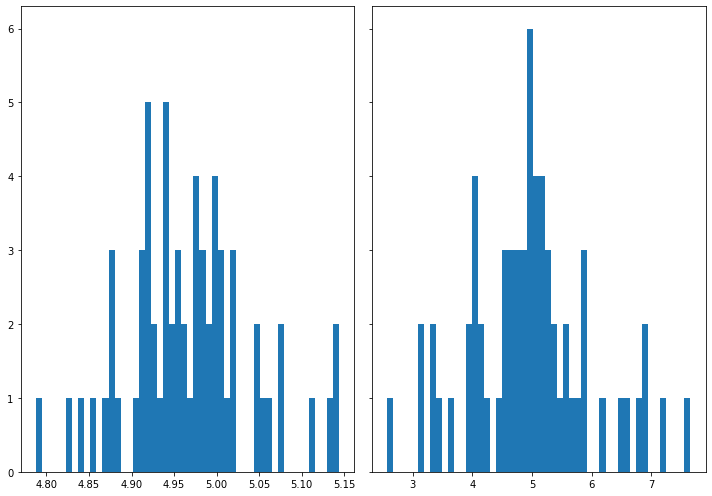

Epoch 29, step 17600: Generator loss: 0.9887739807367325, critic loss: 0.08498254062607885


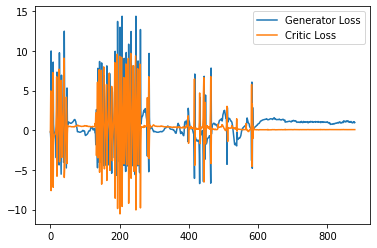

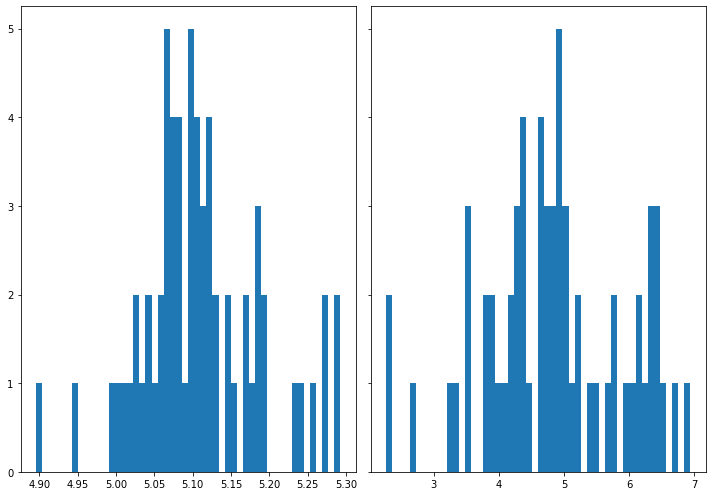

Epoch 29, step 17800: Generator loss: 0.979554757475853, critic loss: 0.08479815274477004


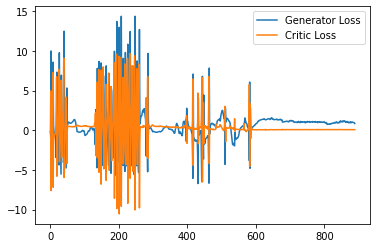

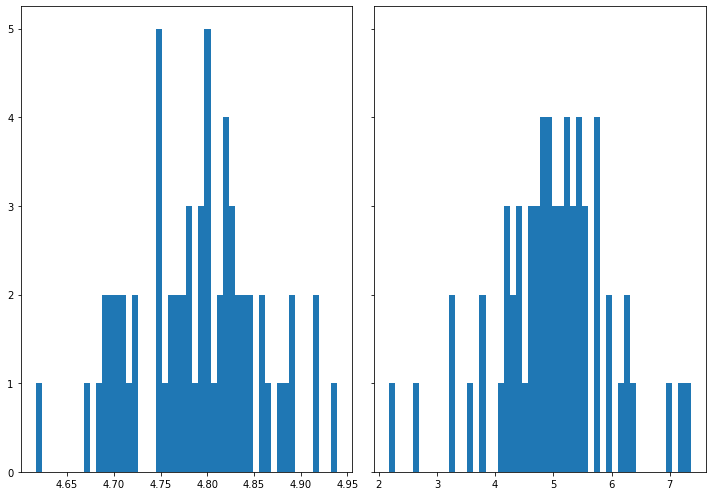

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 30, step 18000: Generator loss: 0.9996264484524727, critic loss: 0.08603943625465037


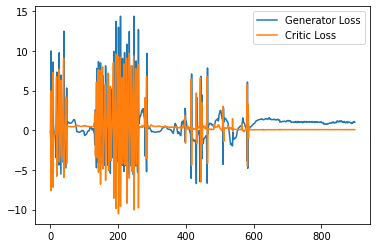

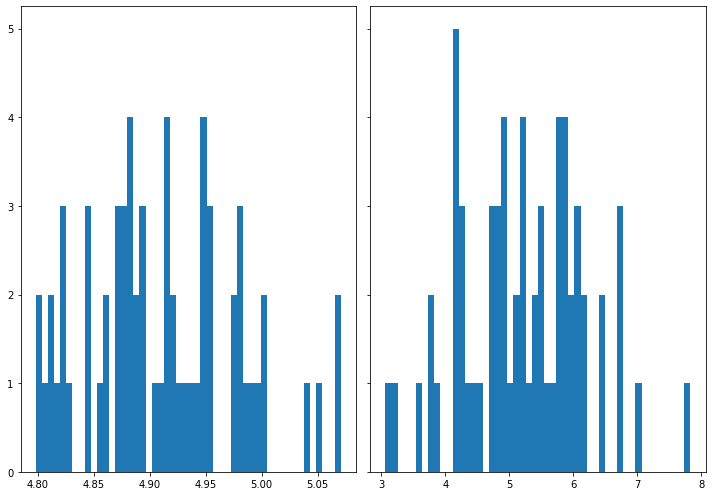

Epoch 30, step 18200: Generator loss: 0.9921652659773826, critic loss: 0.08930660187453034


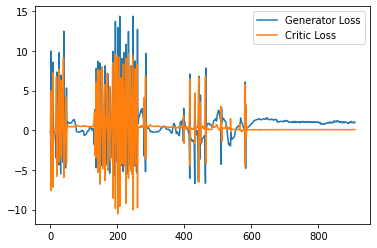

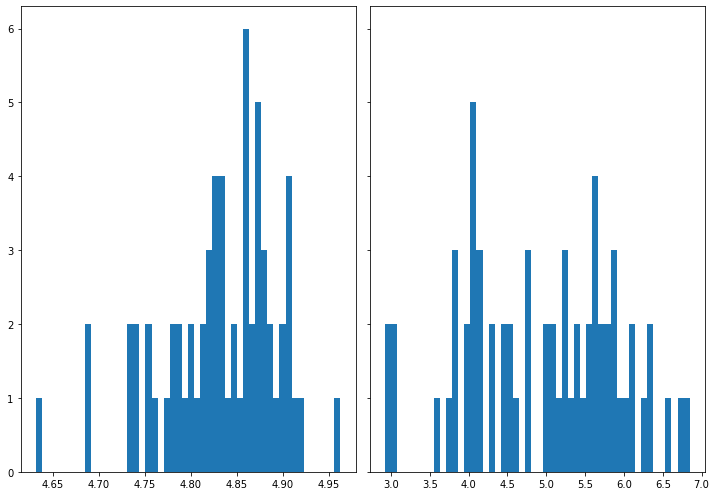

Epoch 30, step 18400: Generator loss: 1.0467035123705863, critic loss: 0.08754494941234583


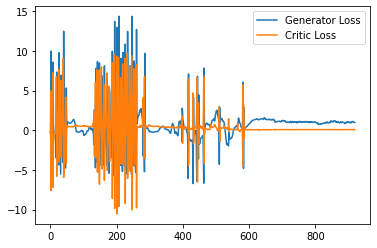

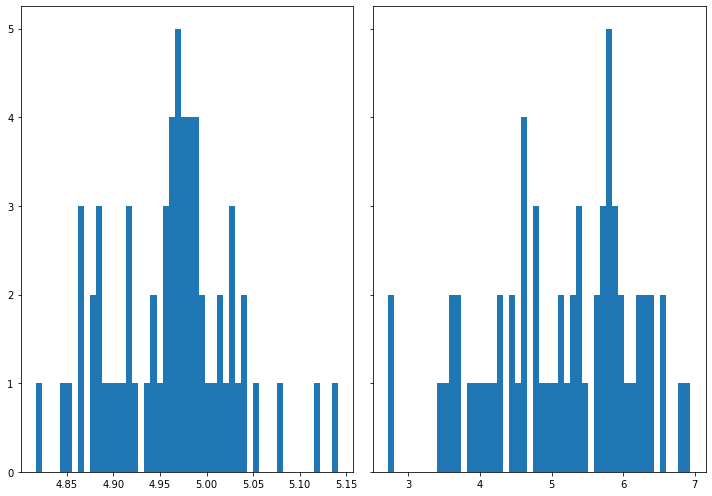

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 31, step 18600: Generator loss: 1.018636909723282, critic loss: 0.08689311573654418


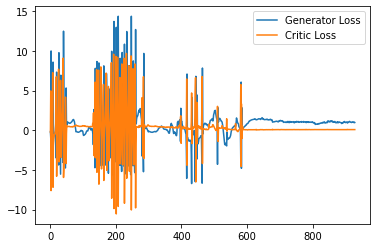

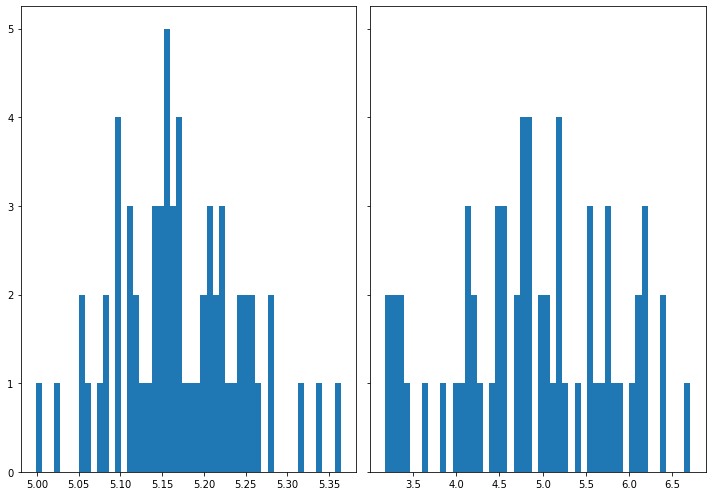

Epoch 31, step 18800: Generator loss: 0.9835482016205788, critic loss: 0.08655218520388001


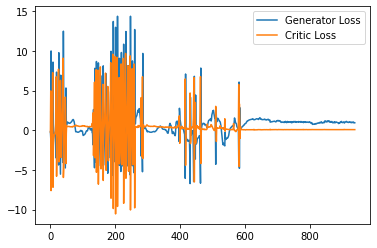

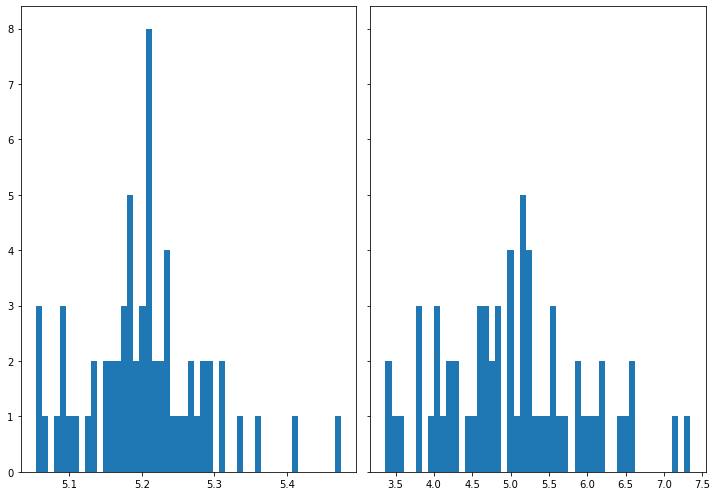

Epoch 31, step 19000: Generator loss: 0.9653865590691566, critic loss: 0.08570573604851964


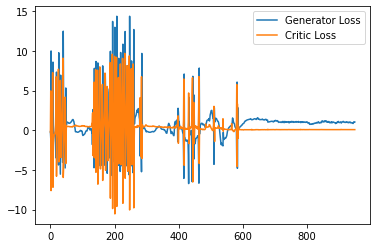

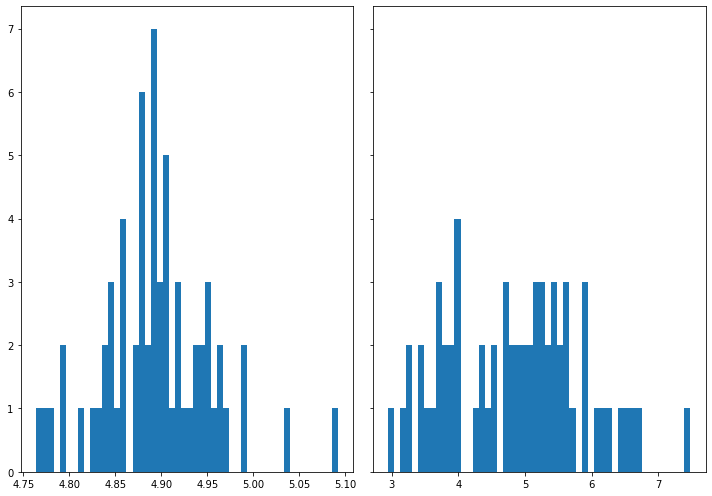

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 32, step 19200: Generator loss: 0.9678082391619682, critic loss: 0.08657413154095407


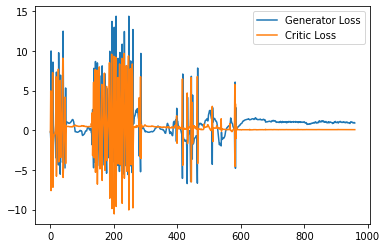

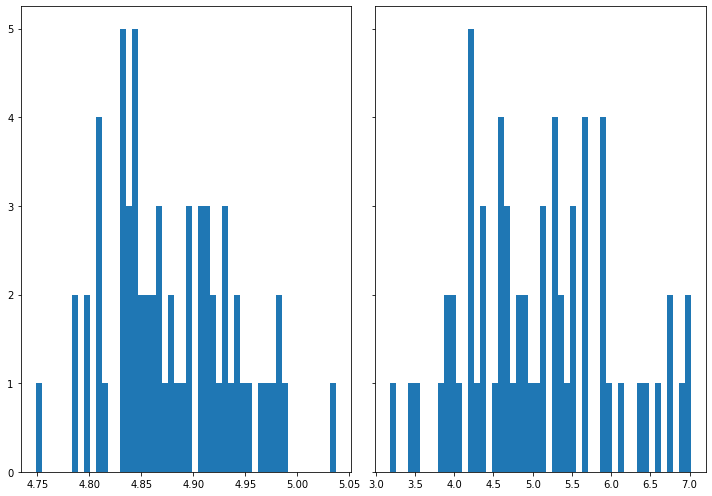

Epoch 32, step 19400: Generator loss: 0.9823499283194542, critic loss: 0.08520893473550674


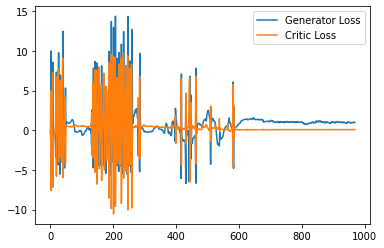

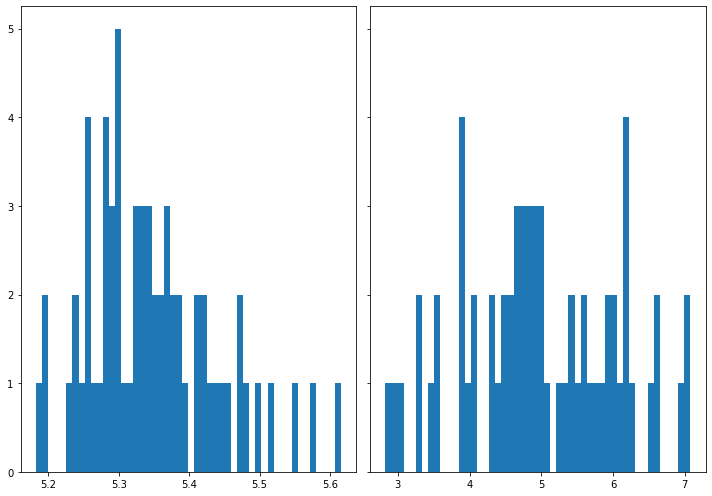

Epoch 32, step 19600: Generator loss: 0.9722784620523452, critic loss: 0.08536932661011813


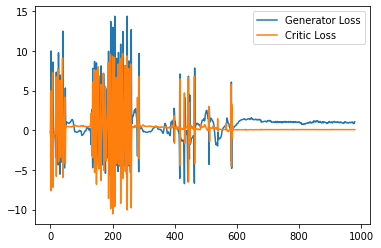

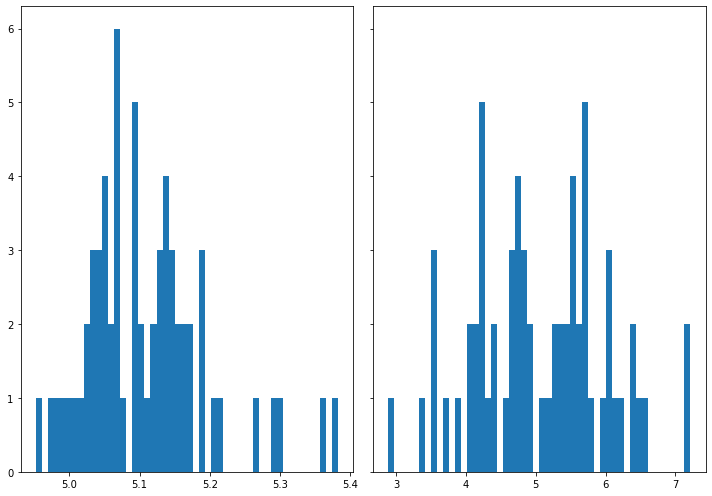

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 33, step 19800: Generator loss: 0.9596168076992035, critic loss: 0.08691619492694734


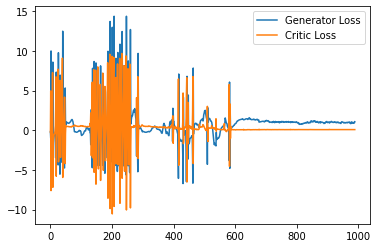

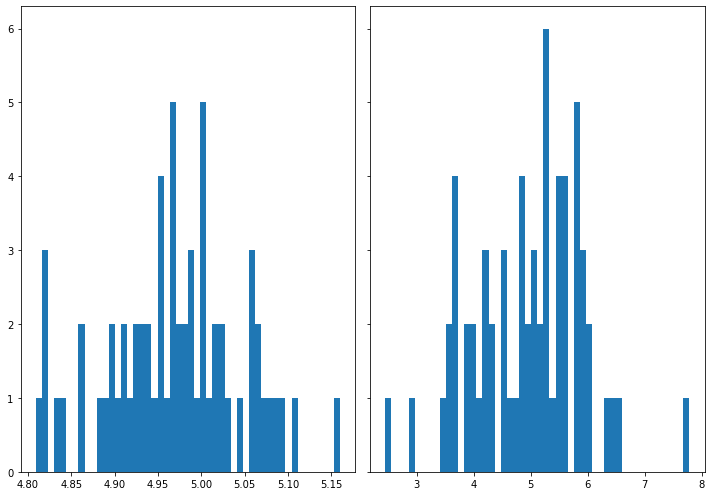

Epoch 33, step 20000: Generator loss: 0.8995012894272805, critic loss: 0.08783314411714675


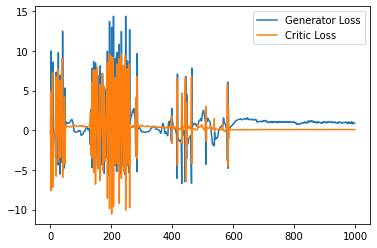

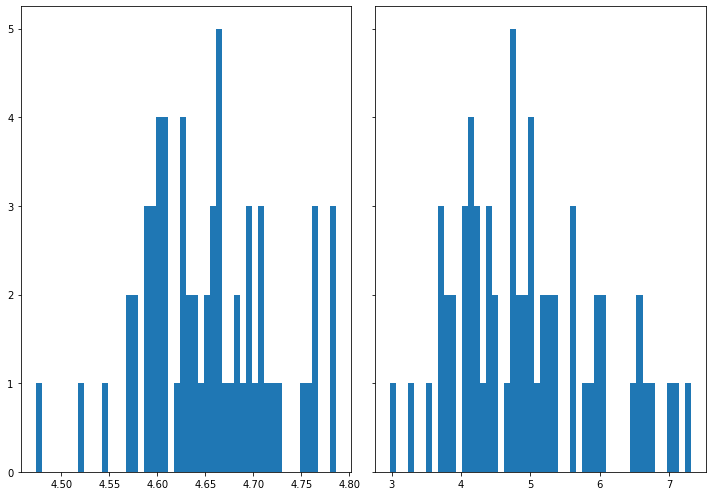

Epoch 33, step 20200: Generator loss: 0.9434307223558426, critic loss: 0.08654197502508752


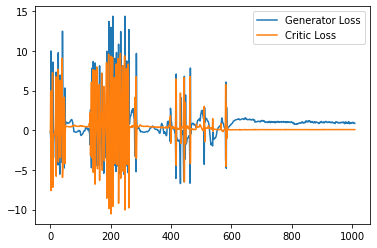

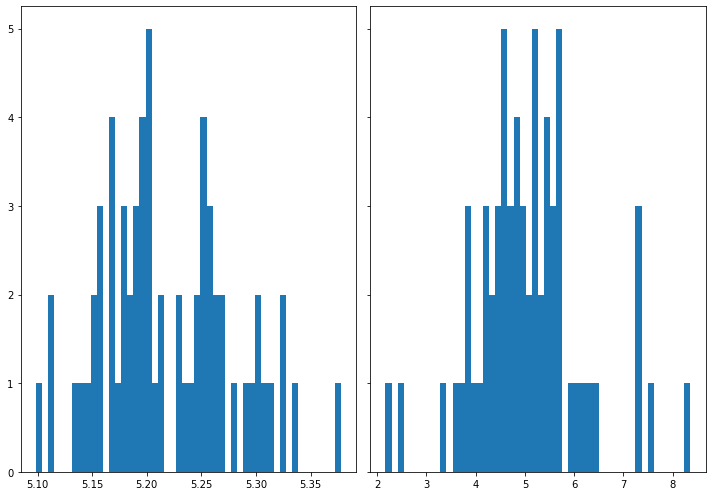

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 34, step 20400: Generator loss: 0.9250705140829086, critic loss: 0.08587268807739017


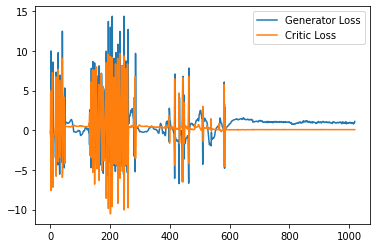

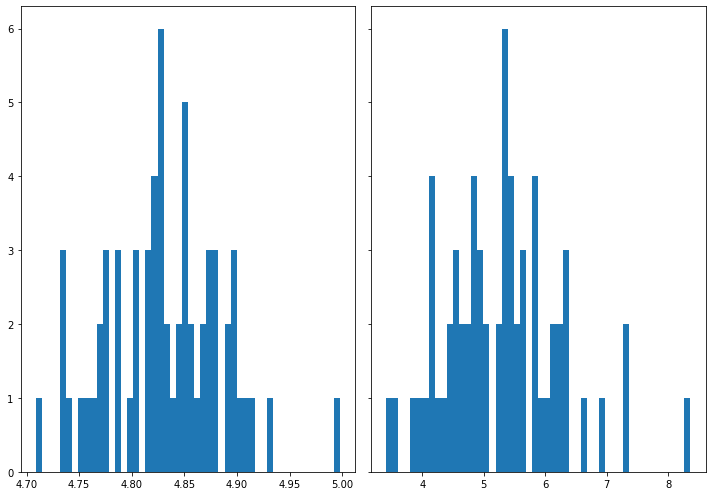

Epoch 34, step 20600: Generator loss: 0.9740124163031578, critic loss: 0.08968878157436844


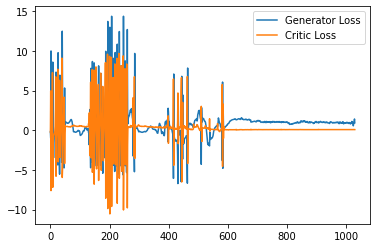

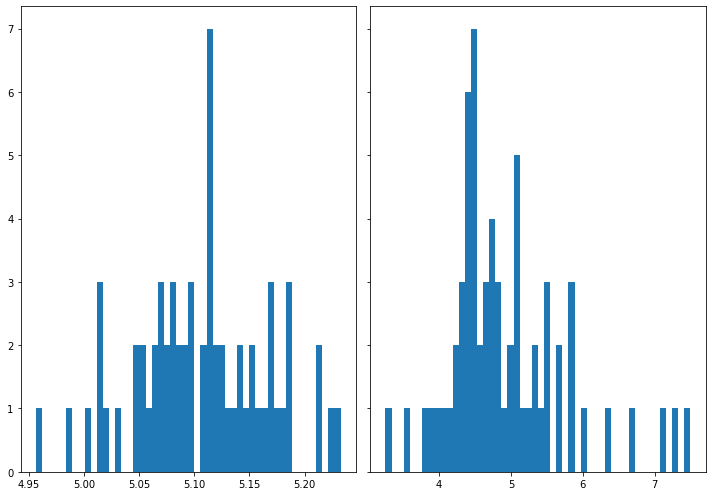

Epoch 34, step 20800: Generator loss: 0.8340701261162757, critic loss: 0.08894151222705844


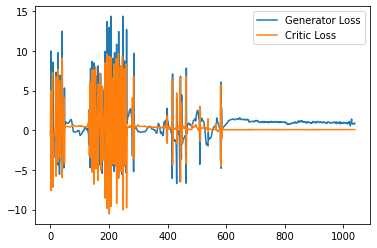

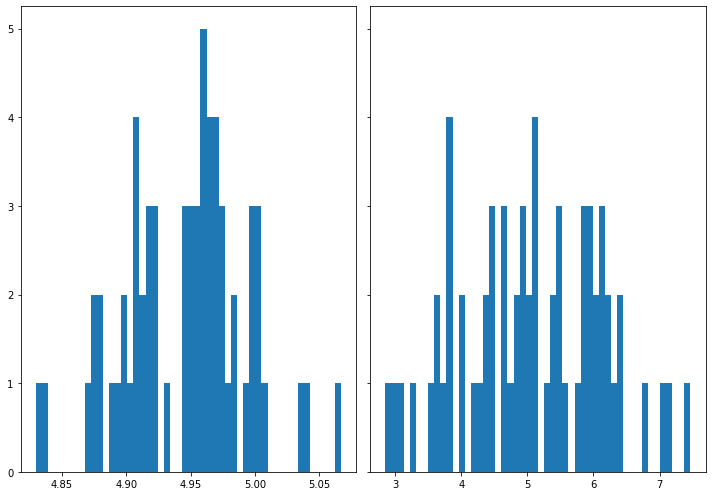

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 35, step 21000: Generator loss: 0.9810322287678719, critic loss: 0.08663873358070857


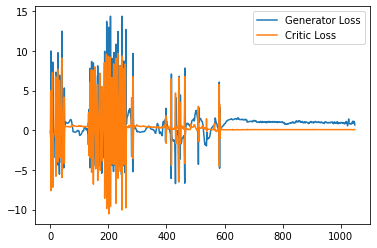

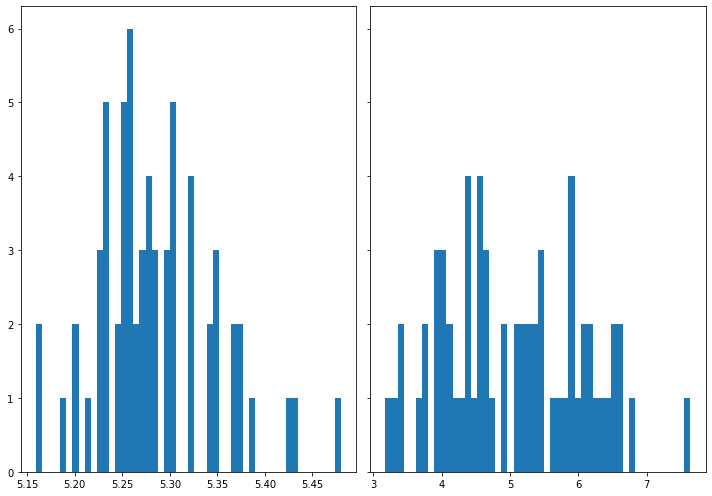

Epoch 35, step 21200: Generator loss: 0.9537206439673901, critic loss: 0.08811284198611974


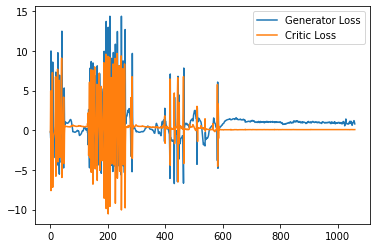

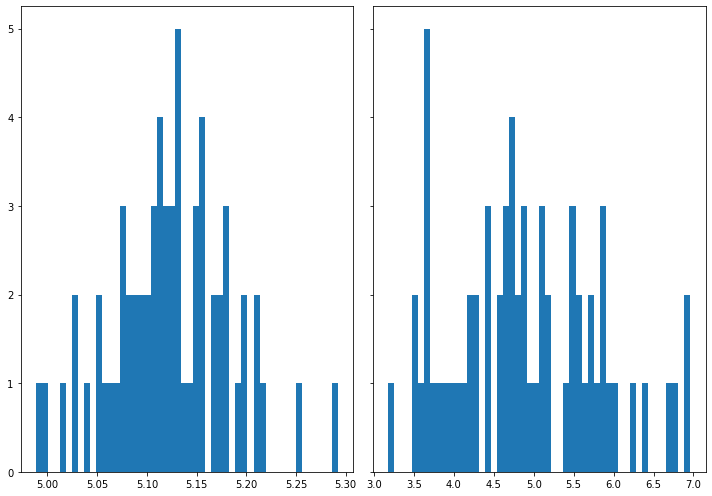

Epoch 35, step 21400: Generator loss: 0.9162690353393554, critic loss: 0.08692583969235419


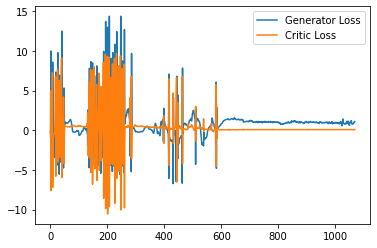

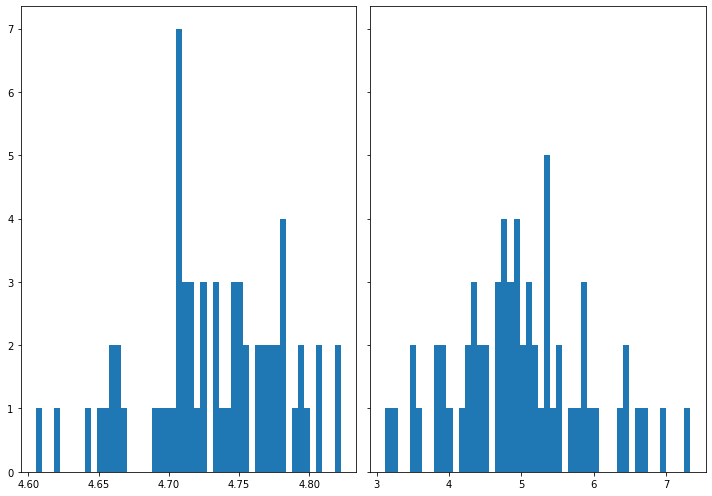

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 36, step 21600: Generator loss: 0.9452853375673294, critic loss: 0.08783326787501573


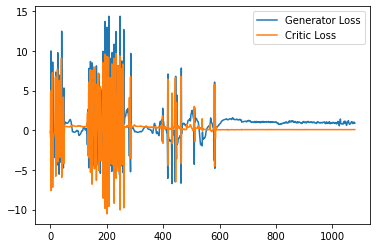

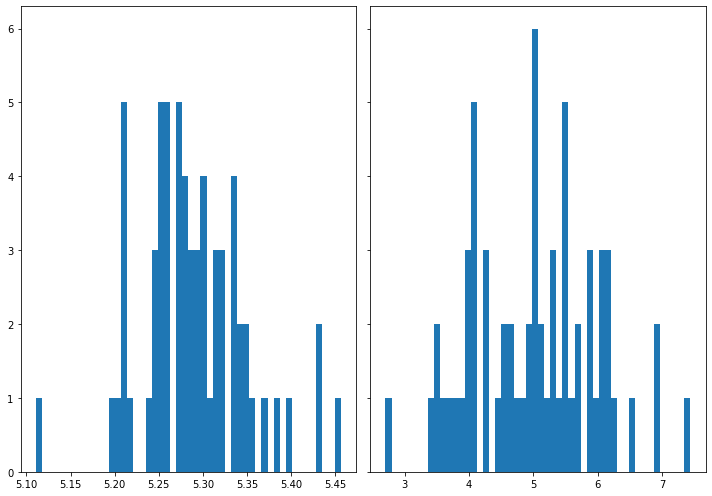

Epoch 36, step 21800: Generator loss: 0.9304245418310165, critic loss: 0.0856185572035611


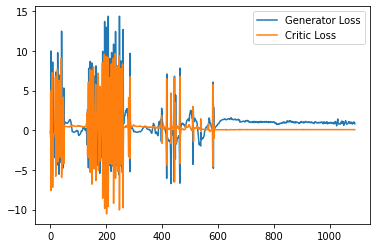

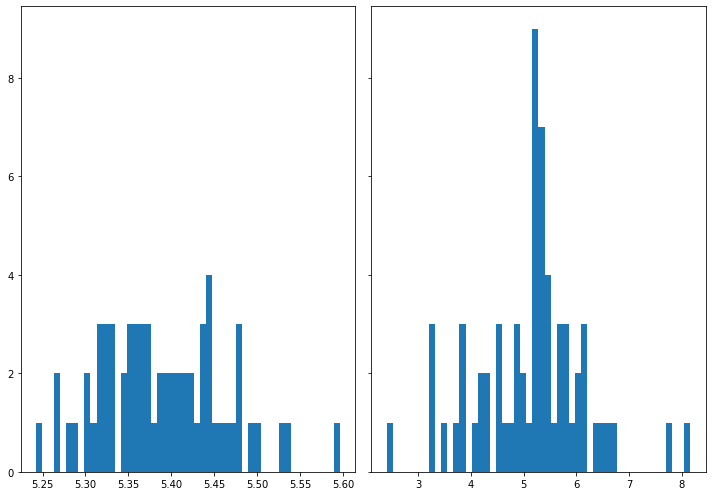

Epoch 36, step 22000: Generator loss: 0.8933259126543999, critic loss: 0.08829768344014885


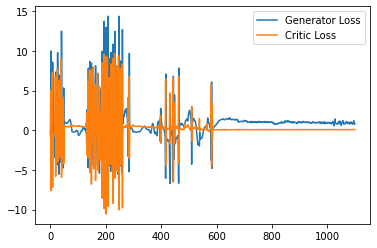

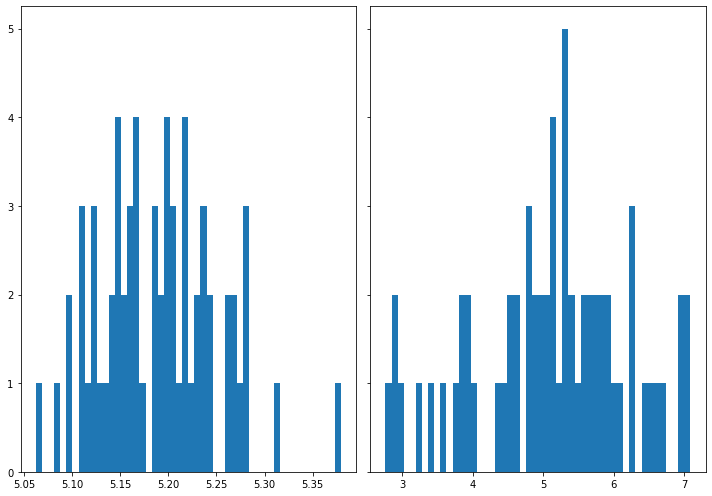

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 37, step 22200: Generator loss: 0.934423856139183, critic loss: 0.087262267831713


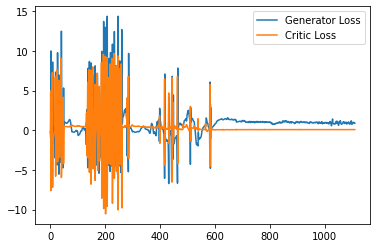

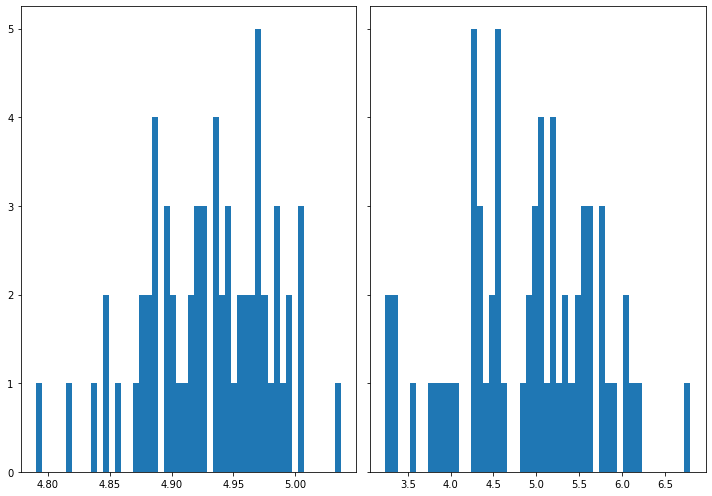

Epoch 37, step 22400: Generator loss: 0.846755789667368, critic loss: 0.08814928863942621


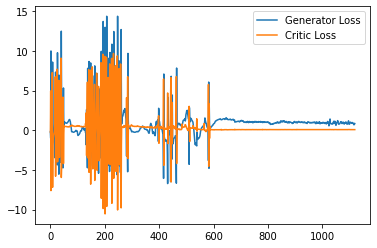

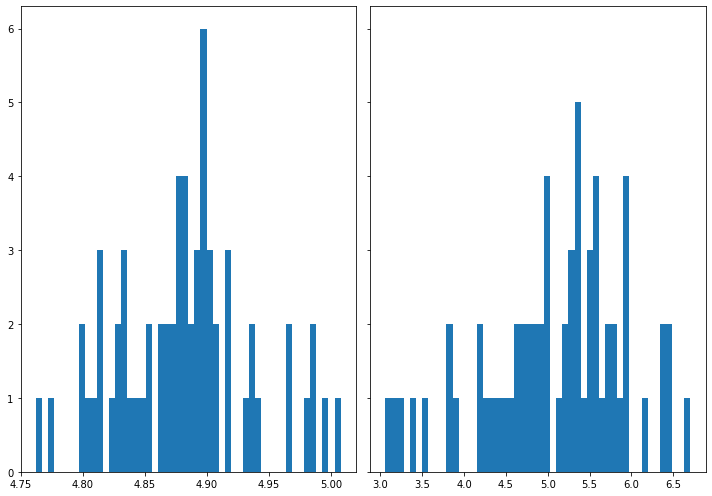

Epoch 37, step 22600: Generator loss: 0.9342038461565971, critic loss: 0.08870093510299919


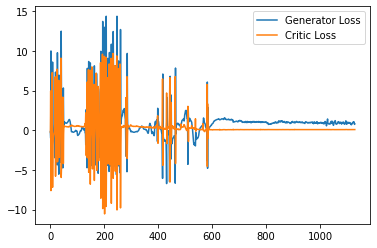

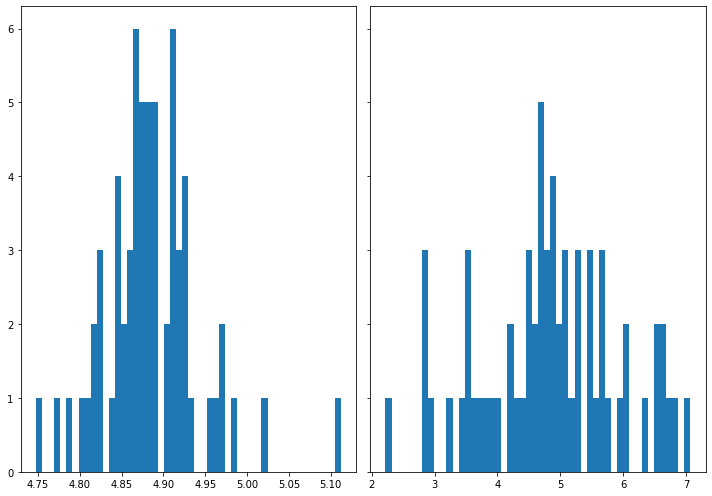

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 38, step 22800: Generator loss: 0.8494684845209122, critic loss: 0.08656756723672153


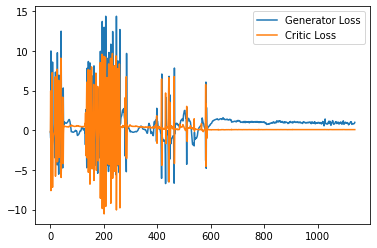

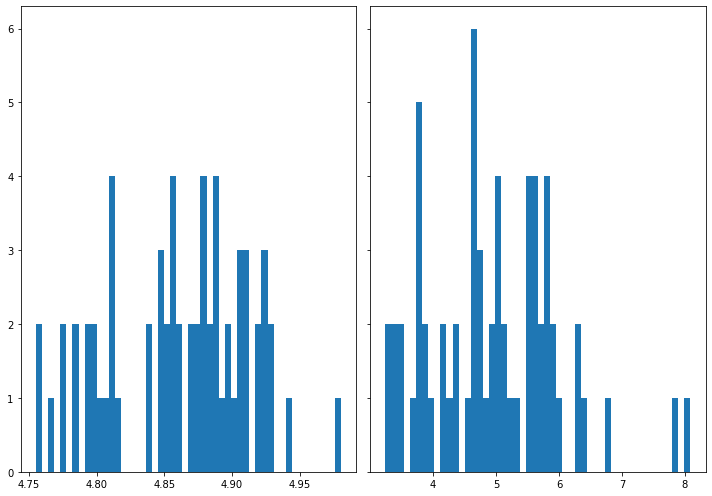

Epoch 38, step 23000: Generator loss: 0.9263068445026874, critic loss: 0.08810300195217126


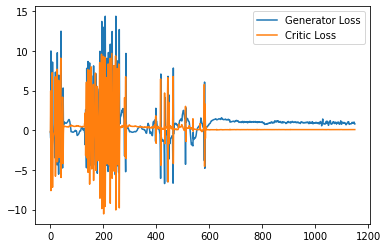

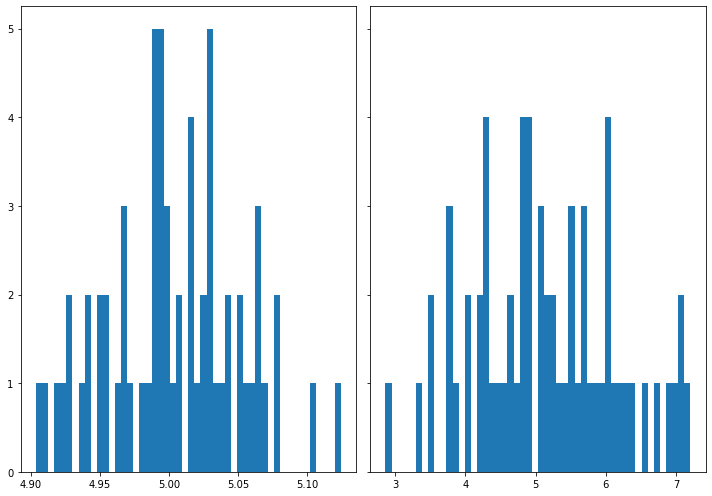

Epoch 38, step 23200: Generator loss: 0.8789485466480255, critic loss: 0.0864564350880682


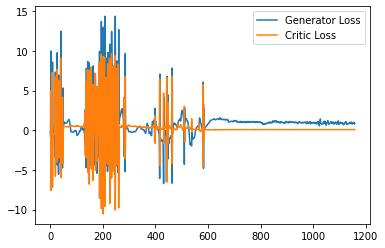

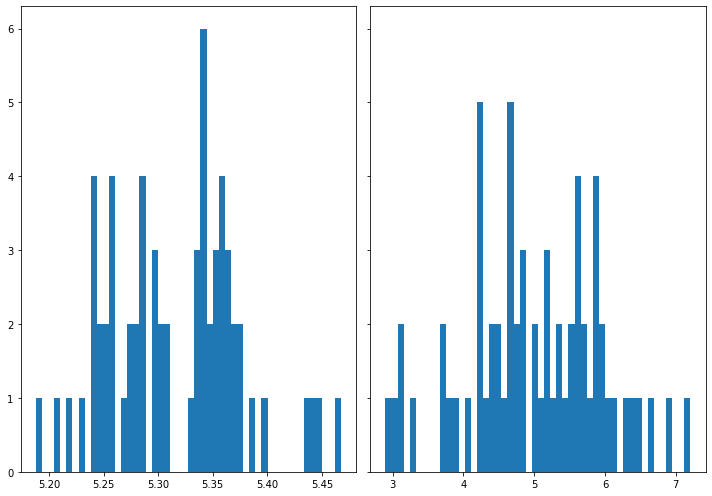

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 39, step 23400: Generator loss: 0.8669561836123466, critic loss: 0.08882128305360673


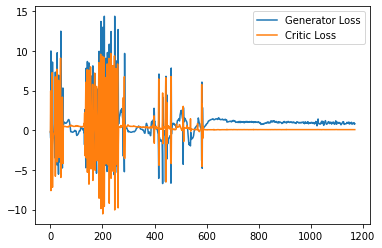

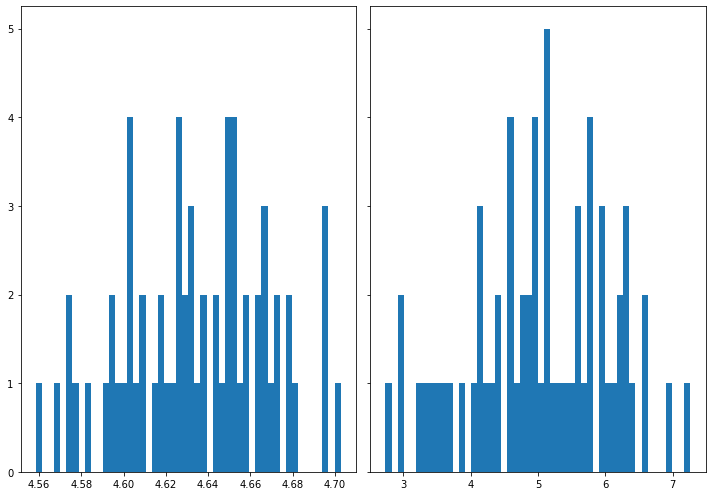

Epoch 39, step 23600: Generator loss: 0.9002448582649231, critic loss: 0.08473798318579794


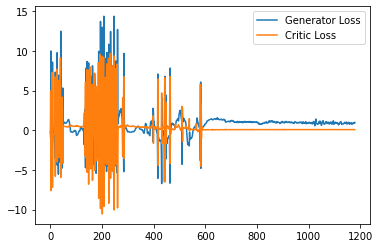

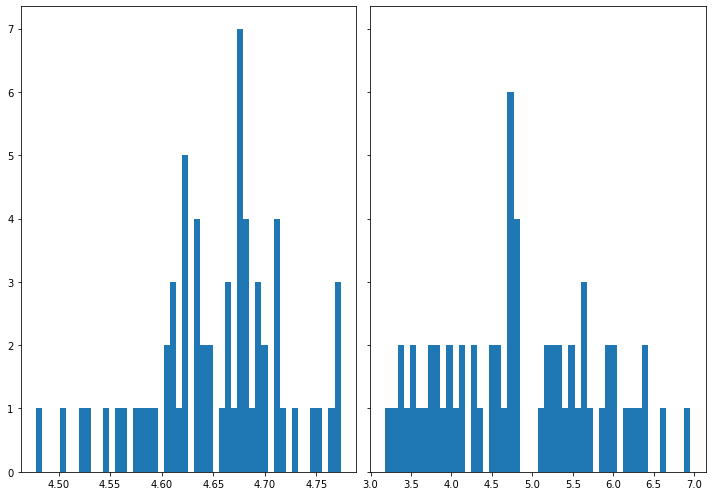

Epoch 39, step 23800: Generator loss: 0.8482890263199806, critic loss: 0.08922370500490072


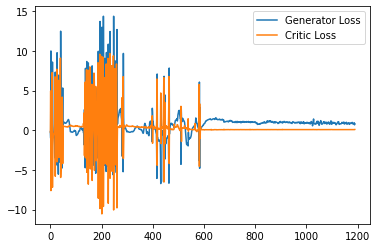

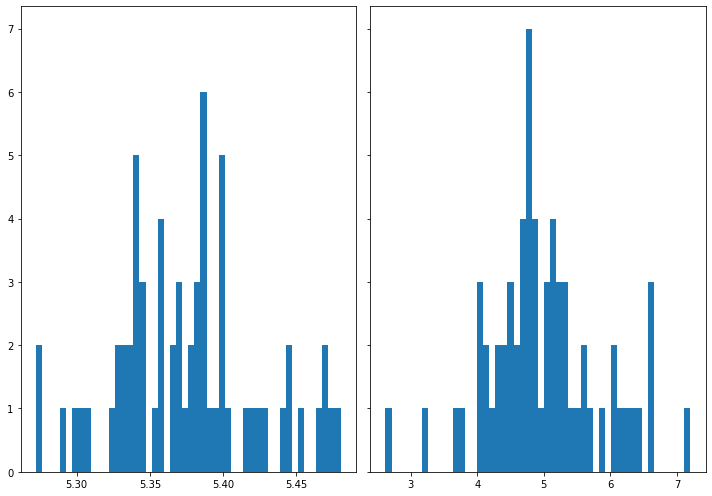

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 40, step 24000: Generator loss: 1.1191086173057556, critic loss: 0.09225341786816714


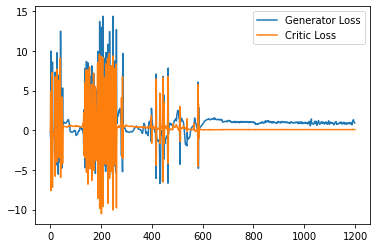

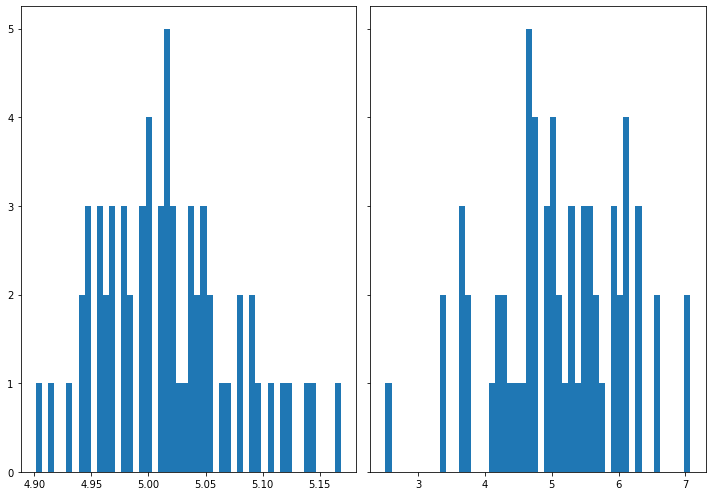

Epoch 40, step 24200: Generator loss: 0.9701206344366073, critic loss: 0.08708036511391402


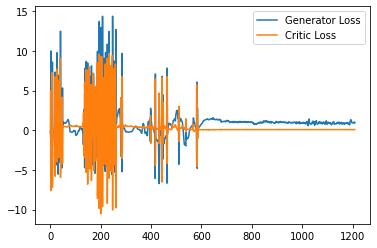

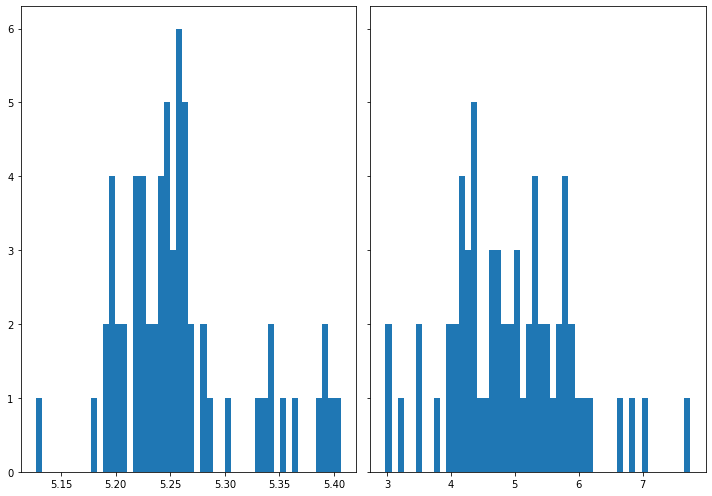

Epoch 40, step 24400: Generator loss: 0.9655154123902321, critic loss: 0.0861197490915656


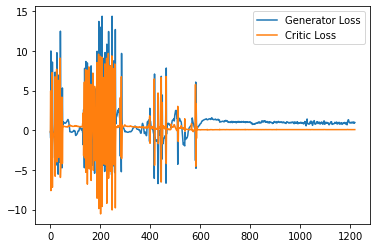

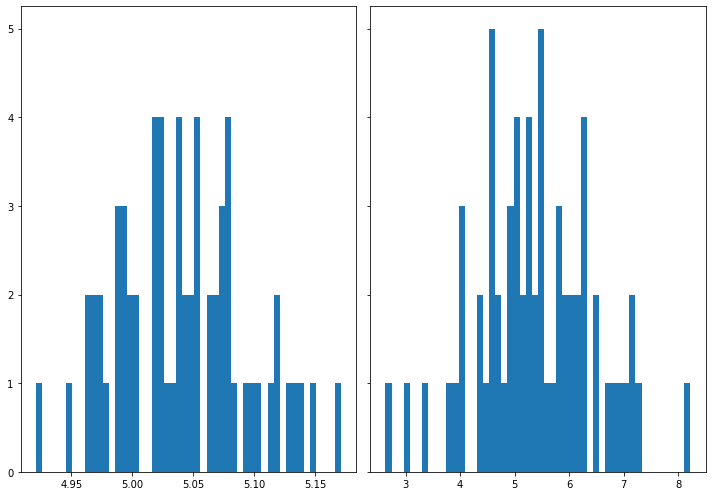

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 41, step 24600: Generator loss: 0.9275787365436554, critic loss: 0.08688309583812952


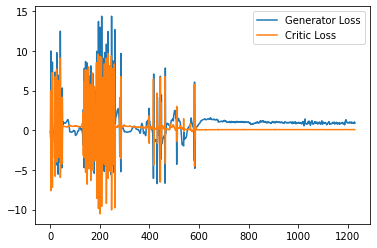

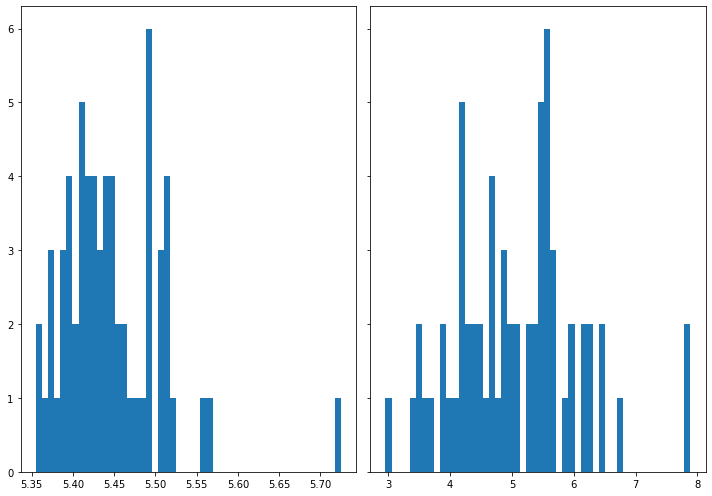

Epoch 41, step 24800: Generator loss: 0.9094562596082687, critic loss: 0.08739948584139345


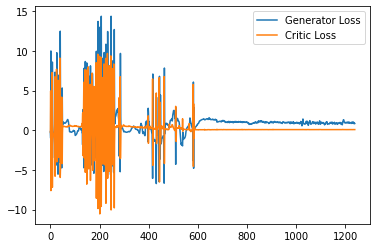

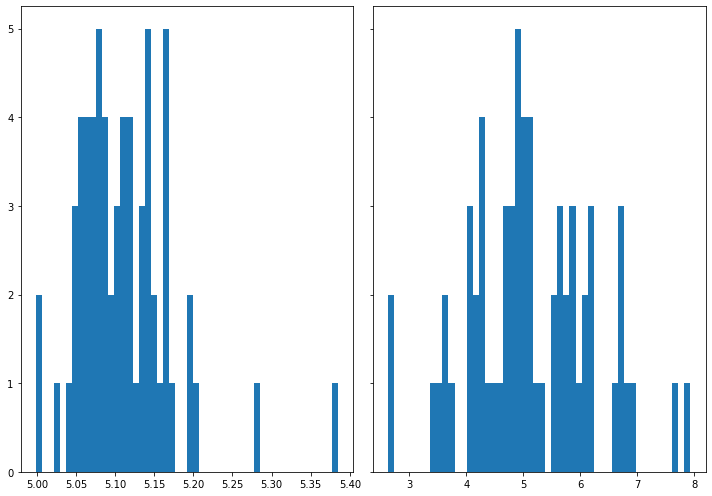

Epoch 41, step 25000: Generator loss: 0.8610358694195748, critic loss: 0.08543116838857534


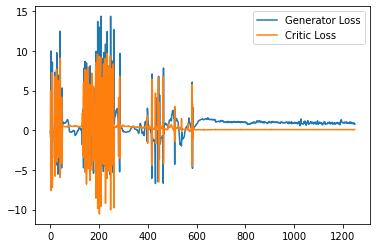

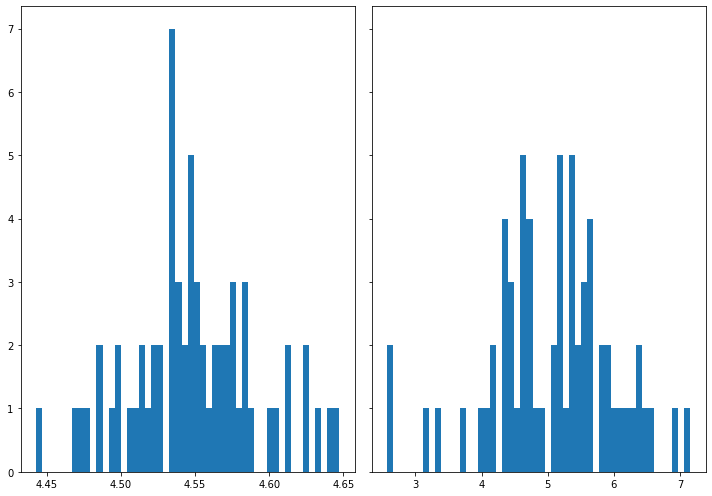

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 42, step 25200: Generator loss: 0.8352622279524803, critic loss: 0.088077005751431


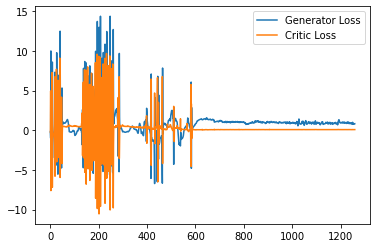

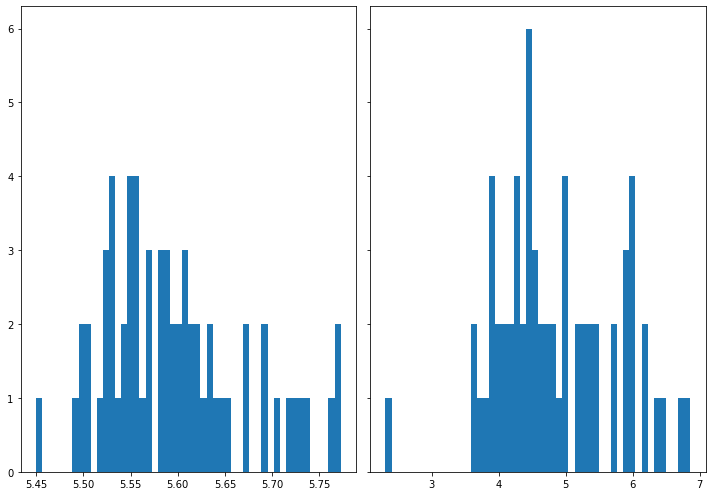

Epoch 42, step 25400: Generator loss: 0.8042887654900551, critic loss: 0.08606111690029504


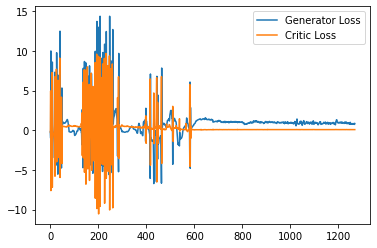

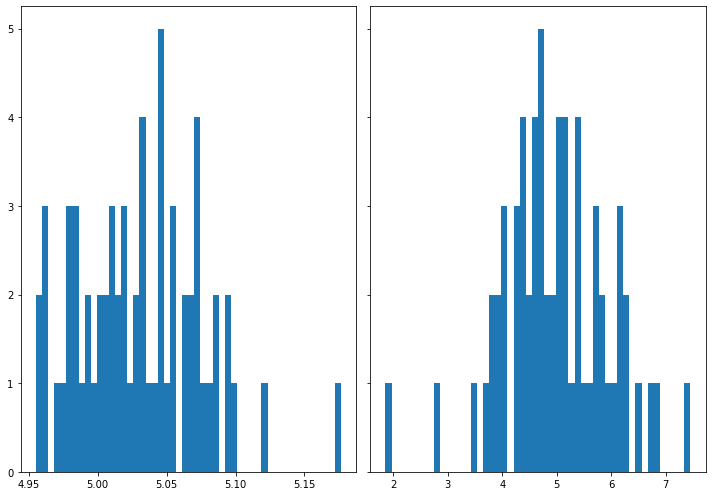

Epoch 42, step 25600: Generator loss: 0.8046070495247841, critic loss: 0.08798222722485657


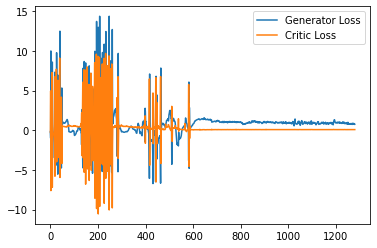

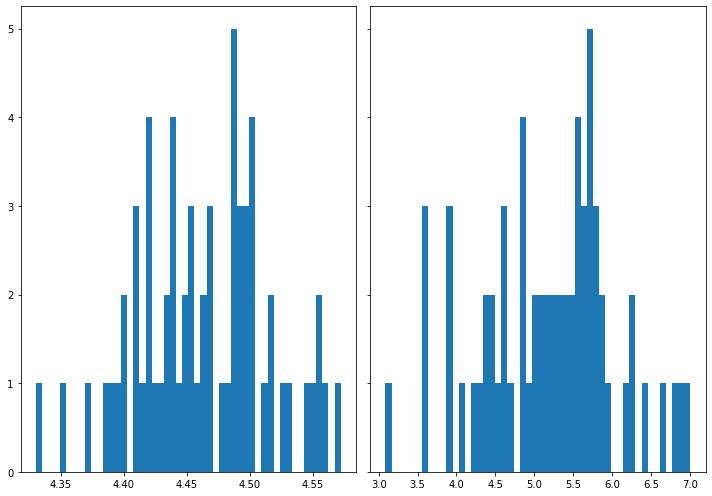

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 43, step 25800: Generator loss: 0.7830016353726387, critic loss: 0.08478047016635541


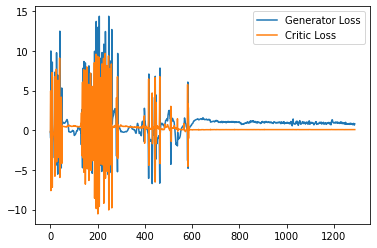

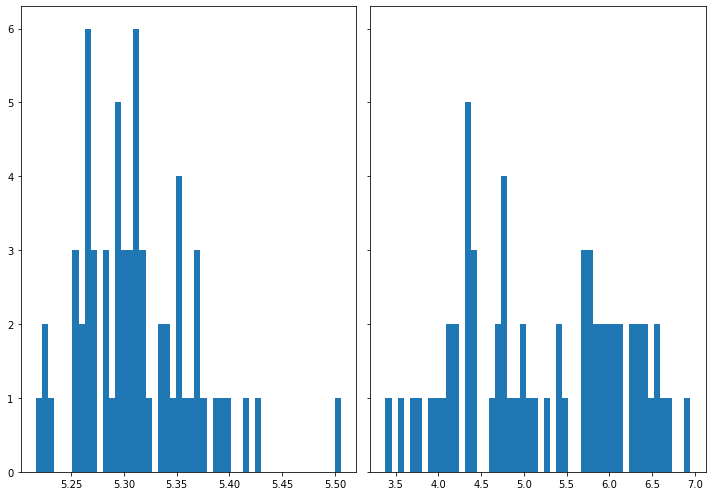

Epoch 43, step 26000: Generator loss: 0.8099708467721939, critic loss: 0.08552204493805765


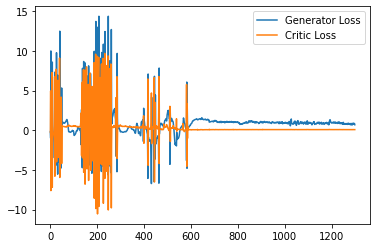

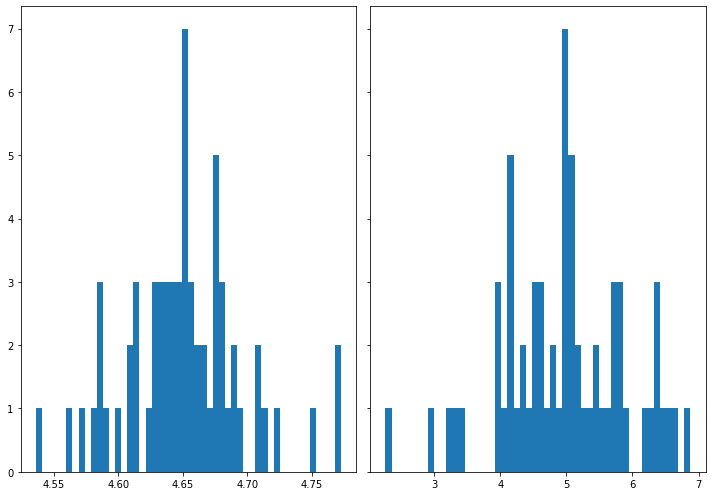

Epoch 43, step 26200: Generator loss: 0.8089763697981834, critic loss: 0.08555461115390063


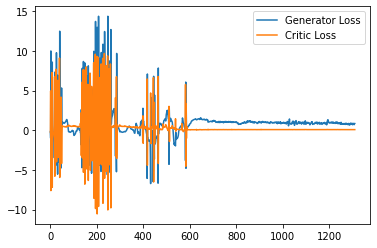

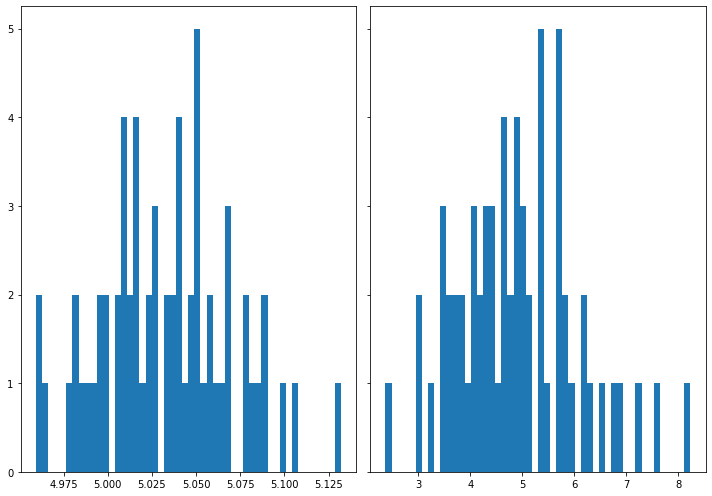

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 44, step 26400: Generator loss: 0.788865936100483, critic loss: 0.08630236834287645


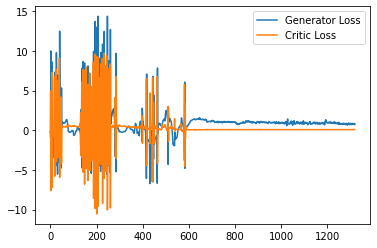

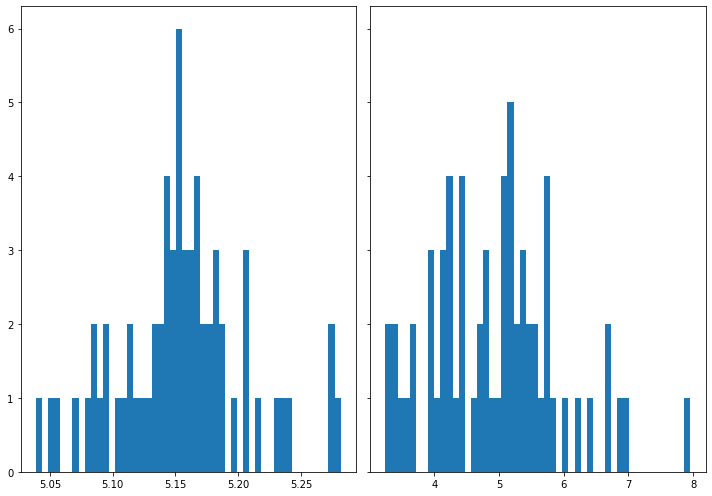

Epoch 44, step 26600: Generator loss: 0.6988837611675263, critic loss: 0.08933550070226187


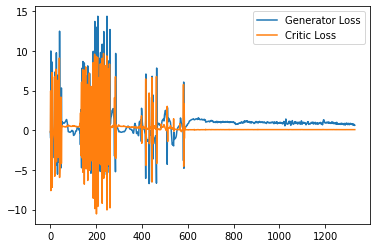

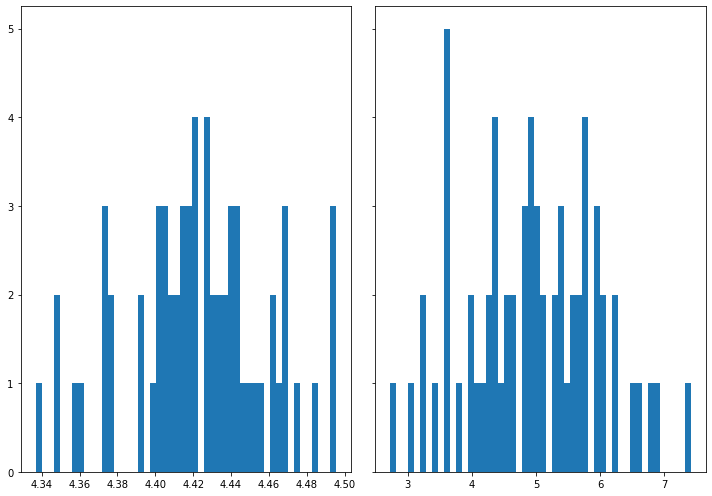

Epoch 44, step 26800: Generator loss: 0.7238252744078636, critic loss: 0.0855000070184469


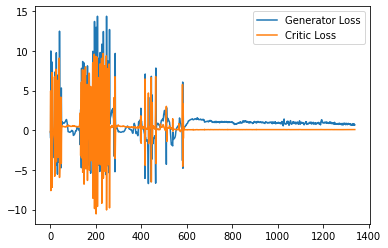

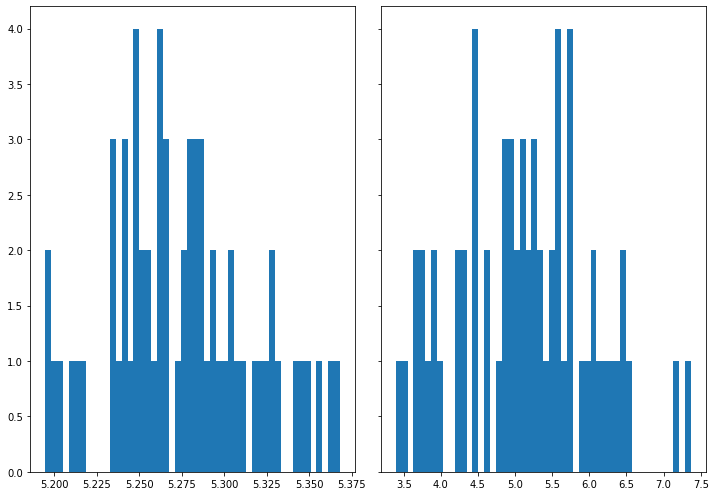

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 45, step 27000: Generator loss: 0.7009426337480545, critic loss: 0.08583136053383356


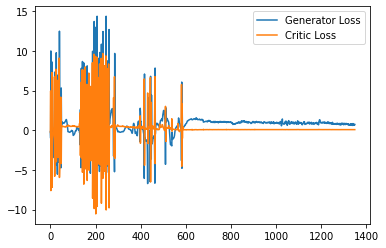

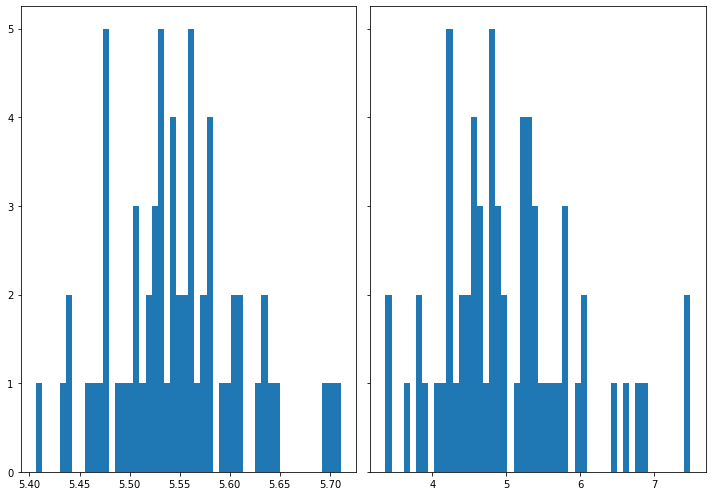

Epoch 45, step 27200: Generator loss: 0.6778785970807075, critic loss: 0.08547345048934223


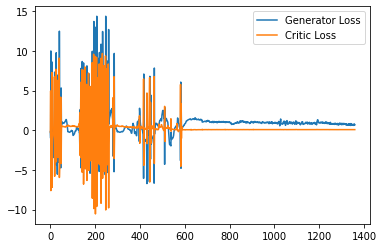

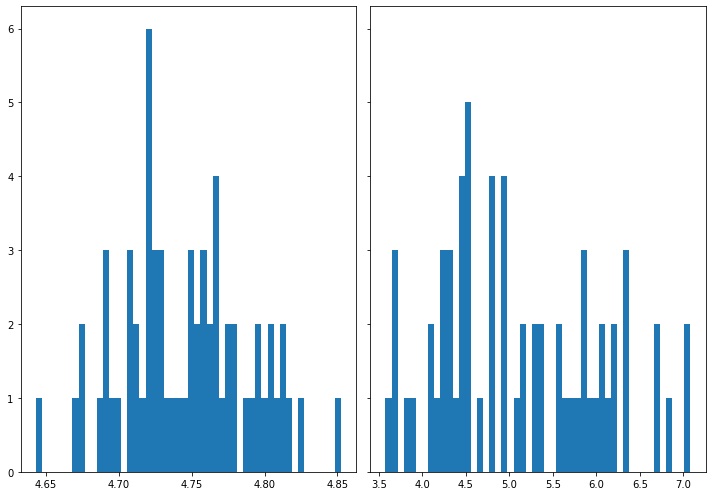

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    # for real, _ in tqdm(dataloader):
    for  _ in tqdm(range(n_batches)): 
        real=torch.randn(batch_size,output_dims,device=device)*1 +5 #not sure 
        cur_batch_size = len(real)
        # real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise[0])
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2[0])
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            # show_tensor_images(fake)
            # show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

            fake_noiseplt = get_noise(cur_batch_size, z_dim, device=device)
            fakeplt = gen(fake_noiseplt[0])

            # Creating histogram
            n_bins=50
            fig, axs = plt.subplots(1, 2,
                                    figsize =(10, 7),
                                    tight_layout = True, sharey=True)
            axs[0].hist(fakeplt.cpu().data.numpy(), bins = n_bins)
            axs[0].ticklabel_format(useOffset=False)#stop scientific notation 
            axs[1].hist(real.cpu().data.numpy(),bins=n_bins)
            # Show plot
            plt.show()

        cur_step += 1

## MMD GAN 

Sobolev GAN for Mixture of Gaussians ? 

# Matching Results

## Vanilla GAN 

### Noise 

In [1]:
def get_noise_p(n_samples, z_dim, norm, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    if norm ==True:
      norm=torch.randn(n_samples,z_dim,device=device) #outputs normal distribution N(0,1)
    else: 
      norm=torch.rand(n_samples,z_dim,device=device) #outputs uniform distribution U(0,1)
    return norm 

### Generator

In [2]:
def get_generator_block_paper(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        #nn.BatchNorm1d(output_dim), 
        #nn.ReLU(inplace=True)
        nn.ELU(alpha=1,inplace=True)
    )

In [31]:
class Generator_P(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        sample_dim: the dimension of the samples, fitted for the dataset used, a scalar.
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=7, sample_dim=1, hidden_dim=13):
        super(Generator_P, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block_paper(z_dim,  m.ceil(hidden_dim/2)),
            get_generator_block_paper(m.ceil(hidden_dim/2), hidden_dim),
            get_generator_block_paper(hidden_dim,m.ceil(hidden_dim/2)),
            nn.Linear(m.ceil(hidden_dim/2),sample_dim),
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [27]:
#Testing 
x=13/2
m.ceil(x)


7

### Critic

In [8]:
def get_critic_block(input_dim, output_dim):
    '''
    Critic Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.ELU(alpha=1,inplace=True)
    )

In [28]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        sample_dim: the dimension of the sample, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, sample_dim=1, hidden_dim=11):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            get_critic_block(sample_dim, m.ceil(hidden_dim/2)),
            get_critic_block(hidden_dim, (hidden_dim*2 +7)),
            get_critic_block((hidden_dim*2 +7), hidden_dim),
            nn.Linear(hidden_dim,sample_dim)
        )

    def forward(self, sample):
        '''
        Function for completing a forward pass of the discriminator: Given an sample tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            sample: a sample output from a specified distribution 
        '''
        return self.crit(sample)
    
    def get_crit(self):
        '''
        Returns:
            the sequential model
        '''
        return self.crit

### Training 

In [20]:
criterion = nn.BCEWithLogitsLoss()
n_epochs =10
z_dim = 10 #input dimentions
output_dims=1
display_step = 1000
batch_size =1000 #number of samples
lr =[0.1,0.01,0.001,0.0001]
hidden_dims=13

data=torch.randn(batch_size,1)*1+5

### DO NOT EDIT ###
device = 'cuda'

In [32]:
gen = Generator_P(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr[0])
crit = Critic(output_dims, hidden_dims).to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr[0])

Loss Calcs and Training Loop

In [34]:
def get_crit_loss(gen, crit, criterion, real, num_samples, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        crit: the discriminator model/critic model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the samples 
               (e.g. fake = 0, real = 1)
        real: a batch of real samples
        num_samples: the number of samples the generator should produce, 
                which is also the length of the real samples
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    z=get_noise(num_samples,z_dim,device=device)
    fakes=gen(z[0]).detach() 
    
    pred_fake=crit(fakes)
    zeros= torch.zeros_like(pred_fake)
    fake_loss=criterion(pred_fake,zeros)
    
    pred_real=crit(real)
    ones=torch.ones_like(pred_real)
    real_loss=criterion(pred_real,ones)

    crit_loss=(fake_loss + real_loss)/2

    return crit_loss

In [35]:
def get_gen_loss(gen,crit, criterion, num_samples, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an sample given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_samples: the number of samples the generator should produce, 
                which is also the length of the real samples
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    z=get_noise(num_samples,z_dim,device=device)
    samples=gen(z[0])
    pred=crit(samples)
    gen_loss=criterion(pred,torch.ones_like(pred))
    return gen_loss

In [ ]:
cur_step = 0
n_batches=600
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False

list_d = list()
list_g = list()

for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    # for real, _ in tqdm(range(n_batches)): #don't know how to fix this.
    for  _ in tqdm(range(n_batches)): 
        real=torch.randn(batch_size,output_dims,device=device)*1 +5 #not sure 
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        # real = real.view(cur_batch_size, -1).to(device)
        
        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size,z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        gen_opt.zero_grad()
        gen_loss=get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        list_d.append(mean_discriminator_loss)
        

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        list_g.append(mean_generator_loss)

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise[0])

            # Creating histogram
            n_bins=50
            fig, axs = plt.subplots(1, 2,
                                    figsize =(10, 7),
                                    tight_layout = True, sharey=True)
            axs[0].hist(fake.cpu().data.numpy(), bins = n_bins)
            axs[0].ticklabel_format(useOffset=False)#stop scientific notation 
            axs[1].hist(real.cpu().data.numpy(),bins=n_bins)
            # Show plot
            plt.show()

            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1